## Imports and Setup

In [1]:
# %%
# SECTION 1: IMPORTS AND SETUP
# =============================================================================
import pandas as pd
import numpy as np
import warnings
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import GroupKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

print("=" * 80)
print("INCOME PREDICTION MODEL - CLEAN PIPELINE STARTED")
print("=" * 80)

INCOME PREDICTION MODEL - CLEAN PIPELINE STARTED


## Data Load 

In [2]:
# %%
# SECTION 2: DATA LOADING AND INITIAL SETUP
# =============================================================================
print("\n🔄 LOADING PROCESSED DATA")
print("-" * 50)

# Define data path
data_path = r'C:\Users\david\OneDrive\Documents\augment-projects\caja-de-ahorros\data\processed'

# Load the main dataset
df_original = pd.read_csv(data_path + '/df_clientes_clean_final.csv')

print(f"✅ Original dataset loaded: {df_original.shape}")
print(f"   Columns: {df_original.shape[1]}")
print(f"   Records: {df_original.shape[0]:,}")


🔄 LOADING PROCESSED DATA
--------------------------------------------------
✅ Original dataset loaded: (29319, 40)
   Columns: 40
   Records: 29,319


## Feature Selection &  Data Preparation

In [3]:
# %%
# SECTION 3: FEATURE SELECTION AND DATASET PREPARATION
# =============================================================================
print("\n🎯 PREPARING FEATURE SET")
print("-" * 50)

# Define columns to keep for modeling
columns_to_keep = [
    # ID columns
    'cliente', 'identificador_unico',
    
    # Target variable
    'ingresos_reportados',
    
    # Core features (already processed)
    'edad', 'letras_mensuales', 'monto_letra', 'saldo','monto_prestamo',
 'tasa_prestamo',
    'fechaingresoempleo', 'fecha_inicio', 'fecha_vencimiento',
    'ocupacion_consolidated', 'ciudad_consolidated',
    'nombreempleadorcliente_consolidated', 'cargoempleocliente_consolidated',
    'sexo_consolidated', 'estado_civil_consolidated', 'pais_consolidated',
    'missing_fechaingresoempleo', 'missing_nombreempleadorcliente', 'missing_cargoempleocliente',
    'is_retired', 'age_group'
]

# Filter to existing columns
existing_columns = [col for col in columns_to_keep if col in df_original.columns]
df_working = df_original[existing_columns].copy()

print(f"✅ Working dataset prepared: {df_working.shape}")
print(f"   Features to process: {len(existing_columns) - 3}")  # Exclude IDs and target



🎯 PREPARING FEATURE SET
--------------------------------------------------
✅ Working dataset prepared: (29319, 24)
   Features to process: 21


In [4]:
# Check for other data quality issues
print("🔍 Data Quality Check:")
print(f"Values exactly $999,999,999: {(df_working['ingresos_reportados'] == 999999999).sum()}")
print(f"Values > $100,000: {(df_working['ingresos_reportados'] > 100000).sum()}")
print(f"Values = $0: {(df_working['ingresos_reportados'] == 0).sum()}")
print(f"Negative values: {(df_working['ingresos_reportados'] < 0).sum()}")

# Show the suspicious high values
high_values = df_working[df_working['ingresos_reportados'] > 50000]['ingresos_reportados'].value_counts()
print(f"\nSuspicious high values:")
print(high_values.head(10))

🔍 Data Quality Check:
Values exactly $999,999,999: 2
Values > $100,000: 11
Values = $0: 548
Negative values: 0

Suspicious high values:
ingresos_reportados
1.000000e+09    2
9.607333e+04    1
7.341200e+04    1
9.181821e+04    1
2.485682e+05    1
9.999900e+04    1
5.273975e+04    1
9.999990e+05    1
6.536483e+04    1
6.005700e+04    1
Name: count, dtype: int64


In [5]:
# RECOMMENDED: Two-step approach
import scipy.stats.mstats as mstats
print("🧹 STEP 1: Remove obvious data entry errors")
print(f"Before: {len(df_working):,} customers")

# Remove the billion-dollar errors
df_working = df_working[df_working['ingresos_reportados'] < 200000]  # $200K cap
print(f"After error removal: {len(df_working):,} customers")

print("🧹 STEP 2: Apply winsorization for remaining outliers")
# Then winsorize the remaining data
df_working['ingresos_reportados'] = mstats.winsorize(
    df_working['ingresos_reportados'], 
    limits=(0.01, 0.02)  # 1% lower, 2% upper
)

print(f"Income range after processing: ${df_working['ingresos_reportados'].min():,.0f} - ${df_working['ingresos_reportados'].max():,.0f}")

🧹 STEP 1: Remove obvious data entry errors
Before: 29,319 customers
After error removal: 29,312 customers
🧹 STEP 2: Apply winsorization for remaining outliers
Income range after processing: $0 - $5,700


## Data Preprocessing Pipeline

In [6]:
df_working.monto_prestamo.isnull().sum()

np.int64(26654)

In [7]:
# %%
# SECTION 4: DATA PREPROCESSING PIPELINE
# =============================================================================
print("\n🔧 DATA PREPROCESSING PIPELINE")
print("-" * 50)

def preprocess_data(df):
    """
    Complete data preprocessing pipeline
    """
    df_processed = df.copy()
    
    # 4.1: Handle Missing Values
    print("   📋 Handling missing values...")
    
    # Core numerical missing values
    if 'monto_letra' in df_processed.columns:
        df_processed['monto_letra_missing'] = df_processed['monto_letra'].isnull().astype(int)
        median_monto = df_processed['monto_letra'].median()
        df_processed['monto_letra'] = df_processed['monto_letra'].fillna(median_monto)
        print(f"      ✅ monto_letra: filled {df_processed['monto_letra_missing'].sum()} missing values")
    
    # New loan features (high missing rate - special handling)
    if 'monto_prestamo' in df_processed.columns:
        missing_count = df_processed['monto_prestamo'].isnull().sum()
        missing_pct = (missing_count / len(df_processed)) * 100
        
        # Create missing flag (important feature!)
        df_processed['monto_prestamo_missing'] = df_processed['monto_prestamo'].isnull().astype(int)
        
        # Fill with 0 (indicates no loan amount recorded)
        df_processed['monto_prestamo'] = df_processed['monto_prestamo'].fillna(0)
        print(f"      ✅ monto_prestamo: filled {missing_count:,} missing values ({missing_pct:.1f}%) with 0")
    
    if 'tasa_prestamo' in df_processed.columns:
        missing_count = df_processed['tasa_prestamo'].isnull().sum()
        missing_pct = (missing_count / len(df_processed)) * 100
        
        # Create missing flag (important feature!)
        df_processed['tasa_prestamo_missing'] = df_processed['tasa_prestamo'].isnull().astype(int)
        
        # Fill with median of available rates (more meaningful than 0)
        median_rate = df_processed['tasa_prestamo'].median()
        df_processed['tasa_prestamo'] = df_processed['tasa_prestamo'].fillna(median_rate)
        print(f"      ✅ tasa_prestamo: filled {missing_count:,} missing values ({missing_pct:.1f}%) with median ({median_rate:.2f})")
    
    # Create derived features from new loan data
    if 'monto_prestamo' in df_processed.columns and 'monto_letra' in df_processed.columns:
        # Loan to payment ratio (when both available)
        df_processed['loan_to_payment_ratio'] = df_processed['monto_prestamo'] / (df_processed['monto_letra'] + 1)
        print(f"      ✅ Created loan_to_payment_ratio feature")
    
    if 'monto_prestamo' in df_processed.columns:
        # Has loan indicator (binary feature)
        df_processed['has_loan_amount'] = (df_processed['monto_prestamo'] > 0).astype(int)
        print(f"      ✅ Created has_loan_amount indicator")
    
    # 4.2: Convert Date Features
    print("   📅 Converting date features...")
    reference_date = pd.Timestamp('2020-01-01')
    date_columns = ['fechaingresoempleo', 'fecha_inicio', 'fecha_vencimiento']
    
    for date_col in date_columns:
        if date_col in df_processed.columns:
            # Convert to datetime
            df_processed[date_col] = pd.to_datetime(df_processed[date_col], errors='coerce')
            
            # Convert to days since reference
            df_processed[f'{date_col}_days'] = (df_processed[date_col] - reference_date).dt.days
            
            # Handle missing values
            missing_count = df_processed[f'{date_col}_days'].isnull().sum()
            if missing_count > 0:
                df_processed[f'{date_col}_missing'] = df_processed[f'{date_col}_days'].isnull().astype(int)
                median_days = df_processed[f'{date_col}_days'].median()
                df_processed[f'{date_col}_days'] = df_processed[f'{date_col}_days'].fillna(median_days)
                print(f"      ✅ {date_col}: converted to days, filled {missing_count} missing")
            
            # Drop original date column
            df_processed.drop(columns=[date_col], inplace=True)
    
    # 4.3: Encode Categorical Features
    print("   🏷️  Encoding categorical features...")
    
    # Low cardinality - One-hot encoding
    low_cardinality = ['sexo_consolidated', 'estado_civil_consolidated', 'pais_consolidated', 'age_group']
    existing_low_card = [col for col in low_cardinality if col in df_processed.columns]
    
    for col in existing_low_card:
        df_processed[col] = df_processed[col].fillna('Unknown')
        dummies = pd.get_dummies(df_processed[col], prefix=col, drop_first=True)
        df_processed = pd.concat([df_processed, dummies], axis=1)
        df_processed.drop(columns=[col], inplace=True)
        print(f"      ✅ {col}: created {len(dummies.columns)} dummy variables")
    
    # High cardinality - Frequency encoding
    high_cardinality = ['ocupacion_consolidated', 'ciudad_consolidated',
                       'nombreempleadorcliente_consolidated', 'cargoempleocliente_consolidated']
    existing_high_card = [col for col in high_cardinality if col in df_processed.columns]
    
    for col in existing_high_card:
        df_processed[col] = df_processed[col].fillna('Unknown')
        freq_map = df_processed[col].value_counts().to_dict()
        new_col_name = f'{col}_freq'
        df_processed[new_col_name] = df_processed[col].map(freq_map)
        df_processed.drop(columns=[col], inplace=True)
        print(f"      ✅ {col}: frequency encoded (range: {df_processed[new_col_name].min()}-{df_processed[new_col_name].max()})")
    
    return df_processed

# Apply preprocessing
df_processed = preprocess_data(df_working)
print(f"\n✅ Preprocessing complete: {df_processed.shape}")


🔧 DATA PREPROCESSING PIPELINE
--------------------------------------------------
   📋 Handling missing values...
      ✅ monto_letra: filled 2298 missing values
      ✅ monto_prestamo: filled 26,654 missing values (90.9%) with 0
      ✅ tasa_prestamo: filled 19,248 missing values (65.7%) with median (0.75)
      ✅ Created loan_to_payment_ratio feature
      ✅ Created has_loan_amount indicator
   📅 Converting date features...
      ✅ fechaingresoempleo: converted to days, filled 8304 missing
      ✅ fecha_inicio: converted to days, filled 9674 missing
      ✅ fecha_vencimiento: converted to days, filled 16613 missing
   🏷️  Encoding categorical features...
      ✅ sexo_consolidated: created 1 dummy variables
      ✅ estado_civil_consolidated: created 2 dummy variables
      ✅ pais_consolidated: created 1 dummy variables
      ✅ age_group: created 6 dummy variables
      ✅ ocupacion_consolidated: frequency encoded (range: 321-7405)
      ✅ ciudad_consolidated: frequency encoded (range: 

### Check 'Ingresos Reportados'

In [8]:
# How many zero incomes do you have?
zero_income_count = (df_processed.ingresos_reportados == 0).sum()
zero_income_pct = (zero_income_count / len(df_processed.ingresos_reportados)) * 100

print(f"Zero income records: {zero_income_count:,} ({zero_income_pct:.1f}%)")

# What do their features look like?
zero_income_mask = (df_processed['ingresos_reportados'] == 0)
zero_income_profiles = df_processed[zero_income_mask]

print(f"Zero income profiles:")
print(f"  Average monto_letra: ${zero_income_profiles['monto_letra'].mean():,.2f}")
print(f"  Average age: {zero_income_profiles['edad'].mean():.1f}")
print(f"  Has loans: {(zero_income_profiles['monto_prestamo'] > 0).sum()}")

Zero income records: 548 (1.9%)
Zero income profiles:
  Average monto_letra: $15.26
  Average age: 38.8
  Has loans: 70


### Remove Zero Incomes 

In [9]:
# Filter out zero incomes before training
non_zero_mask = (df_processed['ingresos_reportados'] > 0)
df_processed = df_processed[non_zero_mask].copy()

print(f"Removed {(~non_zero_mask).sum():,} zero income records")

Removed 548 zero income records


In [10]:
print("📊 INCOME DISTRIBUTION ANALYSIS:")
print(f"Min income: ${df_processed.ingresos_reportados.min():,.2f}")
print(f"Max income: ${df_processed.ingresos_reportados.max():,.2f}")
print(f"Mean income: ${df_processed.ingresos_reportados.mean():,.2f}")
print(f"Median income: ${df_processed.ingresos_reportados.median():,.2f}")

# Check for very low incomes
low_income_count = (df_processed.ingresos_reportados < 1000).sum()
very_low_count = (df_processed.ingresos_reportados < 500).sum()
print(f"Incomes < $1,000: {low_income_count} ({low_income_count/len(df_processed.ingresos_reportados)*100:.1f}%)")
print(f"Incomes < $500: {very_low_count} ({very_low_count/len(df_processed.ingresos_reportados)*100:.1f}%)")

📊 INCOME DISTRIBUTION ANALYSIS:
Min income: $0.01
Max income: $5,699.89
Mean income: $1,497.28
Median income: $1,194.60
Incomes < $1,000: 11681 (40.6%)
Incomes < $500: 1388 (4.8%)


In [11]:
# drop saldos <0
df_processed = df_processed[df_processed['saldo'] >= 0]

### Low Incomes

🔍 ANALYZING LOW INCOME SEGMENT (< $500)
📊 OVERALL INCOME STATISTICS:
count    28665.000000
mean      1494.278329
std       1095.339496
min          0.010000
25%        750.000000
50%       1194.000000
75%       1912.860000
max       5699.890000
Name: ingresos_reportados, dtype: float64

🎯 IDENTIFYING LOW INCOME RECORDS (< $500)
--------------------------------------------------
📈 LOW INCOME ANALYSIS:
   Total records: 28,665
   Low income records (< $500): 1,388
   Percentage: 4.84%

📊 DETAILED BREAKDOWN OF LOW INCOMES
--------------------------------------------------
📋 INCOME RANGE BREAKDOWN:
   Very Low (< $50)    :   197 records ( 0.69%) - Avg: $  1.64
   Extremely Low ($50-$100):    34 records ( 0.12%) - Avg: $ 67.69
   Very Low ($100-$200):   167 records ( 0.58%) - Avg: $131.40
   Low ($200-$300)     :   275 records ( 0.96%) - Avg: $242.72
   Low-Medium ($300-$400):   345 records ( 1.20%) - Avg: $341.52
   Medium-Low ($400-$500):   370 records ( 1.29%) - Avg: $444.22

🔍 ZERO AND 

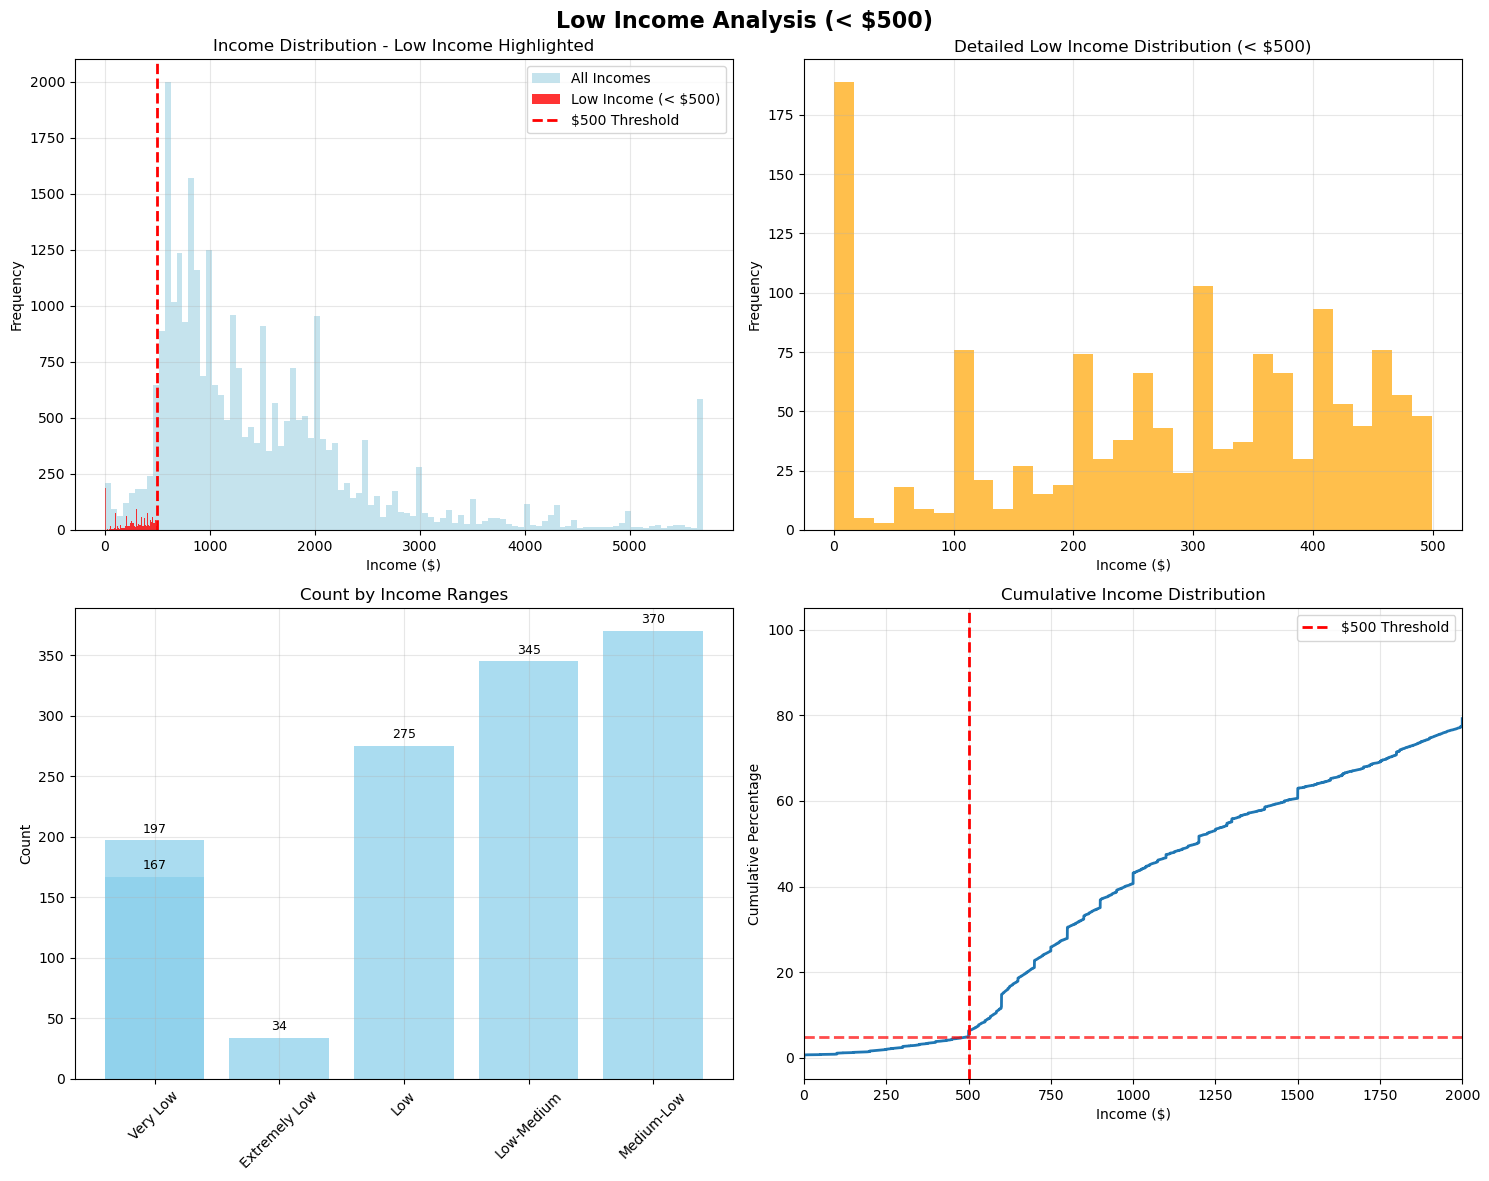


🎯 IMPACT ANALYSIS FOR MODELING
--------------------------------------------------
📊 MODELING IMPLICATIONS:
   Low income records: 1,388 (4.84%)
   ⚠️  MODERATE IMPACT: 4.8% of data is low income
   📋 RECOMMENDATIONS:
      • Use robust evaluation metrics
      • Consider weighted loss functions
      • Monitor performance by income segments

📈 MAPE INFLATION ANALYSIS:
   Records with income < $1000: 11,659
   Percentage < $1000: 40.7%
   ⚠️  These records will cause MAPE inflation in evaluation
   💡 Recommendation: Use 'Robust MAPE' (exclude incomes < $1000)

✅ Low income analysis completed!


In [12]:
# %%
# =============================================================================
# LOW INCOME ANALYSIS - INCOMES UNDER $500
# =============================================================================
print("🔍 ANALYZING LOW INCOME SEGMENT (< $500)")
print("=" * 60)

# Basic statistics for the target variable
print("📊 OVERALL INCOME STATISTICS:")
print(df_processed.ingresos_reportados.describe())

# %%
# SECTION 1: IDENTIFY LOW INCOME RECORDS
# =============================================================================
print("\n🎯 IDENTIFYING LOW INCOME RECORDS (< $500)")
print("-" * 50)

# Define low income threshold
LOW_INCOME_THRESHOLD = 500

# Create mask for low income records
low_income_mask = df_processed['ingresos_reportados'] < LOW_INCOME_THRESHOLD

# Count and percentage
total_records = len(df_processed)
low_income_count = low_income_mask.sum()
low_income_percentage = (low_income_count / total_records) * 100

print(f"📈 LOW INCOME ANALYSIS:")
print(f"   Total records: {total_records:,}")
print(f"   Low income records (< ${LOW_INCOME_THRESHOLD}): {low_income_count:,}")
print(f"   Percentage: {low_income_percentage:.2f}%")

# %%
# SECTION 2: DETAILED BREAKDOWN OF LOW INCOMES
# =============================================================================
print(f"\n📊 DETAILED BREAKDOWN OF LOW INCOMES")
print("-" * 50)

# Create income ranges for detailed analysis
income_ranges = [
    (0, 50, "Very Low (< $50)"),
    (50, 100, "Extremely Low ($50-$100)"),
    (100, 200, "Very Low ($100-$200)"),
    (200, 300, "Low ($200-$300)"),
    (300, 400, "Low-Medium ($300-$400)"),
    (400, 500, "Medium-Low ($400-$500)")
]

print("📋 INCOME RANGE BREAKDOWN:")
for min_val, max_val, label in income_ranges:
    if max_val == float('inf'):
        mask = df_processed['ingresos_reportados'] >= min_val
    else:
        mask = (df_processed['ingresos_reportados'] >= min_val) & (df_processed['ingresos_reportados'] < max_val)
    
    count = mask.sum()
    percentage = (count / total_records) * 100
    
    if count > 0:
        avg_income = df_processed.loc[mask, 'ingresos_reportados'].mean()
        print(f"   {label:20s}: {count:5,} records ({percentage:5.2f}%) - Avg: ${avg_income:6.2f}")

# %%
# SECTION 3: ZERO AND NEAR-ZERO INCOME ANALYSIS
# =============================================================================
print(f"\n🔍 ZERO AND NEAR-ZERO INCOME ANALYSIS")
print("-" * 50)

# Analyze very low incomes
zero_income = (df_processed['ingresos_reportados'] == 0).sum()
near_zero_income = (df_processed['ingresos_reportados'] <= 10).sum()
very_low_income = (df_processed['ingresos_reportados'] <= 50).sum()

print(f"📊 EXTREME LOW INCOME COUNTS:")
print(f"   Exactly $0: {zero_income:,} ({zero_income/total_records*100:.2f}%)")
print(f"   ≤ $10: {near_zero_income:,} ({near_zero_income/total_records*100:.2f}%)")
print(f"   ≤ $50: {very_low_income:,} ({very_low_income/total_records*100:.2f}%)")

# Show some examples of very low incomes
print(f"\n📋 SAMPLE OF LOWEST INCOMES:")
lowest_incomes = df_processed.nsmallest(20, 'ingresos_reportados')[['ingresos_reportados']]
print(lowest_incomes.to_string())

# %%
# SECTION 4: CHARACTERISTICS OF LOW INCOME SEGMENT
# =============================================================================
print(f"\n👥 CHARACTERISTICS OF LOW INCOME SEGMENT (< ${LOW_INCOME_THRESHOLD})")
print("-" * 60)

# Extract low income subset
low_income_df = df_processed[low_income_mask].copy()

print(f"📊 LOW INCOME SEGMENT STATISTICS:")
print(f"   Count: {len(low_income_df):,}")
print(f"   Mean income: ${low_income_df['ingresos_reportados'].mean():.2f}")
print(f"   Median income: ${low_income_df['ingresos_reportados'].median():.2f}")
print(f"   Std deviation: ${low_income_df['ingresos_reportados'].std():.2f}")
print(f"   Min income: ${low_income_df['ingresos_reportados'].min():.2f}")
print(f"   Max income: ${low_income_df['ingresos_reportados'].max():.2f}")

# %%
# SECTION 5: FEATURE ANALYSIS FOR LOW INCOME SEGMENT
# =============================================================================
print(f"\n🔍 FEATURE ANALYSIS FOR LOW INCOME SEGMENT")
print("-" * 50)

# Identify categorical and numerical columns (excluding target)
categorical_cols = df_processed.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = df_processed.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove target variable from analysis
if 'ingresos_reportados' in numerical_cols:
    numerical_cols.remove('ingresos_reportados')

print(f"📋 ANALYZING {len(categorical_cols)} categorical and {len(numerical_cols)} numerical features")

# Analyze top categorical features for low income segment
print(f"\n📊 TOP CATEGORICAL FEATURES IN LOW INCOME SEGMENT:")
for col in categorical_cols[:5]:  # Analyze first 5 categorical columns
    if col in low_income_df.columns:
        print(f"\n   🏷️  {col}:")
        value_counts = low_income_df[col].value_counts().head(5)
        total_low_income = len(low_income_df)
        
        for value, count in value_counts.items():
            percentage = (count / total_low_income) * 100
            print(f"      {str(value)[:30]:30s}: {count:4,} ({percentage:5.1f}%)")

# Analyze numerical features for low income segment
print(f"\n📊 NUMERICAL FEATURES STATISTICS (LOW INCOME vs ALL):")
print(f"{'Feature':<20} {'Low Income Mean':<15} {'Overall Mean':<15} {'Difference':<12}")
print("-" * 65)

for col in numerical_cols[:10]:  # Analyze first 10 numerical columns
    if col in df_processed.columns:
        low_income_mean = low_income_df[col].mean()
        overall_mean = df_processed[col].mean()
        difference = low_income_mean - overall_mean
        
        print(f"{col[:19]:<20} {low_income_mean:>14.2f} {overall_mean:>14.2f} {difference:>11.2f}")

# %%
# SECTION 6: VISUALIZATION OF LOW INCOME DISTRIBUTION
# =============================================================================
print(f"\n📈 CREATING VISUALIZATIONS FOR LOW INCOME ANALYSIS")
print("-" * 50)

import matplotlib.pyplot as plt
import seaborn as sns

# Create figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Low Income Analysis (< $500)', fontsize=16, fontweight='bold')

# 1. Overall income distribution with low income highlighted
ax1 = axes[0, 0]
ax1.hist(df_processed['ingresos_reportados'], bins=100, alpha=0.7, label='All Incomes', color='lightblue')
ax1.hist(df_processed[low_income_mask]['ingresos_reportados'], bins=50, alpha=0.8, label='Low Income (< $500)', color='red')
ax1.axvline(x=LOW_INCOME_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'${LOW_INCOME_THRESHOLD} Threshold')
ax1.set_xlabel('Income ($)')
ax1.set_ylabel('Frequency')
ax1.set_title('Income Distribution - Low Income Highlighted')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Detailed low income distribution
ax2 = axes[0, 1]
ax2.hist(low_income_df['ingresos_reportados'], bins=30, alpha=0.7, color='orange')
ax2.set_xlabel('Income ($)')
ax2.set_ylabel('Frequency')
ax2.set_title(f'Detailed Low Income Distribution (< ${LOW_INCOME_THRESHOLD})')
ax2.grid(True, alpha=0.3)

# 3. Income ranges breakdown (bar chart)
ax3 = axes[1, 0]
range_labels = []
range_counts = []

for min_val, max_val, label in income_ranges:
    if max_val == float('inf'):
        mask = df_processed['ingresos_reportados'] >= min_val
    else:
        mask = (df_processed['ingresos_reportados'] >= min_val) & (df_processed['ingresos_reportados'] < max_val)
    
    count = mask.sum()
    if count > 0:
        range_labels.append(label.split('(')[0].strip())
        range_counts.append(count)

bars = ax3.bar(range_labels, range_counts, color='skyblue', alpha=0.7)
ax3.set_ylabel('Count')
ax3.set_title('Count by Income Ranges')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3)

# Add value labels on bars
for bar, count in zip(bars, range_counts):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(range_counts)*0.01, 
             f'{count:,}', ha='center', va='bottom', fontsize=9)

# 4. Cumulative percentage
ax4 = axes[1, 1]
sorted_incomes = np.sort(df_processed['ingresos_reportados'])
cumulative_pct = np.arange(1, len(sorted_incomes) + 1) / len(sorted_incomes) * 100

ax4.plot(sorted_incomes, cumulative_pct, linewidth=2)
ax4.axvline(x=LOW_INCOME_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'${LOW_INCOME_THRESHOLD} Threshold')
ax4.axhline(y=low_income_percentage, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax4.set_xlabel('Income ($)')
ax4.set_ylabel('Cumulative Percentage')
ax4.set_title('Cumulative Income Distribution')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_xlim(0, 2000)  # Focus on lower income range

plt.tight_layout()
plt.show()

# %%
# SECTION 7: IMPACT ANALYSIS FOR MODELING
# =============================================================================
print(f"\n🎯 IMPACT ANALYSIS FOR MODELING")
print("-" * 50)

print(f"📊 MODELING IMPLICATIONS:")
print(f"   Low income records: {low_income_count:,} ({low_income_percentage:.2f}%)")

if low_income_percentage > 5:
    print(f"   ⚠️  HIGH IMPACT: {low_income_percentage:.1f}% of data is low income")
    print(f"   📋 RECOMMENDATIONS:")
    print(f"      • Consider separate modeling approach for low income segment")
    print(f"      • Use robust transformations (Box-Cox may help)")
    print(f"      • Apply stratified sampling in cross-validation")
    print(f"      • Monitor MAPE carefully (will be inflated by low incomes)")
elif low_income_percentage > 2:
    print(f"   ⚠️  MODERATE IMPACT: {low_income_percentage:.1f}% of data is low income")
    print(f"   📋 RECOMMENDATIONS:")
    print(f"      • Use robust evaluation metrics")
    print(f"      • Consider weighted loss functions")
    print(f"      • Monitor performance by income segments")
else:
    print(f"   ✅ LOW IMPACT: Only {low_income_percentage:.1f}% of data is low income")
    print(f"   📋 RECOMMENDATIONS:")
    print(f"      • Standard modeling approaches should work well")
    print(f"      • Consider removing extreme outliers if needed")

# Calculate potential MAPE inflation
print(f"\n📈 MAPE INFLATION ANALYSIS:")
print(f"   Records with income < $1000: {(df_processed['ingresos_reportados'] < 1000).sum():,}")
print(f"   Percentage < $1000: {(df_processed['ingresos_reportados'] < 1000).mean()*100:.1f}%")
print(f"   ⚠️  These records will cause MAPE inflation in evaluation")
print(f"   💡 Recommendation: Use 'Robust MAPE' (exclude incomes < $1000)")

print(f"\n✅ Low income analysis completed!")

### High Income

🔍 ANALYZING HIGH INCOME SEGMENT (> $5000)
📊 OVERALL INCOME STATISTICS:
count    28665.000000
mean      1494.278329
std       1095.339496
min          0.010000
25%        750.000000
50%       1194.000000
75%       1912.860000
max       5699.890000
Name: ingresos_reportados, dtype: float64

🎯 IDENTIFYING HIGH INCOME RECORDS (> $5000)
--------------------------------------------------
📈 HIGH INCOME ANALYSIS:
   Total records: 28,665
   High income records (> $5000): 747
   Percentage: 2.61%

📊 DETAILED BREAKDOWN OF HIGH INCOMES
--------------------------------------------------
📋 INCOME RANGE BREAKDOWN:
   High ($5K-$7.5K)         :   818 records ( 2.85%) - Avg: $ 5565.26

🔍 EXTREME HIGH INCOME ANALYSIS
--------------------------------------------------
📊 EXTREME HIGH INCOME COUNTS:
   ≥ $20K: 0 (0.00%)
   ≥ $50K: 0 (0.00%)
   ≥ $100K: 0 (0.00%)

📋 SAMPLE OF HIGHEST INCOMES:
     ingresos_reportados
11               5699.89
55               5699.89
274              5699.89
278            

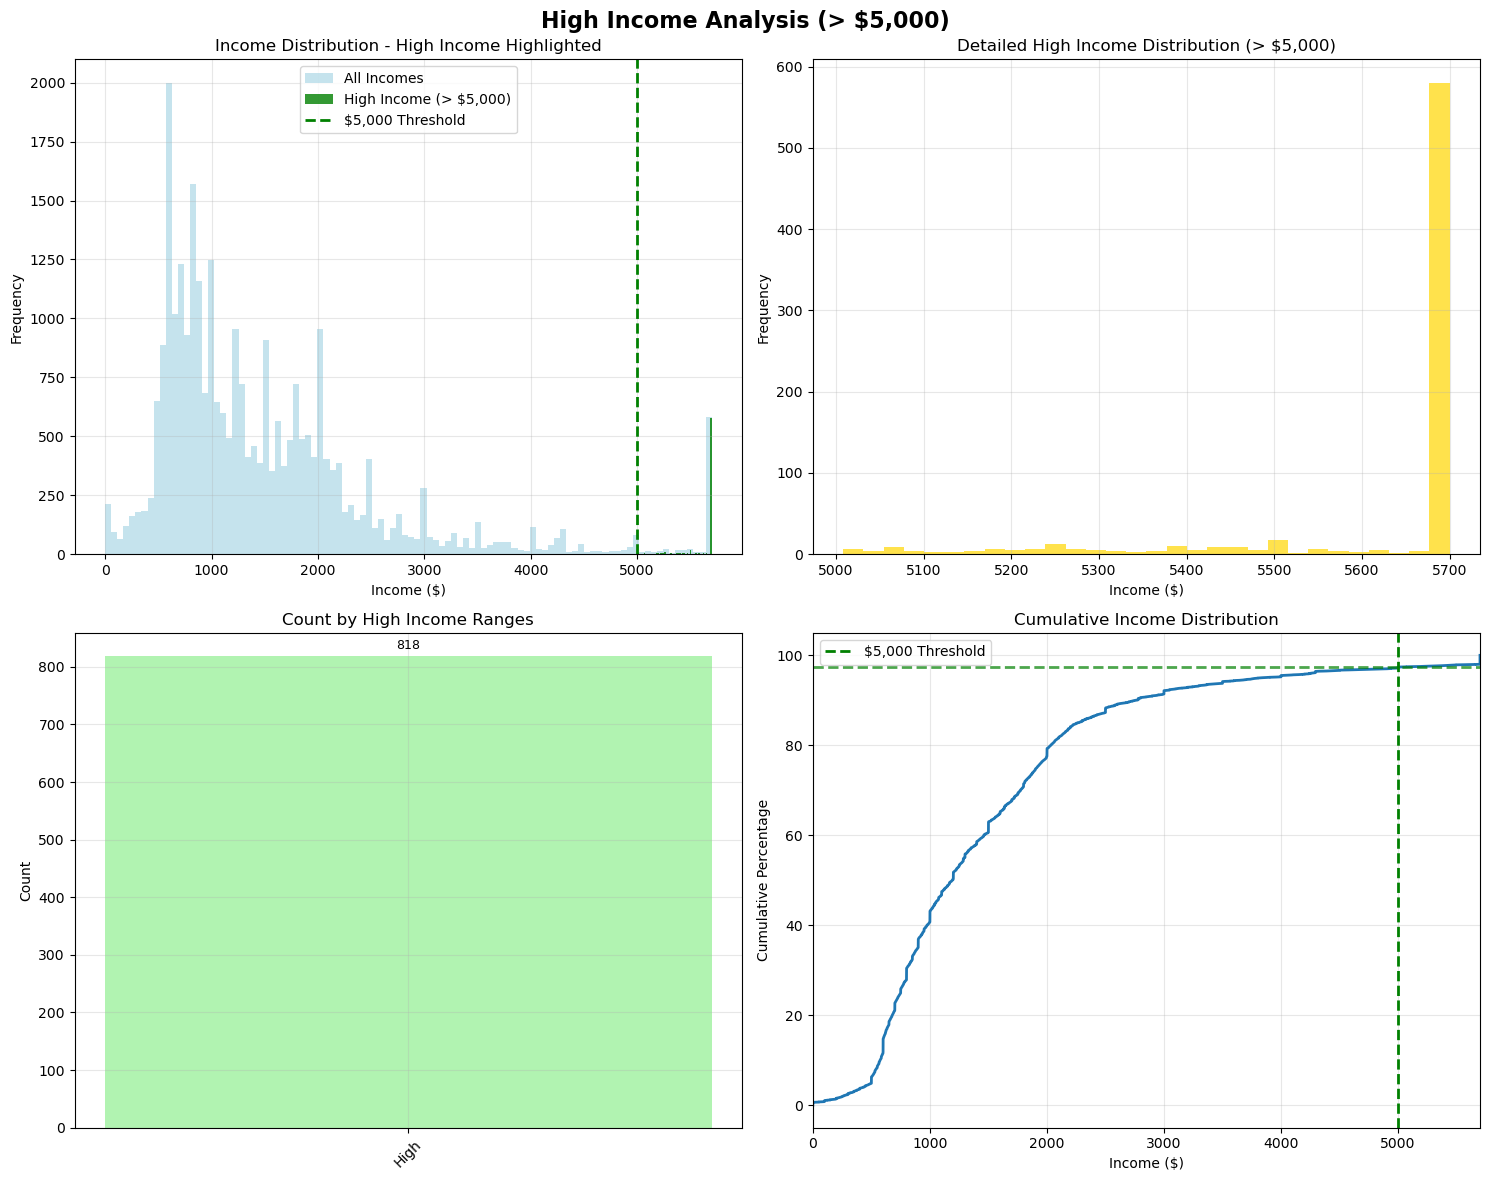


🎯 IMPACT ANALYSIS FOR MODELING
--------------------------------------------------
📊 MODELING IMPLICATIONS:
   High income records: 747 (2.61%)
   ✅ MODERATE IMPACT: 2.6% of data is high income
   📋 RECOMMENDATIONS:
      • Standard modeling approaches should work
      • Monitor high-income prediction accuracy
      • Consider log transformation for income skewness

📈 OUTLIER IMPACT ANALYSIS:
   Records with income > $10K: 0
   Percentage > $10K: 0.0%
   Records with income > $20K: 0
   Percentage > $20K: 0.0%
   💡 Recommendation: Monitor model performance on high-income predictions

📊 INCOME DISTRIBUTION INSIGHTS:
   75th percentile: $1912.86
   90th percentile: $2755.00
   95th percentile: $3827.54
   99th percentile: $5699.89
   ✅ High income threshold ($5,000) captures top 5% earners

✅ High income analysis completed!


In [13]:
# %%
# =============================================================================
# HIGH INCOME ANALYSIS - INCOMES ABOVE $5000
# =============================================================================
print("🔍 ANALYZING HIGH INCOME SEGMENT (> $5000)")
print("=" * 60)

# Basic statistics for the target variable
print("📊 OVERALL INCOME STATISTICS:")
print(df_processed.ingresos_reportados.describe())

# %%
# SECTION 1: IDENTIFY HIGH INCOME RECORDS
# =============================================================================
print("\n🎯 IDENTIFYING HIGH INCOME RECORDS (> $5000)")
print("-" * 50)

# Define high income threshold
HIGH_INCOME_THRESHOLD = 5000

# Create mask for high income records
high_income_mask = df_processed['ingresos_reportados'] > HIGH_INCOME_THRESHOLD

# Count and percentage
total_records = len(df_processed)
high_income_count = high_income_mask.sum()
high_income_percentage = (high_income_count / total_records) * 100

print(f"📈 HIGH INCOME ANALYSIS:")
print(f"   Total records: {total_records:,}")
print(f"   High income records (> ${HIGH_INCOME_THRESHOLD}): {high_income_count:,}")
print(f"   Percentage: {high_income_percentage:.2f}%")

# %%
# SECTION 2: DETAILED BREAKDOWN OF HIGH INCOMES
# =============================================================================
print(f"\n📊 DETAILED BREAKDOWN OF HIGH INCOMES")
print("-" * 50)

# Create income ranges for detailed analysis
income_ranges = [
    (5000, 7500, "High ($5K-$7.5K)"),
    (7500, 10000, "Very High ($7.5K-$10K)"),
    (10000, 15000, "Very High ($10K-$15K)"),
    (15000, 20000, "Extremely High ($15K-$20K)"),
    (20000, 30000, "Ultra High ($20K-$30K)"),
    (30000, float('inf'), "Elite (> $30K)")
]

print("📋 INCOME RANGE BREAKDOWN:")
for min_val, max_val, label in income_ranges:
    if max_val == float('inf'):
        mask = df_processed['ingresos_reportados'] >= min_val
    else:
        mask = (df_processed['ingresos_reportados'] >= min_val) & (df_processed['ingresos_reportados'] < max_val)
    
    count = mask.sum()
    percentage = (count / total_records) * 100
    
    if count > 0:
        avg_income = df_processed.loc[mask, 'ingresos_reportados'].mean()
        print(f"   {label:25s}: {count:5,} records ({percentage:5.2f}%) - Avg: ${avg_income:8.2f}")

# %%
# SECTION 3: EXTREME HIGH INCOME ANALYSIS
# =============================================================================
print(f"\n🔍 EXTREME HIGH INCOME ANALYSIS")
print("-" * 50)

# Analyze very high incomes
ultra_high_income = (df_processed['ingresos_reportados'] >= 20000).sum()
extreme_high_income = (df_processed['ingresos_reportados'] >= 50000).sum()
elite_income = (df_processed['ingresos_reportados'] >= 100000).sum()

print(f"📊 EXTREME HIGH INCOME COUNTS:")
print(f"   ≥ $20K: {ultra_high_income:,} ({ultra_high_income/total_records*100:.2f}%)")
print(f"   ≥ $50K: {extreme_high_income:,} ({extreme_high_income/total_records*100:.2f}%)")
print(f"   ≥ $100K: {elite_income:,} ({elite_income/total_records*100:.2f}%)")

# Show some examples of highest incomes
print(f"\n📋 SAMPLE OF HIGHEST INCOMES:")
highest_incomes = df_processed.nlargest(20, 'ingresos_reportados')[['ingresos_reportados']]
print(highest_incomes.to_string())

# %%
# SECTION 4: CHARACTERISTICS OF HIGH INCOME SEGMENT
# =============================================================================
print(f"\n👥 CHARACTERISTICS OF HIGH INCOME SEGMENT (> ${HIGH_INCOME_THRESHOLD})")
print("-" * 60)

# Extract high income subset
high_income_df = df_processed[high_income_mask].copy()

print(f"📊 HIGH INCOME SEGMENT STATISTICS:")
print(f"   Count: {len(high_income_df):,}")
print(f"   Mean income: ${high_income_df['ingresos_reportados'].mean():.2f}")
print(f"   Median income: ${high_income_df['ingresos_reportados'].median():.2f}")
print(f"   Std deviation: ${high_income_df['ingresos_reportados'].std():.2f}")
print(f"   Min income: ${high_income_df['ingresos_reportados'].min():.2f}")
print(f"   Max income: ${high_income_df['ingresos_reportados'].max():.2f}")

# %%
# SECTION 5: FEATURE ANALYSIS FOR HIGH INCOME SEGMENT
# =============================================================================
print(f"\n🔍 FEATURE ANALYSIS FOR HIGH INCOME SEGMENT")
print("-" * 50)

# Identify categorical and numerical columns (excluding target)
categorical_cols = df_processed.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = df_processed.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove target variable from analysis
if 'ingresos_reportados' in numerical_cols:
    numerical_cols.remove('ingresos_reportados')

print(f"📋 ANALYZING {len(categorical_cols)} categorical and {len(numerical_cols)} numerical features")

# Analyze top categorical features for high income segment
print(f"\n📊 TOP CATEGORICAL FEATURES IN HIGH INCOME SEGMENT:")
for col in categorical_cols[:5]:  # Analyze first 5 categorical columns
    if col in high_income_df.columns:
        print(f"\n   🏷️  {col}:")
        value_counts = high_income_df[col].value_counts().head(5)
        total_high_income = len(high_income_df)
        
        for value, count in value_counts.items():
            percentage = (count / total_high_income) * 100
            print(f"      {str(value)[:30]:30s}: {count:4,} ({percentage:5.1f}%)")

# Analyze numerical features for high income segment
print(f"\n📊 NUMERICAL FEATURES STATISTICS (HIGH INCOME vs ALL):")
print(f"{'Feature':<20} {'High Income Mean':<16} {'Overall Mean':<15} {'Difference':<12}")
print("-" * 68)

for col in numerical_cols[:10]:  # Analyze first 10 numerical columns
    if col in df_processed.columns:
        high_income_mean = high_income_df[col].mean()
        overall_mean = df_processed[col].mean()
        difference = high_income_mean - overall_mean
        
        print(f"{col[:19]:<20} {high_income_mean:>15.2f} {overall_mean:>14.2f} {difference:>11.2f}")

# %%
# SECTION 6: VISUALIZATION OF HIGH INCOME DISTRIBUTION
# =============================================================================
print(f"\n📈 CREATING VISUALIZATIONS FOR HIGH INCOME ANALYSIS")
print("-" * 50)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle(f'High Income Analysis (> ${HIGH_INCOME_THRESHOLD:,})', fontsize=16, fontweight='bold')

# 1. Overall income distribution with high income highlighted
ax1 = axes[0, 0]
ax1.hist(df_processed['ingresos_reportados'], bins=100, alpha=0.7, label='All Incomes', color='lightblue')
ax1.hist(df_processed[high_income_mask]['ingresos_reportados'], bins=50, alpha=0.8, label=f'High Income (> ${HIGH_INCOME_THRESHOLD:,})', color='green')
ax1.axvline(x=HIGH_INCOME_THRESHOLD, color='green', linestyle='--', linewidth=2, label=f'${HIGH_INCOME_THRESHOLD:,} Threshold')
ax1.set_xlabel('Income ($)')
ax1.set_ylabel('Frequency')
ax1.set_title('Income Distribution - High Income Highlighted')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Detailed high income distribution
ax2 = axes[0, 1]
if len(high_income_df) > 0:
    ax2.hist(high_income_df['ingresos_reportados'], bins=30, alpha=0.7, color='gold')
ax2.set_xlabel('Income ($)')
ax2.set_ylabel('Frequency')
ax2.set_title(f'Detailed High Income Distribution (> ${HIGH_INCOME_THRESHOLD:,})')
ax2.grid(True, alpha=0.3)

# 3. Income ranges breakdown (bar chart)
ax3 = axes[1, 0]
range_labels = []
range_counts = []

for min_val, max_val, label in income_ranges:
    if max_val == float('inf'):
        mask = df_processed['ingresos_reportados'] >= min_val
    else:
        mask = (df_processed['ingresos_reportados'] >= min_val) & (df_processed['ingresos_reportados'] < max_val)
    
    count = mask.sum()
    if count > 0:
        range_labels.append(label.split('(')[0].strip())
        range_counts.append(count)

if range_counts:  # Only create bars if we have data
    bars = ax3.bar(range_labels, range_counts, color='lightgreen', alpha=0.7)
    ax3.set_ylabel('Count')
    ax3.set_title('Count by High Income Ranges')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, count in zip(bars, range_counts):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(range_counts)*0.01, 
                 f'{count:,}', ha='center', va='bottom', fontsize=9)

# 4. Cumulative percentage (focusing on high income range)
ax4 = axes[1, 1]
sorted_incomes = np.sort(df_processed['ingresos_reportados'])
cumulative_pct = np.arange(1, len(sorted_incomes) + 1) / len(sorted_incomes) * 100

ax4.plot(sorted_incomes, cumulative_pct, linewidth=2)
ax4.axvline(x=HIGH_INCOME_THRESHOLD, color='green', linestyle='--', linewidth=2, label=f'${HIGH_INCOME_THRESHOLD:,} Threshold')
ax4.axhline(y=100-high_income_percentage, color='green', linestyle='--', linewidth=2, alpha=0.7)
ax4.set_xlabel('Income ($)')
ax4.set_ylabel('Cumulative Percentage')
ax4.set_title('Cumulative Income Distribution')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_xlim(0, min(50000, df_processed['ingresos_reportados'].max()))  # Focus on relevant range

plt.tight_layout()
plt.show()

# %%
# SECTION 7: IMPACT ANALYSIS FOR MODELING
# =============================================================================
print(f"\n🎯 IMPACT ANALYSIS FOR MODELING")
print("-" * 50)

print(f"📊 MODELING IMPLICATIONS:")
print(f"   High income records: {high_income_count:,} ({high_income_percentage:.2f}%)")

if high_income_percentage > 10:
    print(f"   ⚠️  HIGH IMPACT: {high_income_percentage:.1f}% of data is high income")
    print(f"   📋 RECOMMENDATIONS:")
    print(f"      • Consider separate modeling approach for high income segment")
    print(f"      • Use robust transformations to handle income skewness")
    print(f"      • Apply stratified sampling in cross-validation")
    print(f"      • Monitor performance on high-income predictions carefully")
elif high_income_percentage > 5:
    print(f"   ⚠️  MODERATE IMPACT: {high_income_percentage:.1f}% of data is high income")
    print(f"   📋 RECOMMENDATIONS:")
    print(f"      • Use robust evaluation metrics")
    print(f"      • Consider weighted loss functions")
    print(f"      • Monitor performance by income segments")
    print(f"      • High earners may have different feature patterns")
elif high_income_percentage > 1:
    print(f"   ✅ MODERATE IMPACT: {high_income_percentage:.1f}% of data is high income")
    print(f"   📋 RECOMMENDATIONS:")
    print(f"      • Standard modeling approaches should work")
    print(f"      • Monitor high-income prediction accuracy")
    print(f"      • Consider log transformation for income skewness")
else:
    print(f"   ✅ LOW IMPACT: Only {high_income_percentage:.1f}% of data is high income")
    print(f"   📋 RECOMMENDATIONS:")
    print(f"      • Standard modeling approaches should work well")
    print(f"      • High income outliers may need special attention")

# Calculate potential outlier impact
print(f"\n📈 OUTLIER IMPACT ANALYSIS:")
print(f"   Records with income > $10K: {(df_processed['ingresos_reportados'] > 10000).sum():,}")
print(f"   Percentage > $10K: {(df_processed['ingresos_reportados'] > 10000).mean()*100:.1f}%")
print(f"   Records with income > $20K: {(df_processed['ingresos_reportados'] > 20000).sum():,}")
print(f"   Percentage > $20K: {(df_processed['ingresos_reportados'] > 20000).mean()*100:.1f}%")
print(f"   💡 Recommendation: Monitor model performance on high-income predictions")

# Income distribution insights
print(f"\n📊 INCOME DISTRIBUTION INSIGHTS:")
q75 = df_processed['ingresos_reportados'].quantile(0.75)
q90 = df_processed['ingresos_reportados'].quantile(0.90)
q95 = df_processed['ingresos_reportados'].quantile(0.95)
q99 = df_processed['ingresos_reportados'].quantile(0.99)

print(f"   75th percentile: ${q75:.2f}")
print(f"   90th percentile: ${q90:.2f}")
print(f"   95th percentile: ${q95:.2f}")
print(f"   99th percentile: ${q99:.2f}")

if HIGH_INCOME_THRESHOLD > q95:
    print(f"   ✅ High income threshold (${HIGH_INCOME_THRESHOLD:,}) captures top 5% earners")
elif HIGH_INCOME_THRESHOLD > q90:
    print(f"   ✅ High income threshold (${HIGH_INCOME_THRESHOLD:,}) captures top 10% earners")
else:
    print(f"   ⚠️  High income threshold (${HIGH_INCOME_THRESHOLD:,}) may be too low")

print(f"\n✅ High income analysis completed!")

In [14]:
#filter incomes greates than 300 and low that 4000
df_processed = df_processed[(df_processed['ingresos_reportados'] >= 300) & (df_processed['ingresos_reportados'] <= 3500)]

In [15]:
#filter incomes greates than 300 
#df_processed = df_processed[df_processed['ingresos_reportados'] >= 444]

<Axes: xlabel='ingresos_reportados', ylabel='Density'>

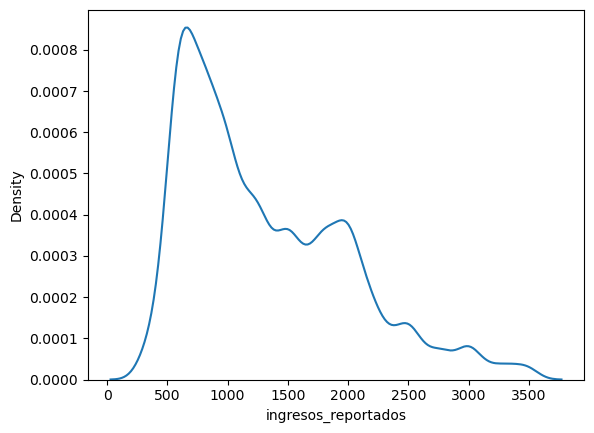

In [16]:
#kdplot of ingresos_reportados
sns.kdeplot(df_processed['ingresos_reportados'])

In [17]:
df_processed.to_csv(data_path + '/df_processed_augmented_final.csv', index=False)

In [18]:
#check if 'saldo' < 0
df_processed[df_processed['saldo'] < 0]

,cliente,identificador_unico,ingresos_reportados,edad,letras_mensuales,monto_letra,saldo,monto_prestamo,tasa_prestamo,missing_fechaingresoempleo,missing_nombreempleadorcliente,missing_cargoempleocliente,is_retired,monto_letra_missing,monto_prestamo_missing,tasa_prestamo_missing,loan_to_payment_ratio,has_loan_amount,fechaingresoempleo_days,fechaingresoempleo_missing,fecha_inicio_days,fecha_inicio_missing,fecha_vencimiento_days,fecha_vencimiento_missing,sexo_consolidated_Masculino,estado_civil_consolidated_Others,estado_civil_consolidated_Soltero,pais_consolidated_PANAMA,age_group_26-35,age_group_36-45,age_group_46-55,age_group_56-65,age_group_65+,age_group_Unknown,ocupacion_consolidated_freq,ciudad_consolidated_freq,nombreempleadorcliente_consolidated_freq,cargoempleocliente_consolidated_freq


## Feature Engineering Function

In [19]:
# %%
# SECTION 5: ENHANCED FEATURE ENGINEERING WITH NEW LOAN FEATURES (DTYPE FIXED)
# =============================================================================
print("\n⚙️ ENHANCED FEATURE ENGINEERING SETUP (WITH LOAN FEATURES)")
print("-" * 60)

# =============================================================================
# PREPROCESSING FUNCTION WITH PROPER DTYPE HANDLING
# =============================================================================

def preprocess_data_fixed(df):
    """
    Complete data preprocessing pipeline with proper dtype handling
    """
    df_processed = df.copy()

    # 4.1: Handle Missing Values
    print("   📋 Handling missing values...")

    # Core numerical missing values
    if 'monto_letra' in df_processed.columns:
        df_processed['monto_letra_missing'] = df_processed['monto_letra'].isnull().astype('int32')
        median_monto = df_processed['monto_letra'].median()
        df_processed['monto_letra'] = df_processed['monto_letra'].fillna(median_monto).astype('float32')
        print(f"      ✅ monto_letra: filled {df_processed['monto_letra_missing'].sum()} missing values")

    # New loan features (high missing rate - special handling)
    if 'monto_prestamo' in df_processed.columns:
        missing_count = df_processed['monto_prestamo'].isnull().sum()
        missing_pct = (missing_count / len(df_processed)) * 100

        # Create missing flag (important feature!)
        df_processed['monto_prestamo_missing'] = df_processed['monto_prestamo'].isnull().astype('int32')

        # Fill with 0 (indicates no loan amount recorded)
        df_processed['monto_prestamo'] = df_processed['monto_prestamo'].fillna(0).astype('float32')
        print(f"      ✅ monto_prestamo: filled {missing_count:,} missing values ({missing_pct:.1f}%) with 0")

    if 'tasa_prestamo' in df_processed.columns:
        missing_count = df_processed['tasa_prestamo'].isnull().sum()
        missing_pct = (missing_count / len(df_processed)) * 100

        # Create missing flag (important feature!)
        df_processed['tasa_prestamo_missing'] = df_processed['tasa_prestamo'].isnull().astype('int32')

        # Fill with median of available rates (more meaningful than 0)
        median_rate = df_processed['tasa_prestamo'].median()
        df_processed['tasa_prestamo'] = df_processed['tasa_prestamo'].fillna(median_rate).astype('float32')
        print(f"      ✅ tasa_prestamo: filled {missing_count:,} missing values ({missing_pct:.1f}%) with median ({median_rate:.2f})")

    # Create derived features from new loan data
    if 'monto_prestamo' in df_processed.columns and 'monto_letra' in df_processed.columns:
        # Loan to payment ratio (when both available)
        df_processed['loan_to_payment_ratio'] = (df_processed['monto_prestamo'] / (df_processed['monto_letra'] + 1)).astype('float32')
        print(f"      ✅ Created loan_to_payment_ratio feature")

    if 'monto_prestamo' in df_processed.columns:
        # Has loan indicator (binary feature)
        df_processed['has_loan_amount'] = (df_processed['monto_prestamo'] > 0).astype('int32')
        print(f"      ✅ Created has_loan_amount indicator")

    # 4.2: Convert Date Features
    print("   📅 Converting date features...")
    reference_date = pd.Timestamp('2020-01-01')
    date_columns = ['fechaingresoempleo', 'fecha_inicio', 'fecha_vencimiento']

    for date_col in date_columns:
        if date_col in df_processed.columns:
            # Convert to datetime
            df_processed[date_col] = pd.to_datetime(df_processed[date_col], errors='coerce')

            # Convert to days since reference
            df_processed[f'{date_col}_days'] = ((df_processed[date_col] - reference_date).dt.days).astype('float32')

            # Handle missing values
            missing_count = df_processed[f'{date_col}_days'].isnull().sum()
            if missing_count > 0:
                df_processed[f'{date_col}_missing'] = df_processed[f'{date_col}_days'].isnull().astype('int32')
                median_days = df_processed[f'{date_col}_days'].median()
                df_processed[f'{date_col}_days'] = df_processed[f'{date_col}_days'].fillna(median_days).astype('float32')
                print(f"      ✅ {date_col}: converted to days, filled {missing_count} missing")

            # Drop original date column
            df_processed.drop(columns=[date_col], inplace=True)

    # 4.3: Encode Categorical Features (FIXED VERSION)
    print("   🏷️  Encoding categorical features with proper dtypes...")

    # Low cardinality - One-hot encoding with proper dtypes
    low_cardinality = ['sexo_consolidated', 'estado_civil_consolidated', 'pais_consolidated', 'age_group']
    existing_low_card = [col for col in low_cardinality if col in df_processed.columns]

    for col in existing_low_card:
        df_processed[col] = df_processed[col].fillna('Unknown')

        # KEY FIX: Add dtype=int parameter and explicit conversion
        dummies = pd.get_dummies(df_processed[col], prefix=col, drop_first=True, dtype='int32')

        # Double-check conversion to int32
        for dummy_col in dummies.columns:
            dummies[dummy_col] = dummies[dummy_col].astype('int32')

        df_processed = pd.concat([df_processed, dummies], axis=1)
        df_processed.drop(columns=[col], inplace=True)
        print(f"      ✅ {col}: created {len(dummies.columns)} dummy variables (int32)")

    # High cardinality - Frequency encoding
    high_cardinality = ['ocupacion_consolidated', 'ciudad_consolidated',
                       'nombreempleadorcliente_consolidated', 'cargoempleocliente_consolidated']
    existing_high_card = [col for col in high_cardinality if col in df_processed.columns]

    for col in existing_high_card:
        df_processed[col] = df_processed[col].fillna('Unknown')
        freq_map = df_processed[col].value_counts().to_dict()
        new_col_name = f'{col}_freq'
        df_processed[new_col_name] = df_processed[col].map(freq_map).astype('int32')
        df_processed.drop(columns=[col], inplace=True)
        print(f"      ✅ {col}: frequency encoded (range: {df_processed[new_col_name].min()}-{df_processed[new_col_name].max()})")

    return df_processed

def create_interaction_features(df):
    """
    Create advanced interaction features for enhanced model performance
    Focus on interpretable, business-meaningful features
    ENHANCED VERSION: Includes new loan features (monto_prestamo, tasa_prestamo)
    DTYPE FIXED: All features are ML-compatible (int32/float32)
    """
    df_enhanced = df.copy()

    print(f"   🔧 Creating interaction features for dataset: {df.shape}")

    # Get age group columns
    age_columns = [col for col in df.columns if col.startswith('age_group_')]
    
    # =============================================================================
    # NEW SECTION: LOAN-SPECIFIC FEATURE ENGINEERING
    # =============================================================================
    print("   💳 Creating loan-specific features...")
    
    # 1. LOAN AMOUNT FEATURES
    if 'monto_prestamo' in df.columns:
        # Loan amount categories
        loan_25th = df_enhanced['monto_prestamo'].quantile(0.25)
        loan_50th = df_enhanced['monto_prestamo'].quantile(0.50)
        loan_75th = df_enhanced['monto_prestamo'].quantile(0.75)
        loan_90th = df_enhanced['monto_prestamo'].quantile(0.90)

        df_enhanced['small_loan'] = ((df_enhanced['monto_prestamo'] > 0) &
                                   (df_enhanced['monto_prestamo'] <= loan_25th)).astype('int32')
        df_enhanced['medium_loan'] = ((df_enhanced['monto_prestamo'] > loan_25th) &
                                    (df_enhanced['monto_prestamo'] <= loan_75th)).astype('int32')
        df_enhanced['large_loan'] = ((df_enhanced['monto_prestamo'] > loan_75th) &
                                   (df_enhanced['monto_prestamo'] <= loan_90th)).astype('int32')
        df_enhanced['jumbo_loan'] = (df_enhanced['monto_prestamo'] > loan_90th).astype('int32')

        # Loan amount per age (loan capacity indicator)
        if 'edad' in df.columns:
            df_enhanced['loan_per_age'] = (df_enhanced['monto_prestamo'] / (df_enhanced['edad'] + 1)).astype('float32')
            df_enhanced['high_loan_capacity'] = (df_enhanced['loan_per_age'] >=
                                               df_enhanced['loan_per_age'].quantile(0.8)).astype('int32')

        print(f"      ✅ Created loan amount category and capacity features")
    
    # 2. INTEREST RATE FEATURES
    if 'tasa_prestamo' in df.columns:
        # Interest rate categories
        rate_25th = df_enhanced['tasa_prestamo'].quantile(0.25)
        rate_75th = df_enhanced['tasa_prestamo'].quantile(0.75)

        df_enhanced['low_interest_rate'] = (df_enhanced['tasa_prestamo'] <= rate_25th).astype('int32')
        df_enhanced['high_interest_rate'] = (df_enhanced['tasa_prestamo'] >= rate_75th).astype('int32')
        df_enhanced['medium_interest_rate'] = ((df_enhanced['tasa_prestamo'] > rate_25th) &
                                             (df_enhanced['tasa_prestamo'] < rate_75th)).astype('int32')

        # Interest rate risk categories
        df_enhanced['premium_rate'] = (df_enhanced['tasa_prestamo'] <= 2.0).astype('int32')  # Very low rate
        df_enhanced['standard_rate'] = ((df_enhanced['tasa_prestamo'] > 2.0) &
                                      (df_enhanced['tasa_prestamo'] <= 5.0)).astype('int32')
        df_enhanced['high_risk_rate'] = (df_enhanced['tasa_prestamo'] > 5.0).astype('int32')

        print(f"      ✅ Created interest rate category and risk features")
    
    # 3. LOAN-TO-PAYMENT RELATIONSHIPS
    if 'monto_prestamo' in df.columns and 'monto_letra' in df.columns:
        # Loan to monthly payment ratio (loan term indicator)
        df_enhanced['loan_to_payment_ratio'] = (df_enhanced['monto_prestamo'] / (df_enhanced['monto_letra'] + 1)).astype('float32')

        # Loan term categories (based on ratio)
        term_33rd = df_enhanced['loan_to_payment_ratio'].quantile(0.33)
        term_66th = df_enhanced['loan_to_payment_ratio'].quantile(0.66)

        df_enhanced['short_term_loan'] = (df_enhanced['loan_to_payment_ratio'] <= term_33rd).astype('int32')
        df_enhanced['medium_term_loan'] = ((df_enhanced['loan_to_payment_ratio'] > term_33rd) &
                                         (df_enhanced['loan_to_payment_ratio'] <= term_66th)).astype('int32')
        df_enhanced['long_term_loan'] = (df_enhanced['loan_to_payment_ratio'] > term_66th).astype('int32')

        # Payment burden from loan
        df_enhanced['loan_payment_burden'] = (df_enhanced['monto_letra'] / (df_enhanced['monto_prestamo'] + 1)).astype('float32')
        df_enhanced['high_loan_burden'] = (df_enhanced['loan_payment_burden'] >=
                                         df_enhanced['loan_payment_burden'].quantile(0.8)).astype('int32')

        print(f"      ✅ Created loan-payment relationship features")
    
    # 4. LOAN-BALANCE INTERACTIONS
    if 'monto_prestamo' in df.columns and 'saldo' in df.columns:
        # Loan to balance ratio (leverage indicator)
        df_enhanced['loan_to_balance_ratio'] = df_enhanced['monto_prestamo'] / (df_enhanced['saldo'] + 1)
        
        # Financial leverage categories
        leverage_50th = df_enhanced['loan_to_balance_ratio'].quantile(0.50)
        leverage_80th = df_enhanced['loan_to_balance_ratio'].quantile(0.80)
        
        df_enhanced['conservative_leverage'] = (df_enhanced['loan_to_balance_ratio'] <= leverage_50th).astype(int)
        df_enhanced['moderate_leverage'] = ((df_enhanced['loan_to_balance_ratio'] > leverage_50th) & 
                                          (df_enhanced['loan_to_balance_ratio'] <= leverage_80th)).astype(int)
        df_enhanced['high_leverage'] = (df_enhanced['loan_to_balance_ratio'] > leverage_80th).astype(int)
        
        # Balance coverage (can balance cover loan?)
        df_enhanced['balance_covers_loan'] = (df_enhanced['saldo'] >= df_enhanced['monto_prestamo']).astype(int)
        df_enhanced['balance_coverage_ratio'] = df_enhanced['saldo'] / (df_enhanced['monto_prestamo'] + 1)
        
        print(f"      ✅ Created loan-balance interaction features")
    
    # 5. LOAN MISSING VALUE PATTERNS
    if 'monto_prestamo_missing' in df.columns and 'tasa_prestamo_missing' in df.columns:
        # Loan data completeness patterns
        df_enhanced['complete_loan_data'] = ((df_enhanced['monto_prestamo_missing'] == 0) &
                                           (df_enhanced['tasa_prestamo_missing'] == 0)).astype('int32')
        df_enhanced['partial_loan_data'] = ((df_enhanced['monto_prestamo_missing'] == 0) |
                                          (df_enhanced['tasa_prestamo_missing'] == 0)).astype('int32')
        df_enhanced['no_loan_data'] = ((df_enhanced['monto_prestamo_missing'] == 1) &
                                     (df_enhanced['tasa_prestamo_missing'] == 1)).astype('int32')

        # Loan data quality score
        df_enhanced['loan_data_quality'] = (2 - df_enhanced['monto_prestamo_missing'] -
                                          df_enhanced['tasa_prestamo_missing']).astype('int32')

        print(f"      ✅ Created loan data completeness features")
    
    # 6. LOAN-DEMOGRAPHIC INTERACTIONS
    if 'monto_prestamo' in df.columns and 'edad' in df.columns:
        # Age-based loan patterns
        df_enhanced['young_borrower'] = ((df_enhanced['edad'] <= 35) & 
                                       (df_enhanced['monto_prestamo'] > 0)).astype(int)
        df_enhanced['mature_borrower'] = ((df_enhanced['edad'] > 35) & (df_enhanced['edad'] <= 55) & 
                                        (df_enhanced['monto_prestamo'] > 0)).astype(int)
        df_enhanced['senior_borrower'] = ((df_enhanced['edad'] > 55) & 
                                        (df_enhanced['monto_prestamo'] > 0)).astype(int)
        
        # Loan size relative to age
        if 'large_loan' in df_enhanced.columns:
            df_enhanced['young_large_borrower'] = (df_enhanced['young_borrower'] & 
                                                 df_enhanced['large_loan']).astype(int)
            df_enhanced['senior_large_borrower'] = (df_enhanced['senior_borrower'] & 
                                                  df_enhanced['large_loan']).astype(int)
        
        print(f"      ✅ Created loan-demographic interaction features")
    
    # 7. LOAN-OCCUPATION INTERACTIONS
    if 'monto_prestamo' in df.columns and 'ocupacion_consolidated_freq' in df.columns:
        # Professional borrowing patterns
        occ_75th = df_enhanced['ocupacion_consolidated_freq'].quantile(0.75)
        
        df_enhanced['professional_borrower'] = ((df_enhanced['ocupacion_consolidated_freq'] >= occ_75th) & 
                                              (df_enhanced['monto_prestamo'] > 0)).astype(int)
        
        # Loan amount relative to occupation frequency
        df_enhanced['loan_per_occupation_freq'] = (df_enhanced['monto_prestamo'] / 
                                                 (df_enhanced['ocupacion_consolidated_freq'] + 1))
        
        if 'large_loan' in df_enhanced.columns:
            df_enhanced['professional_large_loan'] = (df_enhanced['professional_borrower'] & 
                                                    df_enhanced['large_loan']).astype(int)
        
        print(f"      ✅ Created loan-occupation interaction features")
    
    # 8. CREDIT RISK INDICATORS (LOAN-BASED)
    if ('monto_prestamo' in df.columns and 'tasa_prestamo' in df.columns and 
        'monto_letra' in df.columns):
        
        # High-risk loan profile
        df_enhanced['high_risk_loan_profile'] = (
            (df_enhanced['high_interest_rate'] == 1) & 
            (df_enhanced['high_loan_burden'] == 1)
        ).astype(int)
        
        # Low-risk loan profile
        df_enhanced['low_risk_loan_profile'] = (
            (df_enhanced['low_interest_rate'] == 1) & 
            (df_enhanced['conservative_leverage'] == 1)
        ).astype(int)
        
        # Premium borrower (low rate + large loan)
        if 'large_loan' in df_enhanced.columns:
            df_enhanced['premium_borrower'] = (
                (df_enhanced['premium_rate'] == 1) & 
                (df_enhanced['large_loan'] == 1)
            ).astype(int)
        
        print(f"      ✅ Created credit risk indicator features")
    
    # 9. LOAN SOPHISTICATION SCORE
    if ('monto_prestamo' in df.columns and 'tasa_prestamo' in df.columns and 
        'saldo' in df.columns):
        
        # Financial sophistication based on loan management
        sophistication_components = []
        
        if 'balance_covers_loan' in df_enhanced.columns:
            sophistication_components.append('balance_covers_loan')
        if 'low_interest_rate' in df_enhanced.columns:
            sophistication_components.append('low_interest_rate')
        if 'conservative_leverage' in df_enhanced.columns:
            sophistication_components.append('conservative_leverage')
        
        if len(sophistication_components) >= 2:
            df_enhanced['loan_sophistication_score'] = df_enhanced[sophistication_components].sum(axis=1)
            df_enhanced['sophisticated_borrower'] = (
                df_enhanced['loan_sophistication_score'] >= len(sophistication_components) * 0.67
            ).astype(int)
            
            print(f"      ✅ Created loan sophistication features")
    
    # =============================================================================
    # EXISTING FEATURE ENGINEERING (ENHANCED WITH LOAN INTERACTIONS)
    # =============================================================================
    
    # 1. AGE-OCCUPATION INTERACTIONS (Enhanced with loan data)
    if 'ocupacion_consolidated_freq' in df.columns and age_columns:
        for age_col in age_columns:
            interaction_name = f"{age_col}_x_occupation"
            df_enhanced[interaction_name] = (df_enhanced[age_col] * df_enhanced['ocupacion_consolidated_freq'])
            
            # Add loan interaction if available
            if 'monto_prestamo' in df.columns:
                loan_interaction_name = f"{age_col}_x_occupation_x_loan"
                df_enhanced[loan_interaction_name] = (df_enhanced[interaction_name] * 
                                                    (df_enhanced['monto_prestamo'] > 0).astype(int))
        
        print(f"      ✅ Created {len(age_columns)} age-occupation interactions (with loan variants)")
    
    # 2. LOCATION-OCCUPATION INTERACTION (Enhanced)
    if ('ciudad_consolidated_freq' in df.columns and 'ocupacion_consolidated_freq' in df.columns):
        df_enhanced['location_x_occupation'] = (df_enhanced['ciudad_consolidated_freq'] * 
                                              df_enhanced['ocupacion_consolidated_freq'])
        
        # Add loan interaction
        if 'monto_prestamo' in df.columns:
            df_enhanced['location_x_occupation_x_loan'] = (df_enhanced['location_x_occupation'] * 
                                                         (df_enhanced['monto_prestamo'] > 0).astype(int))
        
        print(f"      ✅ Created location-occupation interaction (with loan variant)")
    
    # 3. FINANCIAL BEHAVIOR FEATURES (Enhanced with loan data)
    print("   💰 Creating enhanced financial behavior features...")
    
    # Payment burden relative to age (enhanced with loan data)
    if 'monto_letra' in df.columns and 'edad' in df.columns:
        df_enhanced['payment_per_age'] = df_enhanced['monto_letra'] / (df_enhanced['edad'] + 1)
        
        # Enhanced with loan information
        if 'monto_prestamo' in df.columns:
            df_enhanced['total_debt_per_age'] = (df_enhanced['monto_letra'] + 
                                               df_enhanced['monto_prestamo'] * 0.1) / (df_enhanced['edad'] + 1)
        
        # High payment burden indicator
        payment_75th = df_enhanced['monto_letra'].quantile(0.75)
        df_enhanced['high_payment_burden'] = (df_enhanced['monto_letra'] >= payment_75th).astype(int)
        print(f"      ✅ Created enhanced payment burden features")
    
    # 4. ACCOUNT BALANCE FEATURES (Enhanced with loan data)
    if 'saldo' in df.columns:
        # Balance categories
        saldo_25th = df_enhanced['saldo'].quantile(0.25)
        saldo_75th = df_enhanced['saldo'].quantile(0.75)

        df_enhanced['low_balance'] = (df_enhanced['saldo'] <= saldo_25th).astype(int)
        df_enhanced['high_balance'] = (df_enhanced['saldo'] >= saldo_75th).astype(int)
        df_enhanced['medium_balance'] = ((df_enhanced['saldo'] > saldo_25th) &
                                       (df_enhanced['saldo'] < saldo_75th)).astype(int)

        # Balance-to-payment ratio
        if 'monto_letra' in df.columns:
            df_enhanced['balance_to_payment_ratio'] = df_enhanced['saldo'] / (df_enhanced['monto_letra'] + 1)
            df_enhanced['high_liquidity'] = (df_enhanced['balance_to_payment_ratio'] >= 100).astype(int)

        print(f"      ✅ Created enhanced balance and liquidity features")

    # 5. EMPLOYMENT STABILITY FEATURES (Enhanced with loan interactions)
    print("   🏢 Creating enhanced employment stability features...")

    if 'fechaingresoempleo_days' in df.columns:
        # Employment tenure categories
        tenure_25th = df_enhanced['fechaingresoempleo_days'].quantile(0.25)
        tenure_75th = df_enhanced['fechaingresoempleo_days'].quantile(0.75)

        df_enhanced['short_tenure'] = (df_enhanced['fechaingresoempleo_days'] >= tenure_75th).astype(int)
        df_enhanced['long_tenure'] = (df_enhanced['fechaingresoempleo_days'] <= tenure_25th).astype(int)
        df_enhanced['medium_tenure'] = ((df_enhanced['fechaingresoempleo_days'] > tenure_25th) &
                                      (df_enhanced['fechaingresoempleo_days'] < tenure_75th)).astype(int)

        # Years of employment
        df_enhanced['employment_years'] = abs(df_enhanced['fechaingresoempleo_days']) / 365.25
        df_enhanced['veteran_employee'] = (df_enhanced['employment_years'] >= 10).astype(int)

        # Enhanced with loan data
        if 'monto_prestamo' in df.columns:
            df_enhanced['stable_borrower'] = ((df_enhanced['long_tenure'] == 1) &
                                            (df_enhanced['monto_prestamo'] > 0)).astype(int)

        print(f"      ✅ Created enhanced employment stability features")

    # 6. PROFESSIONAL STABILITY SCORE (Enhanced)
    if ('ocupacion_consolidated_freq' in df.columns and
        'nombreempleadorcliente_consolidated_freq' in df.columns and
        'cargoempleocliente_consolidated_freq' in df.columns):

        # Professional stability score
        occ_norm = df_enhanced['ocupacion_consolidated_freq'] / df_enhanced['ocupacion_consolidated_freq'].max()
        emp_norm = df_enhanced['nombreempleadorcliente_consolidated_freq'] / df_enhanced['nombreempleadorcliente_consolidated_freq'].max()
        pos_norm = df_enhanced['cargoempleocliente_consolidated_freq'] / df_enhanced['cargoempleocliente_consolidated_freq'].max()

        df_enhanced['professional_stability_score'] = (occ_norm + emp_norm + pos_norm) / 3
        df_enhanced['high_professional_stability'] = (df_enhanced['professional_stability_score'] >= 0.7).astype(int)

        # Enhanced with loan data
        if 'monto_prestamo' in df.columns:
            df_enhanced['stable_professional_borrower'] = ((df_enhanced['high_professional_stability'] == 1) &
                                                         (df_enhanced['monto_prestamo'] > 0)).astype(int)

        print(f"      ✅ Created enhanced professional stability features")

    # 7. RISK PROFILE FEATURES (Enhanced with loan risk)
    print("   ⚠️ Creating enhanced risk profile features...")

    # Age-based risk categories
    if 'edad' in df.columns:
        df_enhanced['young_adult'] = ((df_enhanced['edad'] >= 18) & (df_enhanced['edad'] <= 30)).astype(int)
        df_enhanced['prime_age'] = ((df_enhanced['edad'] > 30) & (df_enhanced['edad'] <= 50)).astype(int)
        df_enhanced['senior'] = (df_enhanced['edad'] > 50).astype(int)

    # Combined risk indicators (enhanced with loan risk)
    risk_features = []
    if 'is_retired' in df.columns:
        risk_features.append('is_retired')
    if 'high_payment_burden' in df_enhanced.columns:
        risk_features.append('high_payment_burden')
    if 'low_balance' in df_enhanced.columns:
        risk_features.append('low_balance')
    if 'short_tenure' in df_enhanced.columns:
        risk_features.append('short_tenure')
    if 'high_risk_loan_profile' in df_enhanced.columns:
        risk_features.append('high_risk_loan_profile')

    if len(risk_features) >= 2:
        df_enhanced['risk_score'] = df_enhanced[risk_features].sum(axis=1)
        df_enhanced['high_risk_profile'] = (df_enhanced['risk_score'] >= 2).astype(int)
        df_enhanced['low_risk_profile'] = (df_enhanced['risk_score'] == 0).astype(int)
        print(f"      ✅ Created enhanced risk profile features")

    # 8. TEMPORAL FEATURES (Enhanced)
    print("   📅 Creating enhanced temporal features...")

    if 'fecha_inicio_days' in df.columns and 'fecha_vencimiento_days' in df.columns:
        df_enhanced['contract_duration'] = df_enhanced['fecha_vencimiento_days'] - df_enhanced['fecha_inicio_days']
        df_enhanced['contract_maturity_years'] = df_enhanced['contract_duration'] / 365.25
        df_enhanced['long_term_contract'] = (df_enhanced['contract_maturity_years'] >= 10).astype(int)

        # Enhanced with loan data
        if 'monto_prestamo' in df.columns:
            df_enhanced['long_term_borrower'] = ((df_enhanced['long_term_contract'] == 1) &
                                               (df_enhanced['monto_prestamo'] > 0)).astype(int)

        print(f"      ✅ Created enhanced temporal features")

    # 9. HIGH EARNER POTENTIAL INDICATORS (Enhanced with loan data)
    print("   💰 Creating enhanced high earner potential indicators...")

    if ('edad' in df_enhanced.columns and
        'ocupacion_consolidated_freq' in df_enhanced.columns and
        'ciudad_consolidated_freq' in df_enhanced.columns):

        # Define thresholds
        occupation_80th = df_enhanced['ocupacion_consolidated_freq'].quantile(0.8)
        city_70th = df_enhanced['ciudad_consolidated_freq'].quantile(0.7)

        # High earner potential indicators
        df_enhanced['high_earner_potential'] = (
            (df_enhanced['edad'] >= 35) &
            (df_enhanced['ocupacion_consolidated_freq'] >= occupation_80th) &
            (df_enhanced['ciudad_consolidated_freq'] >= city_70th)
        ).astype(int)

        # Enhanced with loan data
        if 'monto_prestamo' in df.columns:
            df_enhanced['high_earner_borrower'] = ((df_enhanced['high_earner_potential'] == 1) &
                                                 (df_enhanced['monto_prestamo'] > 0)).astype(int)

            if 'premium_borrower' in df_enhanced.columns:
                df_enhanced['elite_borrower'] = ((df_enhanced['high_earner_potential'] == 1) &
                                               (df_enhanced['premium_borrower'] == 1)).astype(int)

        print(f"      ✅ Created enhanced high earner potential indicators")

    # =============================================================================
    # FINAL DTYPE CLEANUP FOR ML COMPATIBILITY
    # =============================================================================
    print("   🔧 Final dtype cleanup for ML compatibility...")

    # Define columns to exclude from dtype conversion
    exclude_cols = ['cliente', 'identificador_unico', 'data_source', 'processing_timestamp']
    feature_cols = [col for col in df_enhanced.columns if col not in exclude_cols]

    # Convert boolean columns to int32
    bool_cols = df_enhanced.select_dtypes(include=['bool']).columns
    bool_feature_cols = [col for col in bool_cols if col in feature_cols]
    for col in bool_feature_cols:
        df_enhanced[col] = df_enhanced[col].astype('int32')
        print(f"      ✅ Converted {col}: bool → int32")

    # Convert object columns to numeric (for dummy variables that might be object)
    object_cols = df_enhanced.select_dtypes(include=['object']).columns
    object_feature_cols = [col for col in object_cols if col in feature_cols]
    for col in object_feature_cols:
        try:
            # Check if it's a dummy variable (contains only 0, 1, or NaN)
            unique_vals = df_enhanced[col].dropna().unique()
            if len(unique_vals) <= 2 and all(str(val).strip() in ['0', '1', '0.0', '1.0', 'True', 'False'] for val in unique_vals):
                df_enhanced[col] = pd.to_numeric(df_enhanced[col], errors='coerce').fillna(0).astype('int32')
                print(f"      ✅ Converted {col}: object → int32 (dummy variable)")
            else:
                # Try general numeric conversion
                df_enhanced[col] = pd.to_numeric(df_enhanced[col], errors='coerce').fillna(0).astype('float32')
                print(f"      ✅ Converted {col}: object → float32")
        except Exception as e:
            print(f"      ⚠️  Could not convert {col}: {e}")

    # Optimize numeric dtypes
    int_cols = df_enhanced.select_dtypes(include=['int64']).columns
    int_feature_cols = [col for col in int_cols if col in feature_cols]
    for col in int_feature_cols:
        df_enhanced[col] = df_enhanced[col].astype('int32')

    float_cols = df_enhanced.select_dtypes(include=['float64']).columns
    float_feature_cols = [col for col in float_cols if col in feature_cols]
    for col in float_feature_cols:
        df_enhanced[col] = df_enhanced[col].astype('float32')

    # Final validation
    remaining_objects = df_enhanced.select_dtypes(include=['object']).columns
    remaining_feature_objects = [col for col in remaining_objects if col in feature_cols]

    if remaining_feature_objects:
        print(f"      ⚠️  Warning: {len(remaining_feature_objects)} feature columns still object dtype:")
        for col in remaining_feature_objects[:5]:  # Show first 5
            print(f"         - {col}: {df_enhanced[col].unique()[:3]}")
    else:
        print(f"      ✅ All feature columns are now ML-compatible!")

    # Show final dtype summary
    dtype_summary = df_enhanced[feature_cols].dtypes.value_counts()
    print(f"      📊 Final feature dtypes: {dict(dtype_summary)}")

    new_features = [col for col in df_enhanced.columns if col not in df.columns]
    print(f"   ✨ Enhanced feature engineering complete: +{len(new_features)} new features")
    print(f"   📊 Final dataset shape: {df_enhanced.shape}")

    return df_enhanced

print("✅ Enhanced feature engineering function ready (with comprehensive loan features + dtype fixes)")



⚙️ ENHANCED FEATURE ENGINEERING SETUP (WITH LOAN FEATURES)
------------------------------------------------------------
✅ Enhanced feature engineering function ready (with comprehensive loan features + dtype fixes)


## Split Training Data into Train and Validation Sets

In [20]:
# %%
# SECTION 6: TRAIN/VALIDATION/TEST SPLIT (NO ID OVERLAP)
# =============================================================================
print("\n📊 CREATING TRAIN/VALIDATION/TEST SPLITS")
print("-" * 50)

from sklearn.model_selection import train_test_split

# Define split ratios
TRAIN_RATIO, VALID_RATIO, TEST_RATIO = 0.85, 0.1, 0.05

# Split by customer IDs to prevent data leakage
unique_customers = df_processed['identificador_unico'].unique()
print(f"   Total customers: {len(unique_customers):,}")

# First split: separate test customers
train_valid_customers, test_customers = train_test_split(
    unique_customers, test_size=TEST_RATIO, random_state=42, shuffle=True)

# Second split: separate train and validation customers
train_customers, valid_customers = train_test_split(
    train_valid_customers, test_size=VALID_RATIO/(TRAIN_RATIO + VALID_RATIO),
    random_state=42, shuffle=True)

# Create datasets based on customer splits
train_df = df_processed[df_processed['identificador_unico'].isin(train_customers)].copy()
valid_df = df_processed[df_processed['identificador_unico'].isin(valid_customers)].copy()
test_df = df_processed[df_processed['identificador_unico'].isin(test_customers)].copy()

print(f"   ✅ Train: {len(train_df):,} records ({len(train_df)/len(df_processed):.1%})")
print(f"   ✅ Valid: {len(valid_df):,} records ({len(valid_df)/len(df_processed):.1%})")
print(f"   ✅ Test: {len(test_df):,} records ({len(test_df)/len(df_processed):.1%})")

# Verify no customer overlap
train_ids = set(train_df['identificador_unico'].unique())
valid_ids = set(valid_df['identificador_unico'].unique())
test_ids = set(test_df['identificador_unico'].unique())

overlaps = [
    len(train_ids.intersection(valid_ids)),
    len(train_ids.intersection(test_ids)),
    len(valid_ids.intersection(test_ids))
]

if sum(overlaps) == 0:
    print("   ✅ No customer ID overlap - data leakage prevented")
else:
    print("   ❌ Customer overlap detected!")


📊 CREATING TRAIN/VALIDATION/TEST SPLITS
--------------------------------------------------
   Total customers: 26,318
   ✅ Train: 22,370 records (85.0%)
   ✅ Valid: 2,632 records (10.0%)
   ✅ Test: 1,316 records (5.0%)
   ✅ No customer ID overlap - data leakage prevented


## Outlier Analysis and Cleaning for ALL SETS (Train/Valid/Test)

In [21]:
# %%
# =============================================================================
# LESS AGGRESSIVE WINSORIZATION - PRESERVE HIGH-INCOME EXAMPLES
# =============================================================================
print("\n🔧 IMPLEMENTING LESS AGGRESSIVE WINSORIZATION")
print("-" * 60)

def clean_target_outliers_conservative(df_list, target_col='ingresos_reportados'):
    """
    Conservative outlier cleaning that preserves high-income examples
    """
    # Get outlier parameters from training set only
    train_target = df_list[0][target_col]
    
    print(f"📊 Original target distribution:")
    print(f"   Mean: ${train_target.mean():,.2f}")
    print(f"   Median: ${train_target.median():,.2f}")
    print(f"   95th percentile: ${train_target.quantile(0.95):,.2f}")
    print(f"   99th percentile: ${train_target.quantile(0.99):,.2f}")
    print(f"   99.5th percentile: ${train_target.quantile(0.995):,.2f}")
    print(f"   99.9th percentile: ${train_target.quantile(0.999):,.2f}")
    print(f"   Max: ${train_target.max():,.2f}")
    
    # OPTION 1: VERY CONSERVATIVE (Recommended)
    # Only remove extreme outliers that are likely data errors
    lower_cap = train_target.quantile(0.001)  # 0.1st percentile (was 0.5th)
    upper_cap = train_target.quantile(0.995)  # 99.5th percentile (was 99.9th)
    
    # OPTION 2: MODERATE CONSERVATIVE (Alternative)
    # Uncomment these lines if Option 1 still has issues
    # lower_cap = train_target.quantile(0.002)  # 0.2nd percentile
    # upper_cap = train_target.quantile(0.99)   # 99th percentile
    
    # OPTION 3: MINIMAL WINSORIZATION (Last resort)
    # Uncomment these lines if you want to preserve even more high earners
    # lower_cap = 0  # Don't cap lower values at all
    # upper_cap = train_target.quantile(0.998)  # 99.8th percentile
    
    print(f"\n🎯 Conservative winsorization bounds:")
    print(f"   Lower cap: ${lower_cap:,.2f}")
    print(f"   Upper cap: ${upper_cap:,.2f}")
    print(f"   Preserving top {(1-0.995)*100:.1f}% of high earners (vs {(1-0.999)*100:.1f}% before)")

    cleaned_dfs = []
    set_names = ['Training', 'Validation', 'Test']

    for i, (df, set_name) in enumerate(zip(df_list, set_names)):
        df_clean = df.copy()
        original_target = df_clean[target_col].copy()

        # Apply conservative winsorization
        df_clean[target_col] = original_target.clip(lower=lower_cap, upper=upper_cap)

        # Count changes
        n_capped = (original_target != df_clean[target_col]).sum()
        n_upper_capped = (original_target > upper_cap).sum()
        n_lower_capped = (original_target < lower_cap).sum()
        
        print(f"\n   ✅ {set_name} set:")
        print(f"      Total capped: {n_capped:,} ({n_capped/len(df)*100:.1f}%)")
        print(f"      Upper capped: {n_upper_capped:,} ({n_upper_capped/len(df)*100:.1f}%)")
        print(f"      Lower capped: {n_lower_capped:,} ({n_lower_capped/len(df)*100:.1f}%)")

        # Add outlier flags
        df_clean['was_winsorized'] = (original_target != df_clean[target_col]).astype(int)
        df_clean['was_upper_capped'] = (original_target > upper_cap).astype(int)
        df_clean['was_lower_capped'] = (original_target < lower_cap).astype(int)

        cleaned_dfs.append(df_clean)

    return cleaned_dfs

# =============================================================================
# ALTERNATIVE: SMART WINSORIZATION BASED ON DATA ANALYSIS
# =============================================================================
print(f"\n🧠 ALTERNATIVE: Smart Winsorization")
print("-" * 40)

def smart_winsorization(df_list, target_col='ingresos_reportados'):
    """
    Smart winsorization that analyzes the data to find natural breakpoints
    """
    train_target = df_list[0][target_col]
    
    # Analyze the distribution
    q95 = train_target.quantile(0.95)
    q99 = train_target.quantile(0.99)
    q999 = train_target.quantile(0.999)
    max_val = train_target.max()
    
    print(f"📈 Distribution analysis:")
    print(f"   95th percentile: ${q95:,.2f}")
    print(f"   99th percentile: ${q99:,.2f}")
    print(f"   99.9th percentile: ${q999:,.2f}")
    print(f"   Maximum: ${max_val:,.2f}")
    
    # Smart upper cap logic
    if max_val > q999 * 3:  # If max is 3x the 99.9th percentile
        upper_cap = q999  # Cap at 99.9th percentile
        print(f"   🎯 Using 99.9th percentile cap (extreme outliers detected)")
    elif max_val > q99 * 2:  # If max is 2x the 99th percentile
        upper_cap = train_target.quantile(0.995)  # Cap at 99.5th percentile
        print(f"   🎯 Using 99.5th percentile cap (moderate outliers detected)")
    else:
        upper_cap = train_target.quantile(0.99)  # Cap at 99th percentile
        print(f"   🎯 Using 99th percentile cap (normal distribution)")
    
    # Conservative lower cap
    lower_cap = train_target.quantile(0.001)
    
    print(f"\n🎯 Smart winsorization bounds:")
    print(f"   Lower cap: ${lower_cap:,.2f}")
    print(f"   Upper cap: ${upper_cap:,.2f}")
    
    # Apply the same logic as conservative winsorization
    cleaned_dfs = []
    set_names = ['Training', 'Validation', 'Test']

    for i, (df, set_name) in enumerate(zip(df_list, set_names)):
        df_clean = df.copy()
        original_target = df_clean[target_col].copy()
        df_clean[target_col] = original_target.clip(lower=lower_cap, upper=upper_cap)
        
        n_capped = (original_target != df_clean[target_col]).sum()
        print(f"   ✅ {set_name}: {n_capped:,} values capped ({n_capped/len(df)*100:.1f}%)")
        
        df_clean['was_winsorized'] = (original_target != df_clean[target_col]).astype(int)
        cleaned_dfs.append(df_clean)

    return cleaned_dfs


🔧 IMPLEMENTING LESS AGGRESSIVE WINSORIZATION
------------------------------------------------------------

🧠 ALTERNATIVE: Smart Winsorization
----------------------------------------


In [22]:
## Apply outlier cleaning
train_df_clean, valid_df_clean, test_df_clean = smart_winsorization([train_df, valid_df, test_df])
print("✅ Outlier cleaning complete - consistent across all sets")

📈 Distribution analysis:
   95th percentile: $2,681.83
   99th percentile: $3,300.00
   99.9th percentile: $3,500.00
   Maximum: $3,500.00
   🎯 Using 99th percentile cap (normal distribution)

🎯 Smart winsorization bounds:
   Lower cap: $300.00
   Upper cap: $3,300.00
   ✅ Training: 222 values capped (1.0%)
   ✅ Validation: 22 values capped (0.8%)
   ✅ Test: 13 values capped (1.0%)
✅ Outlier cleaning complete - consistent across all sets


## Feature Engineering Function Application

In [23]:
# %%
# SECTION 8: FEATURE ENGINEERING APPLICATION
# =============================================================================
print("\n⚙️ APPLYING FEATURE ENGINEERING")
print("-" * 50)

# Apply feature engineering to all datasets
train_df_enhanced_0 = create_interaction_features(train_df_clean)
valid_df_enhanced = create_interaction_features(valid_df_clean)
test_df_enhanced = create_interaction_features(test_df_clean)

print(f"\n🎯 ENHANCED DATASET SHAPES:")
print(f"   Training: {train_df_enhanced_0.shape}")
print(f"   Validation: {valid_df_enhanced.shape}")
print(f"   Test: {test_df_enhanced.shape}")


⚙️ APPLYING FEATURE ENGINEERING
--------------------------------------------------
   🔧 Creating interaction features for dataset: (22370, 39)
   💳 Creating loan-specific features...
      ✅ Created loan amount category and capacity features
      ✅ Created interest rate category and risk features
      ✅ Created loan-payment relationship features
      ✅ Created loan-balance interaction features
      ✅ Created loan data completeness features
      ✅ Created loan-demographic interaction features
      ✅ Created loan-occupation interaction features
      ✅ Created credit risk indicator features
      ✅ Created loan sophistication features
      ✅ Created 6 age-occupation interactions (with loan variants)
      ✅ Created location-occupation interaction (with loan variant)
   💰 Creating enhanced financial behavior features...
      ✅ Created enhanced payment burden features
      ✅ Created enhanced balance and liquidity features
   🏢 Creating enhanced employment stability features...
  

### Groups Validations

In [24]:
# %%
# =============================================================================
# DEMOGRAPHIC REPRESENTATION ANALYSIS
# =============================================================================
print("👥 DEMOGRAPHIC REPRESENTATION ANALYSIS")
print("=" * 60)

def analyze_demographic_representation(df, min_representation_pct=2.0):
    """
    Analyze demographic features to identify underrepresented groups
    """
    
    print(f"📊 Dataset size: {len(df):,} records")
    print(f"⚠️  Flagging groups with < {min_representation_pct}% representation")
    print("-" * 60)
    
    # =============================================================================
    # 1. AGE ANALYSIS
    # =============================================================================
    print("\n🎂 AGE ANALYSIS:")
    print("-" * 30)
    
    # Basic age stats
    if 'edad' in df.columns:
        age_stats = {
            'Mean': df['edad'].mean(),
            'Median': df['edad'].median(),
            'Min': df['edad'].min(),
            'Max': df['edad'].max(),
            'Missing': df['edad'].isnull().sum()
        }
        
        print("   Basic Age Statistics:")
        for key, value in age_stats.items():
            if key == 'Missing':
                print(f"      {key}: {value:,} ({value/len(df)*100:.1f}%)")
            else:
                print(f"      {key}: {value:.1f}")
    
    # Age groups analysis
    age_group_cols = [col for col in df.columns if col.startswith('age_group_')]
    if age_group_cols:
        print(f"\n   Age Group Distribution:")
        
        underrepresented_age = []
        for col in age_group_cols:
            count = df[col].sum()
            percentage = (count / len(df)) * 100
            status = "⚠️ " if percentage < min_representation_pct else "✅"
            print(f"      {status} {col.replace('age_group_', '')}: {count:,} ({percentage:.1f}%)")
            
            if percentage < min_representation_pct:
                underrepresented_age.append(col.replace('age_group_', ''))
        
        if underrepresented_age:
            print(f"   🚨 Underrepresented age groups: {underrepresented_age}")
        else:
            print(f"   ✅ All age groups well represented")
    
    # =============================================================================
    # 2. GENDER ANALYSIS
    # =============================================================================
    print(f"\n👫 GENDER ANALYSIS:")
    print("-" * 30)
    
    gender_cols = [col for col in df.columns if col.startswith('sexo_consolidated_')]
    if gender_cols:
        print("   Gender Distribution:")
        
        # Calculate female representation (assuming binary)
        if 'sexo_consolidated_Masculino' in df.columns:
            male_count = df['sexo_consolidated_Masculino'].sum()
            female_count = len(df) - male_count
            
            male_pct = (male_count / len(df)) * 100
            female_pct = (female_count / len(df)) * 100
            
            male_status = "⚠️ " if male_pct < min_representation_pct else "✅"
            female_status = "⚠️ " if female_pct < min_representation_pct else "✅"
            
            print(f"      {male_status} Male: {male_count:,} ({male_pct:.1f}%)")
            print(f"      {female_status} Female: {female_count:,} ({female_pct:.1f}%)")
            
            # Gender balance check
            gender_ratio = min(male_pct, female_pct) / max(male_pct, female_pct)
            if gender_ratio < 0.3:  # Less than 30% representation
                print(f"   🚨 Gender imbalance detected (ratio: {gender_ratio:.2f})")
            else:
                print(f"   ✅ Gender distribution balanced (ratio: {gender_ratio:.2f})")
    
    # =============================================================================
    # 3. MARITAL STATUS ANALYSIS
    # =============================================================================
    print(f"\n💍 MARITAL STATUS ANALYSIS:")
    print("-" * 30)
    
    marital_cols = [col for col in df.columns if col.startswith('estado_civil_consolidated_')]
    if marital_cols:
        print("   Marital Status Distribution:")
        
        underrepresented_marital = []
        for col in marital_cols:
            count = df[col].sum()
            percentage = (count / len(df)) * 100
            status = "⚠️ " if percentage < min_representation_pct else "✅"
            category = col.replace('estado_civil_consolidated_', '')
            print(f"      {status} {category}: {count:,} ({percentage:.1f}%)")
            
            if percentage < min_representation_pct:
                underrepresented_marital.append(category)
        
        # Calculate "Married" (not in the dummy variables)
        total_other_marital = sum(df[col].sum() for col in marital_cols)
        married_count = len(df) - total_other_marital
        married_pct = (married_count / len(df)) * 100
        married_status = "⚠️ " if married_pct < min_representation_pct else "✅"
        print(f"      {married_status} Married (baseline): {married_count:,} ({married_pct:.1f}%)")
        
        if underrepresented_marital:
            print(f"   🚨 Underrepresented marital status: {underrepresented_marital}")
        else:
            print(f"   ✅ All marital statuses well represented")
    
    # =============================================================================
    # 4. COUNTRY ANALYSIS
    # =============================================================================
    print(f"\n🌍 COUNTRY ANALYSIS:")
    print("-" * 30)
    
    country_cols = [col for col in df.columns if col.startswith('pais_consolidated_')]
    if country_cols:
        print("   Country Distribution:")
        
        underrepresented_countries = []
        for col in country_cols:
            count = df[col].sum()
            percentage = (count / len(df)) * 100
            status = "⚠️ " if percentage < min_representation_pct else "✅"
            country = col.replace('pais_consolidated_', '').strip()
            print(f"      {status} {country}: {count:,} ({percentage:.1f}%)")
            
            if percentage < min_representation_pct:
                underrepresented_countries.append(country)
        
        # Calculate baseline country (not in dummy variables)
        total_other_countries = sum(df[col].sum() for col in country_cols)
        baseline_count = len(df) - total_other_countries
        baseline_pct = (baseline_count / len(df)) * 100
        baseline_status = "⚠️ " if baseline_pct < min_representation_pct else "✅"
        print(f"      {baseline_status} Other countries (baseline): {baseline_count:,} ({baseline_pct:.1f}%)")
        
        if underrepresented_countries:
            print(f"   🚨 Underrepresented countries: {underrepresented_countries}")
        else:
            print(f"   ✅ All countries well represented")
    
    # =============================================================================
    # 5. RETIREMENT STATUS ANALYSIS
    # =============================================================================
    print(f"\n🏖️ RETIREMENT STATUS ANALYSIS:")
    print("-" * 30)
    
    if 'is_retired' in df.columns:
        retired_count = df['is_retired'].sum()
        working_count = len(df) - retired_count
        
        retired_pct = (retired_count / len(df)) * 100
        working_pct = (working_count / len(df)) * 100
        
        retired_status = "⚠️ " if retired_pct < min_representation_pct else "✅"
        working_status = "⚠️ " if working_pct < min_representation_pct else "✅"
        
        print(f"      {retired_status} Retired: {retired_count:,} ({retired_pct:.1f}%)")
        print(f"      {working_status} Working: {working_count:,} ({working_pct:.1f}%)")
        
        if retired_pct < min_representation_pct:
            print(f"   🚨 Very few retired customers - consider grouping or special handling")
        elif retired_pct > 50:
            print(f"   🚨 Majority retired customers - check if this is expected")
        else:
            print(f"   ✅ Retirement status distribution reasonable")
    
    # =============================================================================
    # 6. SUMMARY AND RECOMMENDATIONS
    # =============================================================================
    print(f"\n💡 SUMMARY AND RECOMMENDATIONS:")
    print("-" * 30)
    
    # Collect all underrepresented groups
    all_underrepresented = []
    
    if 'underrepresented_age' in locals():
        all_underrepresented.extend([f"Age: {group}" for group in underrepresented_age])
    
    if 'underrepresented_marital' in locals():
        all_underrepresented.extend([f"Marital: {group}" for group in underrepresented_marital])
    
    if 'underrepresented_countries' in locals():
        all_underrepresented.extend([f"Country: {group}" for group in underrepresented_countries])
    
    if all_underrepresented:
        print(f"   🚨 UNDERREPRESENTED GROUPS FOUND:")
        for group in all_underrepresented:
            print(f"      • {group}")
        
        print(f"\n   📋 RECOMMENDED ACTIONS:")
        print(f"      1. Consider grouping small categories into 'Others'")
        print(f"      2. Use stratified sampling to ensure representation")
        print(f"      3. Apply class weights in model training")
        print(f"      4. Consider collecting more data for underrepresented groups")
        print(f"      5. Use techniques like SMOTE for synthetic data generation")
        
    else:
        print(f"   ✅ ALL DEMOGRAPHIC GROUPS WELL REPRESENTED!")
        print(f"   📋 Dataset appears balanced for demographic features")
    
    # Data quality summary
    print(f"\n📊 DATA QUALITY SUMMARY:")
    print(f"   • Total records: {len(df):,}")
    print(f"   • Demographic features analyzed: {len(age_group_cols) + len(gender_cols) + len(marital_cols) + len(country_cols) + 1}")
    print(f"   • Minimum representation threshold: {min_representation_pct}%")

# =============================================================================
# RUN THE ANALYSIS
# =============================================================================

# Run the demographic analysis
analyze_demographic_representation(train_df_enhanced_0, min_representation_pct=2.0)

print(f"\n✅ DEMOGRAPHIC ANALYSIS COMPLETE!")

👥 DEMOGRAPHIC REPRESENTATION ANALYSIS
📊 Dataset size: 22,370 records
⚠️  Flagging groups with < 2.0% representation
------------------------------------------------------------

🎂 AGE ANALYSIS:
------------------------------
   Basic Age Statistics:
      Mean: 48.7
      Median: 48.0
      Min: 20.0
      Max: 98.0
      Missing: 0 (0.0%)

   Age Group Distribution:
      ✅ 26-35: 4,004 (17.9%)
      ✅ 36-45: 5,127 (22.9%)
      ✅ 46-55: 5,725 (25.6%)
      ✅ 56-65: 4,431 (19.8%)
      ✅ 65+: 2,717 (12.1%)
      ⚠️  Unknown: 0 (0.0%)
      ✅ 26-35_x_occupation: 11,936,248 (53358.3%)
      ✅ 26-35_x_occupation_x_loan: 1,387,432 (6202.2%)
      ✅ 36-45_x_occupation: 14,772,344 (66036.4%)
      ✅ 36-45_x_occupation_x_loan: 2,105,285 (9411.2%)
      ✅ 46-55_x_occupation: 17,014,520 (76059.5%)
      ✅ 46-55_x_occupation_x_loan: 1,279,488 (5719.7%)
      ✅ 56-65_x_occupation: 16,351,317 (73094.8%)
      ✅ 56-65_x_occupation_x_loan: 653,124 (2919.6%)
      ✅ 65+_x_occupation: 11,710,574 (523

### Apply Augmentation 

In [25]:
# %%
# =============================================================================
# GENDER BALANCE AUGMENTATION FUNCTION (WITH LOW INCOME BOOST)
# =============================================================================
import pandas as pd
import numpy as np
from sklearn.utils import resample

def augment_gender_balance(df, 
                          target_column='ingresos_reportados',
                          gender_column='sexo_consolidated_Masculino',
                          target_ratio=0.4,  # Target male representation (40%)
                          augmentation_method='synthetic_noise',  # 'synthetic_noise' or 'bootstrap'
                          noise_level=0.02,  # ±2% noise for synthetic samples
                          preserve_loan_patterns=True,  # Maintain loan feature relationships
                          low_income_augmentation=True,  # Enable low income augmentation
                          low_income_threshold=1000,  # Income threshold for low income augmentation
                          low_income_boost_factor=1.5,  # Multiplier for low income samples
                          random_state=42):
    """
    Augment minority gender group to achieve better balance and boost low income representation
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe with gender imbalance
    target_column : str
        Target variable column name
    gender_column : str
        Gender indicator column (1 = Male, 0 = Female)
    target_ratio : float
        Target ratio for minority gender (0.4 = 40% male)
    augmentation_method : str
        'synthetic_noise' or 'bootstrap'
    noise_level : float
        Amount of noise to add to synthetic samples
    preserve_loan_patterns : bool
        Whether to maintain loan feature relationships
    low_income_augmentation : bool
        Whether to apply additional augmentation for low income samples
    low_income_threshold : float
        Income threshold below which samples are considered low income
    low_income_boost_factor : float
        Multiplier for increasing low income sample representation
    random_state : int
        Random seed for reproducibility
    """
    
    print("👫 GENDER BALANCE AUGMENTATION (WITH LOW INCOME BOOST)")
    print("=" * 60)
    
    # Set random seed
    np.random.seed(random_state)
    
    # Create a copy to avoid modifying original
    df_balanced = df.copy()
    
    # Analyze current gender distribution
    male_count = df_balanced[gender_column].sum()
    female_count = len(df_balanced) - male_count
    total_count = len(df_balanced)
    
    male_ratio = male_count / total_count
    female_ratio = female_count / total_count
    
    print(f"📊 Current Distribution:")
    print(f"   Male: {male_count:,} ({male_ratio:.1%})")
    print(f"   Female: {female_count:,} ({female_ratio:.1%})")
    print(f"   Total: {total_count:,}")
    
    # Analyze low income distribution
    if low_income_augmentation:
        low_income_mask = df_balanced[target_column] <= low_income_threshold
        low_income_count = low_income_mask.sum()
        low_income_percentage = (low_income_count / total_count) * 100
        
        print(f"\n💰 Low Income Analysis (≤ ${low_income_threshold}):")
        print(f"   Low income records: {low_income_count:,} ({low_income_percentage:.1f}%)")
        
        # Low income by gender
        low_income_male = df_balanced[low_income_mask & (df_balanced[gender_column] == 1)].shape[0]
        low_income_female = df_balanced[low_income_mask & (df_balanced[gender_column] == 0)].shape[0]
        
        print(f"   Low income males: {low_income_male:,}")
        print(f"   Low income females: {low_income_female:,}")
    
    # Determine minority gender and calculate needed samples
    if male_ratio < female_ratio:
        minority_gender = 'Male'
        minority_value = 1
        minority_count = male_count
        majority_count = female_count
        target_minority_ratio = target_ratio
    else:
        minority_gender = 'Female'
        minority_value = 0
        minority_count = female_count
        majority_count = male_count
        target_minority_ratio = 1 - target_ratio
    
    # Calculate how many samples we need to add
    target_total = majority_count / (1 - target_minority_ratio)
    target_minority_count = int(target_total * target_minority_ratio)
    samples_needed = target_minority_count - minority_count
    
    print(f"\n🎯 Target Distribution:")
    print(f"   Target {minority_gender} ratio: {target_minority_ratio:.1%}")
    print(f"   Current {minority_gender}: {minority_count:,}")
    print(f"   Target {minority_gender}: {target_minority_count:,}")
    print(f"   Samples needed: {samples_needed:,}")
    
    if samples_needed <= 0:
        print(f"✅ No gender augmentation needed - {minority_gender} already well represented")
        
        # Still apply low income augmentation if enabled
        if low_income_augmentation and low_income_percentage < 10:  # If less than 10% low income
            print(f"\n💰 Applying Low Income Augmentation...")
            df_balanced = apply_low_income_boost(df_balanced, target_column, low_income_threshold, 
                                               low_income_boost_factor, augmentation_method, 
                                               noise_level, random_state)
        
        return df_balanced
    
    # Get minority gender samples
    minority_samples = df_balanced[df_balanced[gender_column] == minority_value].copy()
    
    print(f"\n🔧 Augmentation Method: {augmentation_method}")
    print(f"   Base samples for augmentation: {len(minority_samples):,}")
    
    # Identify feature columns (exclude IDs, target, and metadata)
    exclude_cols = ['cliente', 'identificador_unico', target_column, 'data_source', 'processing_timestamp']
    feature_cols = [col for col in df_balanced.columns if col not in exclude_cols]
    
    # Identify different types of features for appropriate augmentation
    binary_cols = []
    continuous_cols = []
    loan_related_cols = []
    
    for col in feature_cols:
        if col.startswith(('monto_', 'tasa_', 'loan_', 'balance_', 'saldo')):
            loan_related_cols.append(col)
        elif df_balanced[col].nunique() == 2 and set(df_balanced[col].unique()).issubset({0, 1, np.nan}):
            binary_cols.append(col)
        elif pd.api.types.is_numeric_dtype(df_balanced[col]):
            continuous_cols.append(col)
    
    print(f"   Binary features: {len(binary_cols)}")
    print(f"   Continuous features: {len(continuous_cols)}")
    print(f"   Loan-related features: {len(loan_related_cols)}")
    
    # Calculate low income boost for minority gender
    low_income_boost_samples = 0
    if low_income_augmentation:
        minority_low_income = minority_samples[minority_samples[target_column] <= low_income_threshold]
        low_income_boost_samples = int(len(minority_low_income) * (low_income_boost_factor - 1))
        print(f"   Low income boost samples: {low_income_boost_samples:,}")
    
    # Generate synthetic samples
    augmented_samples = []
    
    # Regular gender balance samples
    for i in range(samples_needed):
        # Select a random base sample from minority gender
        base_idx = np.random.choice(minority_samples.index)
        base_sample = minority_samples.loc[base_idx].copy()
        
        # Apply augmentation based on method
        base_sample = apply_augmentation_method(base_sample, minority_samples, augmentation_method,
                                              noise_level, continuous_cols, loan_related_cols, 
                                              binary_cols, preserve_loan_patterns)
        
        # Ensure gender remains the same
        base_sample[gender_column] = minority_value
        
        # Generate new unique IDs
        base_sample['cliente'] = f"SYNTH_{minority_gender}_{i+1:06d}"
        base_sample['identificador_unico'] = f"SYN_{minority_gender}_{i+1:08d}"
        
        augmented_samples.append(base_sample)
    
    # Additional low income samples
    if low_income_augmentation and low_income_boost_samples > 0:
        minority_low_income = minority_samples[minority_samples[target_column] <= low_income_threshold]
        
        if len(minority_low_income) > 0:
            print(f"   Generating {low_income_boost_samples:,} additional low income samples...")
            
            for i in range(low_income_boost_samples):
                # Preferentially select from low income samples
                base_idx = np.random.choice(minority_low_income.index)
                base_sample = minority_low_income.loc[base_idx].copy()
                
                # Apply lighter augmentation to preserve low income characteristics
                base_sample = apply_augmentation_method(base_sample, minority_low_income, augmentation_method,
                                                      noise_level * 0.5, continuous_cols, loan_related_cols, 
                                                      binary_cols, preserve_loan_patterns)
                
                # Ensure income stays in low income range
                if base_sample[target_column] > low_income_threshold:
                    base_sample[target_column] = np.random.uniform(50, low_income_threshold * 0.9)
                
                # Ensure gender remains the same
                base_sample[gender_column] = minority_value
                
                # Generate new unique IDs
                base_sample['cliente'] = f"SYNTH_LOW_{minority_gender}_{i+1:06d}"
                base_sample['identificador_unico'] = f"SYN_LOW_{minority_gender}_{i+1:08d}"
                
                augmented_samples.append(base_sample)
    
    # Create DataFrame from augmented samples
    if augmented_samples:
        augmented_df = pd.DataFrame(augmented_samples)
        
        # Combine original and augmented data
        df_balanced = pd.concat([df_balanced, augmented_df], ignore_index=True)
        
        print(f"\n✅ Augmentation Complete:")
        print(f"   Synthetic samples created: {len(augmented_samples):,}")
        print(f"   - Gender balance samples: {samples_needed:,}")
        if low_income_augmentation:
            print(f"   - Low income boost samples: {low_income_boost_samples:,}")
        print(f"   Original dataset: {total_count:,}")
        print(f"   Balanced dataset: {len(df_balanced):,}")
        
        # Verify new distribution
        new_male_count = df_balanced[gender_column].sum()
        new_female_count = len(df_balanced) - new_male_count
        new_total = len(df_balanced)
        
        new_male_ratio = new_male_count / new_total
        new_female_ratio = new_female_count / new_total
        
        print(f"\n📊 New Distribution:")
        print(f"   Male: {new_male_count:,} ({new_male_ratio:.1%})")
        print(f"   Female: {new_female_count:,} ({new_female_ratio:.1%})")
        print(f"   Gender ratio: {min(new_male_ratio, new_female_ratio) / max(new_male_ratio, new_female_ratio):.2f}")
        
        # Verify low income distribution
        if low_income_augmentation:
            new_low_income_count = (df_balanced[target_column] <= low_income_threshold).sum()
            new_low_income_percentage = (new_low_income_count / new_total) * 100
            print(f"   Low income (≤ ${low_income_threshold}): {new_low_income_count:,} ({new_low_income_percentage:.1f}%)")
            print(f"   Low income increase: +{new_low_income_count - low_income_count:,} samples")
        
        if min(new_male_ratio, new_female_ratio) / max(new_male_ratio, new_female_ratio) > 0.35:
            print(f"   ✅ Gender balance significantly improved!")
        else:
            print(f"   ⚠️  Consider additional augmentation for better balance")
    
    else:
        print(f"❌ No samples were generated")
    
    return df_balanced


def apply_augmentation_method(base_sample, source_samples, augmentation_method, noise_level, 
                            continuous_cols, loan_related_cols, binary_cols, preserve_loan_patterns):
    """Helper function to apply augmentation method to a sample"""
    
    if augmentation_method == 'synthetic_noise':
        # Add controlled noise to continuous features
        for col in continuous_cols:
            if col not in loan_related_cols:  # Handle loan features separately
                original_value = base_sample[col]
                if pd.notna(original_value) and original_value != 0:
                    # Add noise proportional to the value
                    noise = np.random.uniform(-noise_level, noise_level)
                    base_sample[col] = original_value * (1 + noise)
        
        # Handle loan-related features with special care
        if preserve_loan_patterns and loan_related_cols:
            # Maintain relationships between loan features
            has_loan = base_sample.get('has_loan_amount', 0) if 'has_loan_amount' in base_sample else 0
            
            if has_loan:
                # If customer has loan, add correlated noise to loan features
                loan_noise_factor = np.random.uniform(0.95, 1.05)  # ±5% variation
                
                for col in loan_related_cols:
                    if 'monto_' in col and pd.notna(base_sample[col]) and base_sample[col] > 0:
                        base_sample[col] *= loan_noise_factor
                    elif 'ratio' in col and pd.notna(base_sample[col]):
                        # Ratios get smaller noise
                        base_sample[col] *= np.random.uniform(0.98, 1.02)
        
        # Binary features: occasionally flip with low probability
        for col in binary_cols:
            if np.random.random() < 0.05:  # 5% chance to flip
                base_sample[col] = 1 - base_sample[col]
    
    elif augmentation_method == 'bootstrap':
        # Bootstrap resampling with slight modifications
        # Select another random sample and blend some features
        blend_idx = np.random.choice(source_samples.index)
        blend_sample = source_samples.loc[blend_idx]
        
        # Blend continuous features
        blend_ratio = np.random.uniform(0.1, 0.3)  # 10-30% blend
        for col in continuous_cols:
            if pd.notna(base_sample[col]) and pd.notna(blend_sample[col]):
                base_sample[col] = (base_sample[col] * (1 - blend_ratio) + 
                                  blend_sample[col] * blend_ratio)
    
    return base_sample


def apply_low_income_boost(df, target_column, low_income_threshold, boost_factor, 
                          augmentation_method, noise_level, random_state):
    """Apply additional augmentation specifically for low income samples"""
    
    np.random.seed(random_state + 1)  # Different seed for low income boost
    
    low_income_samples = df[df[target_column] <= low_income_threshold].copy()
    boost_samples_needed = int(len(low_income_samples) * (boost_factor - 1))
    
    if boost_samples_needed <= 0:
        return df
    
    print(f"   Generating {boost_samples_needed:,} additional low income samples...")
    
    # Identify feature columns
    exclude_cols = ['cliente', 'identificador_unico', target_column, 'data_source', 'processing_timestamp']
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    continuous_cols = [col for col in feature_cols if pd.api.types.is_numeric_dtype(df[col])]
    binary_cols = [col for col in feature_cols if df[col].nunique() == 2]
    loan_related_cols = [col for col in feature_cols if col.startswith(('monto_', 'tasa_', 'loan_', 'balance_', 'saldo'))]
    
    augmented_samples = []
    
    for i in range(boost_samples_needed):
        base_idx = np.random.choice(low_income_samples.index)
        base_sample = low_income_samples.loc[base_idx].copy()
        
        # Apply lighter augmentation
        base_sample = apply_augmentation_method(base_sample, low_income_samples, augmentation_method,
                                              noise_level * 0.5, continuous_cols, loan_related_cols, 
                                              binary_cols, True)
        
        # Ensure income stays in low income range
        if base_sample[target_column] > low_income_threshold:
            base_sample[target_column] = np.random.uniform(50, low_income_threshold * 0.9)
        
        # Generate new unique IDs
        base_sample['cliente'] = f"SYNTH_LOW_INCOME_{i+1:06d}"
        base_sample['identificador_unico'] = f"SYN_LOW_INC_{i+1:08d}"
        
        augmented_samples.append(base_sample)
    
    if augmented_samples:
        augmented_df = pd.DataFrame(augmented_samples)
        df = pd.concat([df, augmented_df], ignore_index=True)
    
    return df

In [26]:
train_df_balanced = augment_gender_balance(
    df=train_df_enhanced_0,
    target_column='ingresos_reportados',
    gender_column='sexo_consolidated_Masculino',
    target_ratio=0.35,
    low_income_augmentation=True,
    low_income_threshold=700,  # Boost samples with income ≤ $1000
    low_income_boost_factor=1.5,  # 50% more low income samples
    random_state=42
)

👫 GENDER BALANCE AUGMENTATION (WITH LOW INCOME BOOST)
📊 Current Distribution:
   Male: 5,017 (22.4%)
   Female: 17,353 (77.6%)
   Total: 22,370

💰 Low Income Analysis (≤ $700):
   Low income records: 4,961 (22.2%)
   Low income males: 963
   Low income females: 3,998

🎯 Target Distribution:
   Target Male ratio: 35.0%
   Current Male: 5,017
   Target Male: 9,343
   Samples needed: 4,326

🔧 Augmentation Method: synthetic_noise
   Base samples for augmentation: 5,017
   Binary features: 60
   Continuous features: 43
   Loan-related features: 17
   Low income boost samples: 481
   Generating 481 additional low income samples...

✅ Augmentation Complete:
   Synthetic samples created: 4,807
   - Gender balance samples: 4,326
   - Low income boost samples: 481
   Original dataset: 22,370
   Balanced dataset: 27,177

📊 New Distribution:
   Male: 9,824 (36.1%)
   Female: 17,353 (63.9%)
   Gender ratio: 0.57
   Low income (≤ $700): 6,277 (23.1%)
   Low income increase: +1,316 samples
   ✅ Gende

## Vote System

In [27]:
train_df_enhanced = train_df_balanced.copy()
print(f"✅ Training data balanced and ready for modeling: {train_df_enhanced.shape}")

✅ Training data balanced and ready for modeling: (27177, 123)


In [28]:
# %%
# =============================================================================
# NOISE FEATURE GENERATION FOR VOTING SYSTEM
# =============================================================================
print("\n🎲 GENERATING NOISE FEATURES FOR FEATURE SELECTION")
print("-" * 60)

import numpy as np

# Set the random seed for reproducibility
np.random.seed(42)

# Get data size from your enhanced training set
data_size = len(train_df_enhanced)
print(f"   📊 Data size: {data_size:,} records")

# Generate a wider variety of noise features
print("   🔄 Generating noise features...")

# Gaussian noise with different means and standard deviations
noise_gaussian_1 = np.random.normal(loc=0, scale=1, size=data_size)
noise_gaussian_2 = np.random.normal(loc=0, scale=2, size=data_size)
noise_gaussian_3 = np.random.normal(loc=0, scale=3, size=data_size)
noise_gaussian_4 = np.random.normal(loc=5, scale=1, size=data_size)  # Different mean

# Uniform noise with different ranges
noise_uniform_1 = np.random.uniform(low=-1, high=1, size=data_size)
noise_uniform_2 = np.random.uniform(low=0, high=10, size=data_size)
noise_uniform_3 = np.random.uniform(low=-5, high=5, size=data_size)
noise_uniform_4 = np.random.uniform(low=-10, high=10, size=data_size)  # Wider range

# Poisson noise with different lambda values
lambda_value = 3
poisson_noise_1 = np.random.poisson(lam=lambda_value, size=data_size)
poisson_noise_2 = np.random.poisson(lam=lambda_value * 2, size=data_size)
poisson_noise_3 = np.random.poisson(lam=lambda_value * 3, size=data_size)

# Add more complex noise types
# Random walk (cumulative sum of random steps)
random_walk = np.cumsum(np.random.normal(0, 1, data_size))

# Sinusoidal noise (periodic pattern)
x = np.linspace(0, 10, data_size)
sinusoidal_noise = np.sin(x) + np.random.normal(0, 0.1, data_size)

# Add the noise variables to the enhanced training DataFrame
train_df_enhanced['Gaussian_Noise_Std1'] = noise_gaussian_1
train_df_enhanced['Gaussian_Noise_Std2'] = noise_gaussian_2
train_df_enhanced['Gaussian_Noise_Mean5'] = noise_gaussian_4
train_df_enhanced['Uniform_Noise_Range1'] = noise_uniform_1
train_df_enhanced['Uniform_Noise_Range10'] = noise_uniform_4
train_df_enhanced['Poisson_Noise_Lambda3'] = poisson_noise_1
train_df_enhanced['RandomWalk_Noise'] = random_walk
train_df_enhanced['Sinusoidal_Noise'] = sinusoidal_noise

# Create a list of all noise feature names for later use
noise_features = ['Gaussian_Noise_Std1', 'Gaussian_Noise_Std2', 'Gaussian_Noise_Mean5', 
                 'Uniform_Noise_Range1', 'Uniform_Noise_Range10', 'Poisson_Noise_Lambda3',
                 'RandomWalk_Noise', 'Sinusoidal_Noise']

print(f"   ✅ Generated {len(noise_features)} noise features:")
for i, noise_feat in enumerate(noise_features, 1):
    print(f"      {i}. {noise_feat}")

print(f"\n   📈 Training set shape after adding noise: {train_df_enhanced.shape}")
print("✅ Noise feature generation complete!")


🎲 GENERATING NOISE FEATURES FOR FEATURE SELECTION
------------------------------------------------------------
   📊 Data size: 27,177 records
   🔄 Generating noise features...
   ✅ Generated 8 noise features:
      1. Gaussian_Noise_Std1
      2. Gaussian_Noise_Std2
      3. Gaussian_Noise_Mean5
      4. Uniform_Noise_Range1
      5. Uniform_Noise_Range10
      6. Poisson_Noise_Lambda3
      7. RandomWalk_Noise
      8. Sinusoidal_Noise

   📈 Training set shape after adding noise: (27177, 131)
✅ Noise feature generation complete!


In [35]:
# Define the features (X) and target variable (y)
X = train_df_enhanced.drop(['cliente', 'identificador_unico', 'ingresos_reportados','was_winsorized','missing_nombreempleadorcliente','missing_cargoempleocliente',
                            'sexo_consolidated_Masculino',
 'estado_civil_consolidated_Others',
 'estado_civil_consolidated_Soltero',
 'pais_consolidated_PANAMA                                       ',
 'age_group_26-35',
 'age_group_36-45',
 'age_group_46-55',
 'age_group_56-65',
 'age_group_65+',
 'age_group_Unknown',
  'ocupacion_consolidated_freq',
 'ciudad_consolidated_freq',
 'nombreempleadorcliente_consolidated_freq',
 'cargoempleocliente_consolidated_freq',
'age_group_26-35_x_occupation',
 'age_group_26-35_x_occupation_x_loan',
 'age_group_36-45_x_occupation',
 'age_group_36-45_x_occupation_x_loan',
 'age_group_46-55_x_occupation',
 'age_group_46-55_x_occupation_x_loan',
 'age_group_56-65_x_occupation',
 'age_group_56-65_x_occupation_x_loan',
 'age_group_65+_x_occupation',
 'age_group_65+_x_occupation_x_loan',
 'age_group_Unknown_x_occupation',
 'age_group_Unknown_x_occupation_x_loan',
 'location_x_occupation',
 'location_x_occupation_x_loan',
 
                            ], axis=1)
y = train_df_enhanced['ingresos_reportados']

In [37]:
# Replace classification models with regression models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
import lightgbm as lgb
#import 
from sklearn.feature_selection import SelectFromModel

In [38]:
# Initialize enhanced regression models for voting system
model1 = RandomForestRegressor(
    n_estimators=600,
    max_depth=25,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

model2 = lgb.LGBMRegressor(
    n_estimators=600,
    max_depth=16,
    learning_rate=0.01,
    num_leaves=100,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbose=-1
)

model3 = Ridge(
    alpha=1.0,
    max_iter=2000,
    random_state=42
)

In [39]:
# Fit the models
model1.fit(X, y)
model2.fit(X, y)
model3.fit(X, y)

,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,2000
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,42



🗳️ ENHANCED FEATURE SELECTION WITH VOTING
------------------------------------------------------------
   📊 Total features available: 97
   🎲 Noise features: 8

📋 Step 1: Creating feature importance rankings...

🗳️ Step 2: Implementing multi-threshold voting system...
   🌳 Random Forest threshold: 0.002693
   🚀 LightGBM threshold: 44.000000
   📈 Ridge threshold: 23.157327

🎯 Step 3: Calculating noise-based thresholds...
   📊 Noise importance stats:
      Mean: 657.237945
      Std:  180.821150
      Max:  925.457023
      Max votes: 2

🎯 Step 4: Applying multiple selection strategies...
   📈 Strategy 1 (better than best noise): 81 features
   📈 Strategy 2 (better than 75th percentile noise): 9 features
   📈 Strategy 3 (more votes than best noise): 18 features
   📈 Strategy 4 (statistical threshold): 9 features
   📈 Strategy 5 (1+ votes + above noise mean): 11 features

🤝 Step 5: Creating consensus-based final selection...

✅ Step 6: Final validation and cleanup...
   ⚠️ Too many featu

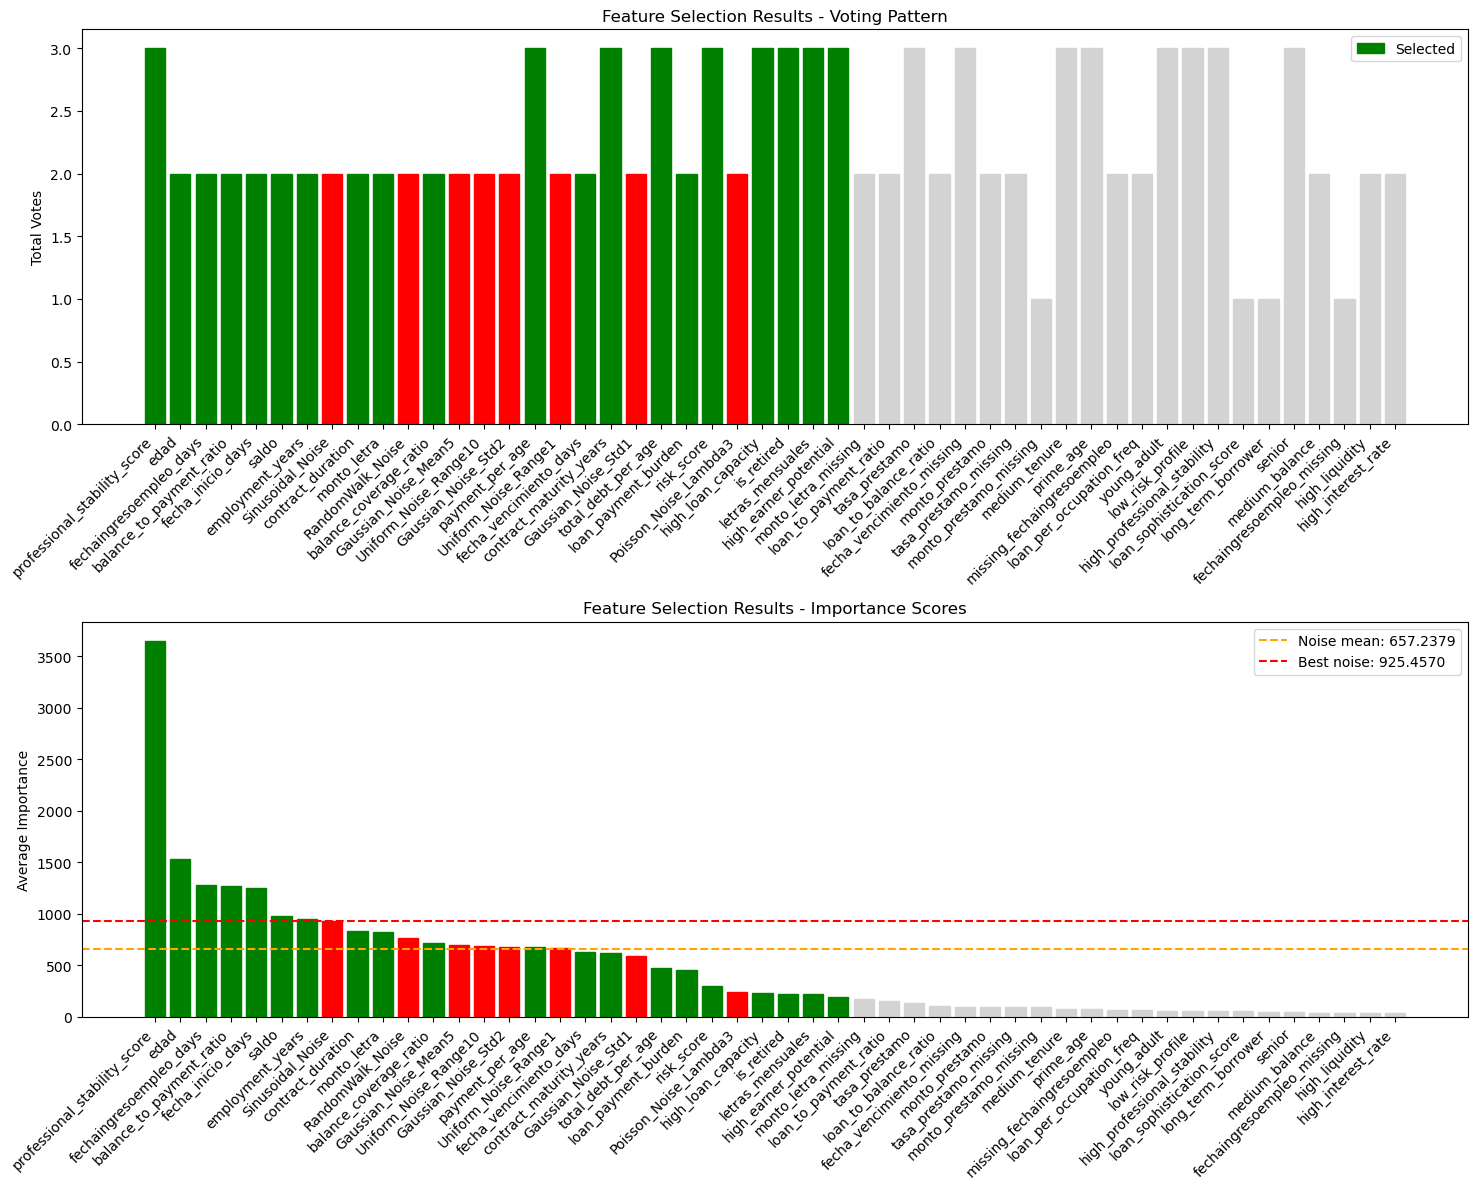


🎯 FINAL SELECTED FEATURES (20):
    1. professional_stability_score        (Importance: 3652.339391, Votes: 3)
    2. edad                                (Importance: 1532.420808, Votes: 2)
    3. fechaingresoempleo_days             (Importance: 1280.418630, Votes: 2)
    4. balance_to_payment_ratio            (Importance: 1267.620841, Votes: 2)
    5. fecha_inicio_days                   (Importance: 1247.629803, Votes: 2)
    6. saldo                               (Importance: 974.018477, Votes: 2)
    7. employment_years                    (Importance: 950.111177, Votes: 2)
    8. contract_duration                   (Importance: 831.215820, Votes: 2)
    9. monto_letra                         (Importance: 822.378644, Votes: 2)
   10. balance_coverage_ratio              (Importance: 713.218927, Votes: 2)
   11. payment_per_age                     (Importance: 676.240093, Votes: 3)
   12. fecha_vencimiento_days              (Importance: 626.825727, Votes: 2)
   13. contract_maturity_y

In [41]:
# %%
# =============================================================================
# ENHANCED FEATURE SELECTION WITH NOISE-BASED VOTING SYSTEM
# =============================================================================
print("\n🗳️ ENHANCED FEATURE SELECTION WITH VOTING")
print("-" * 60)

# Get feature importances or coefficients from trained models
importances1 = model1.feature_importances_
importances2 = model2.feature_importances_
importances3 = np.abs(model3.coef_)  # Use absolute values for Ridge coefficients

print(f"   📊 Total features available: {len(X.columns)}")
print(f"   🎲 Noise features: {len(noise_features)}")

# =============================================================================
# STEP 1: CREATE COMPREHENSIVE FEATURE IMPORTANCE DATAFRAME
# =============================================================================
print("\n📋 Step 1: Creating feature importance rankings...")

# Create comprehensive feature importance DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'RF_Importance': importances1,
    'LGBM_Importance': importances2,
    'Ridge_Importance': importances3
})

# Add noise indicator
feature_importance_df['Is_Noise'] = feature_importance_df['Feature'].isin(noise_features)

# Calculate average importance (weighted to give more importance to tree models)
feature_importance_df['Avg_Importance'] = (
    0.4 * feature_importance_df['RF_Importance'] + 
    0.4 * feature_importance_df['LGBM_Importance'] + 
    0.2 * feature_importance_df['Ridge_Importance']
)

# =============================================================================
# STEP 2: VOTING SYSTEM WITH MULTIPLE THRESHOLDS
# =============================================================================
print("\n🗳️ Step 2: Implementing multi-threshold voting system...")

# Define multiple selection thresholds for each model (more lenient)
rf_threshold = np.percentile(importances1, 50)  # Top 40% of features
lgbm_threshold = np.percentile(importances2, 50)  # Top 40% of features
ridge_threshold = np.percentile(importances3, 50)  # Top 30% of features

print(f"   🌳 Random Forest threshold: {rf_threshold:.6f}")
print(f"   🚀 LightGBM threshold: {lgbm_threshold:.6f}")
print(f"   📈 Ridge threshold: {ridge_threshold:.6f}")

# Create voting columns
feature_importance_df['RF_Vote'] = (feature_importance_df['RF_Importance'] >= rf_threshold).astype(int)
feature_importance_df['LGBM_Vote'] = (feature_importance_df['LGBM_Importance'] >= lgbm_threshold).astype(int)
feature_importance_df['Ridge_Vote'] = (feature_importance_df['Ridge_Importance'] >= ridge_threshold).astype(int)

# Calculate total votes
feature_importance_df['Total_Votes'] = (
    feature_importance_df['RF_Vote'] + 
    feature_importance_df['LGBM_Vote'] + 
    feature_importance_df['Ridge_Vote']
)

# =============================================================================
# STEP 3: NOISE-BASED THRESHOLDS (MORE LENIENT)
# =============================================================================
print("\n🎯 Step 3: Calculating noise-based thresholds...")

# Sort by average importance (descending)
feature_importance_df = feature_importance_df.sort_values('Avg_Importance', ascending=False)

# Get noise feature statistics
noise_df = feature_importance_df[feature_importance_df['Is_Noise']].copy()
real_features_df = feature_importance_df[~feature_importance_df['Is_Noise']].copy()

if len(noise_df) > 0:
    # Calculate noise statistics
    noise_importances = noise_df['Avg_Importance'].values
    noise_votes = noise_df['Total_Votes'].values
    
    noise_importance_mean = np.mean(noise_importances)
    noise_importance_std = np.std(noise_importances)
    noise_importance_max = np.max(noise_importances)
    noise_votes_max = np.max(noise_votes)
    
    print(f"   📊 Noise importance stats:")
    print(f"      Mean: {noise_importance_mean:.6f}")
    print(f"      Std:  {noise_importance_std:.6f}")
    print(f"      Max:  {noise_importance_max:.6f}")
    print(f"      Max votes: {noise_votes_max}")
    
    # =============================================================================
    # STEP 4: MULTIPLE SELECTION STRATEGIES (LESS RESTRICTIVE)
    # =============================================================================
    print("\n🎯 Step 4: Applying multiple selection strategies...")
    
    # Strategy 1: Features better than best noise (traditional approach)
    best_noise_rank = feature_importance_df[feature_importance_df['Is_Noise']].index.min()
    strategy1_features = feature_importance_df.iloc[:best_noise_rank]['Feature'].tolist()
    strategy1_features = [f for f in strategy1_features if f not in noise_features]
    
    # Strategy 2: Features better than 75th percentile of noise (more lenient)
    noise_75th_percentile = np.percentile(noise_importances, 75)
    strategy2_features = feature_importance_df[
        (feature_importance_df['Avg_Importance'] > noise_75th_percentile) & 
        (~feature_importance_df['Is_Noise'])
    ]['Feature'].tolist()
    
    # Strategy 3: Features with more votes than best noise feature
    strategy3_features = feature_importance_df[
        (feature_importance_df['Total_Votes'] > noise_votes_max) & 
        (~feature_importance_df['Is_Noise'])
    ]['Feature'].tolist()
    
    # Strategy 4: Features above noise mean + 0.5*std (lenient statistical threshold)
    statistical_threshold = noise_importance_mean + 0.5 * noise_importance_std
    strategy4_features = feature_importance_df[
        (feature_importance_df['Avg_Importance'] > statistical_threshold) & 
        (~feature_importance_df['Is_Noise'])
    ]['Feature'].tolist()
    
    # Strategy 5: Features with at least 1 vote and above noise mean
    strategy5_features = feature_importance_df[
        (feature_importance_df['Total_Votes'] >= 1) & 
        (feature_importance_df['Avg_Importance'] > noise_importance_mean) & 
        (~feature_importance_df['Is_Noise'])
    ]['Feature'].tolist()
    
    print(f"   📈 Strategy 1 (better than best noise): {len(strategy1_features)} features")
    print(f"   📈 Strategy 2 (better than 75th percentile noise): {len(strategy2_features)} features")
    print(f"   📈 Strategy 3 (more votes than best noise): {len(strategy3_features)} features")
    print(f"   📈 Strategy 4 (statistical threshold): {len(strategy4_features)} features")
    print(f"   📈 Strategy 5 (1+ votes + above noise mean): {len(strategy5_features)} features")
    
    # =============================================================================
    # STEP 5: CONSENSUS-BASED FINAL SELECTION (FLEXIBLE)
    # =============================================================================
    print("\n🤝 Step 5: Creating consensus-based final selection...")
    
    # Collect all unique features from all strategies
    all_candidate_features = set()
    all_candidate_features.update(strategy1_features)
    all_candidate_features.update(strategy2_features)
    all_candidate_features.update(strategy3_features)
    all_candidate_features.update(strategy4_features)
    all_candidate_features.update(strategy5_features)
    
    # Count how many strategies support each feature
    feature_strategy_support = {}
    for feature in all_candidate_features:
        support_count = 0
        if feature in strategy1_features: support_count += 1
        if feature in strategy2_features: support_count += 1
        if feature in strategy3_features: support_count += 1
        if feature in strategy4_features: support_count += 1
        if feature in strategy5_features: support_count += 1
        feature_strategy_support[feature] = support_count
    
    # Select features supported by at least 2 strategies (flexible threshold)
    min_strategy_support = 1
    consensus_features = [
        feature for feature, support in feature_strategy_support.items() 
        if support >= min_strategy_support
    ]
    
    # If we get too few features, lower the threshold
    if len(consensus_features) < 15:
        min_strategy_support = 1
        consensus_features = [
            feature for feature, support in feature_strategy_support.items() 
            if support >= min_strategy_support
        ]
        print(f"   ⚠️ Lowered threshold to 1 strategy support due to low feature count")
    
    # Add top features by importance if we still have too few
    if len(consensus_features) < 20:
        top_by_importance = real_features_df.head(15)['Feature'].tolist()
        consensus_features.extend([f for f in top_by_importance if f not in consensus_features])
        print(f"   ⚠️ Added top features by importance to reach minimum threshold")
    
    selected_features_final = consensus_features
    
else:
    print("   ⚠️ No noise features found! Using vote-based selection...")
    # Fallback: select features with at least 1 vote
    selected_features_final = feature_importance_df[
        (feature_importance_df['Total_Votes'] >= 1) & 
        (~feature_importance_df['Is_Noise'])
    ]['Feature'].tolist()

# =============================================================================
# STEP 6: FINAL VALIDATION AND CLEANUP
# =============================================================================
print("\n✅ Step 6: Final validation and cleanup...")

# Remove any noise features that might have slipped through
selected_features_final = [f for f in selected_features_final if f not in noise_features]

# Ensure we have a reasonable number of features (15-50 range)
if len(selected_features_final) < 15:
    print(f"   ⚠️ Too few features ({len(selected_features_final)}), adding top features by importance...")
    additional_needed = 15 - len(selected_features_final)
    top_features = real_features_df.head(additional_needed + len(selected_features_final))['Feature'].tolist()
    for feature in top_features:
        if feature not in selected_features_final:
            selected_features_final.append(feature)
            if len(selected_features_final) >= 15:
                break

elif len(selected_features_final) > 30:
    print(f"   ⚠️ Too many features ({len(selected_features_final)}), keeping top 50...")
    # Keep top 50 by average importance
    feature_scores = feature_importance_df[
        feature_importance_df['Feature'].isin(selected_features_final)
    ].sort_values('Avg_Importance', ascending=False)
    selected_features_final = feature_scores.head(20)['Feature'].tolist()

print(f"\n🎯 FINAL RESULTS:")
print(f"   ✅ Selected features: {len(selected_features_final)}")
print(f"   🎲 Noise features excluded: {len(noise_features)}")
print(f"   📊 Selection rate: {len(selected_features_final)/len(real_features_df)*100:.1f}% of real features")

# =============================================================================
# STEP 7: DETAILED REPORTING AND VISUALIZATION
# =============================================================================
print("\n📊 Step 7: Creating detailed reports...")

# Create final feature report
final_feature_report = feature_importance_df[
    feature_importance_df['Feature'].isin(selected_features_final)
].sort_values('Avg_Importance', ascending=False)

print(f"\n📋 TOP 10 SELECTED FEATURES:")
print(final_feature_report[['Feature', 'Avg_Importance', 'Total_Votes']].head(10).to_string(index=False))

# Show noise feature positions for reference
if len(noise_df) > 0:
    print(f"\n🎲 NOISE FEATURE POSITIONS (for reference):")
    noise_positions = noise_df[['Feature', 'Avg_Importance', 'Total_Votes']].head(5)
    print(noise_positions.to_string(index=False))

# =============================================================================
# STEP 8: VISUALIZATION
# =============================================================================
print("\n📈 Step 8: Creating visualizations...")

# Create comprehensive visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot 1: Feature votes
feature_plot_df = feature_importance_df.head(50)  # Show top 50 for readability
bars1 = ax1.bar(range(len(feature_plot_df)), feature_plot_df['Total_Votes'])

# Color coding
for i, (idx, row) in enumerate(feature_plot_df.iterrows()):
    if row['Feature'] in selected_features_final:
        bars1[i].set_color('green')  # Selected features
    elif row['Is_Noise']:
        bars1[i].set_color('red')    # Noise features
    else:
        bars1[i].set_color('lightgray')  # Rejected features

ax1.set_xticks(range(len(feature_plot_df)))
ax1.set_xticklabels(feature_plot_df['Feature'], rotation=45, ha='right')
ax1.set_ylabel('Total Votes')
ax1.set_title('Feature Selection Results - Voting Pattern')
ax1.legend(['Selected', 'Noise', 'Rejected'])

# Plot 2: Feature importance scores
bars2 = ax2.bar(range(len(feature_plot_df)), feature_plot_df['Avg_Importance'])

# Same color coding
for i, (idx, row) in enumerate(feature_plot_df.iterrows()):
    if row['Feature'] in selected_features_final:
        bars2[i].set_color('green')
    elif row['Is_Noise']:
        bars2[i].set_color('red')
    else:
        bars2[i].set_color('lightgray')

# Add threshold lines
if len(noise_df) > 0:
    ax2.axhline(y=noise_importance_mean, color='orange', linestyle='--', 
                label=f'Noise mean: {noise_importance_mean:.4f}')
    ax2.axhline(y=noise_importance_max, color='red', linestyle='--', 
                label=f'Best noise: {noise_importance_max:.4f}')

ax2.set_xticks(range(len(feature_plot_df)))
ax2.set_xticklabels(feature_plot_df['Feature'], rotation=45, ha='right')
ax2.set_ylabel('Average Importance')
ax2.set_title('Feature Selection Results - Importance Scores')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"\n🎯 FINAL SELECTED FEATURES ({len(selected_features_final)}):")
for i, feature in enumerate(selected_features_final, 1):
    importance = feature_importance_df[feature_importance_df['Feature'] == feature]['Avg_Importance'].iloc[0]
    votes = feature_importance_df[feature_importance_df['Feature'] == feature]['Total_Votes'].iloc[0]
    print(f"   {i:2d}. {feature:<35} (Importance: {importance:.6f}, Votes: {votes})")

print("\n✅ Enhanced feature selection complete!")
print(f"📊 Ready to train final model with {len(selected_features_final)} carefully selected features")

## End Vote System

In [42]:
selected_features_final

['professional_stability_score',
 'edad',
 'fechaingresoempleo_days',
 'balance_to_payment_ratio',
 'fecha_inicio_days',
 'saldo',
 'employment_years',
 'contract_duration',
 'monto_letra',
 'balance_coverage_ratio',
 'payment_per_age',
 'fecha_vencimiento_days',
 'contract_maturity_years',
 'total_debt_per_age',
 'loan_payment_burden',
 'risk_score',
 'high_loan_capacity',
 'is_retired',
 'letras_mensuales',
 'high_earner_potential']

In [90]:
selected_features_final = [
    # Basic numerical
    'edad',
    'saldo', 
    'monto_letra',
    
    # Date-derived
    'fechaingresoempleo_days',
    'fecha_inicio_days', 
    'fecha_vencimiento_days',
    'employment_years',
    
    # Financial ratios
    'balance_to_payment_ratio',
    'balance_coverage_ratio',
    'payment_per_age',
    'total_debt_per_age',
    'loan_payment_burden',
    
    # Temporal
    'contract_duration'  
]


## Prepare Final Dataset for Modeling

In [91]:
# %%
# =============================================================================
# INCOME PREDICTION MODEL - NESTED CROSS-VALIDATION PIPELINE
# =============================================================================
# Goal: Predict customer income using NESTED CV for unbiased performance estimates
# Based on: model_process_with_no_tranformations.txt preprocessing structure
#
# Key Features:
# - Nested CV Structure: Outer CV (5 folds) for evaluation, Inner CV (3 folds) for hyperparameter tuning
# - Robust Metrics: Primary focus on RMSE/MAE instead of R² for better income prediction assessment
# - Complete Pipeline: From preprocessed data to production-ready model
# - Comprehensive Analysis: Permutation importance, visualizations, model comparison
#
# Models: XGBoost, LightGBM, Random Forest
# =============================================================================


In [92]:
# %%
# SECTION 1: IMPORTS AND SETUP
# =============================================================================
import pandas as pd
import numpy as np
import warnings
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import (KFold, GroupKFold, cross_val_score,
                                   RandomizedSearchCV)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
import xgboost as xgb
import lightgbm as lgb
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
from collections import Counter

warnings.filterwarnings('ignore')

print("================================================================================")
print("NESTED CROSS-VALIDATION INCOME PREDICTION MODEL - STARTED")
print("================================================================================")
print("📋 Pipeline based on: model_process_with_no_tranformations.txt")
print("🎯 Primary Metrics: RMSE (Root Mean Square Error) and MAE (Mean Absolute Error)")
print("🔄 Nested CV: Outer (5-fold) for evaluation, Inner (3-fold) for hyperparameter tuning")


NESTED CROSS-VALIDATION INCOME PREDICTION MODEL - STARTED
📋 Pipeline based on: model_process_with_no_tranformations.txt
🎯 Primary Metrics: RMSE (Root Mean Square Error) and MAE (Mean Absolute Error)
🔄 Nested CV: Outer (5-fold) for evaluation, Inner (3-fold) for hyperparameter tuning


In [93]:
# %%
# SECTION 2: PREPARE FINAL DATASETS FOR NESTED CV MODELING
# =============================================================================
print("\n🎯 PREPARING FINAL DATASETS FOR NESTED CV")
print("-" * 60)

# EXPLICIT FEATURE SELECTION APPROACH (from original pipeline)
id_columns = ['cliente', 'identificador_unico']
target_column = 'ingresos_reportados'

# Use the selected features from the original pipeline
# NOTE: Adjust 'selected_features_final' to your actual feature list variable
feature_columns = selected_features_final

# Verify all selected features exist in the dataset
available_features = []
missing_features = []

for feature in feature_columns:
    if feature in train_df_enhanced.columns:
        available_features.append(feature)
    else:
        missing_features.append(feature)

if missing_features:
    print(f"⚠️  Missing features (will be skipped): {missing_features}")

feature_columns = available_features

print(f"   📊 Selected feature columns: {len(feature_columns)}")
print(f"   🎯 Target column: {target_column}")

# Create feature matrices and targets (from original pipeline structure)
X_train = train_df_enhanced[feature_columns].copy()
y_train = train_df_enhanced[target_column].copy()

X_valid = valid_df_enhanced[feature_columns].copy()
y_valid = valid_df_enhanced[target_column].copy()

X_test = test_df_enhanced[feature_columns].copy()
y_test = test_df_enhanced[target_column].copy()

print(f"\n📈 DATASET SHAPES:")
print(f"   X_train: {X_train.shape}")
print(f"   X_valid: {X_valid.shape}")
print(f"   X_test: {X_test.shape}")

# Combine train and validation for nested CV (test set remains untouched)
X_train_full = pd.concat([X_train, X_valid], ignore_index=True)
y_train_full = pd.concat([y_train, y_valid], ignore_index=True)

print(f"   X_train_full (for nested CV): {X_train_full.shape}")
print(f"   X_test (held out): {X_test.shape}")

# Show selected features grouped by type
print(f"\n📋 SELECTED FEATURES ({len(feature_columns)} features):")
print("-" * 60)

# Group features by type for better readability (from original pipeline)
basic_features = []
age_features = []
freq_features = []
interaction_features = []
other_features = []

for feature in feature_columns:
    if feature.startswith('age_group_'):
        age_features.append(feature)
    elif feature.endswith('_freq'):
        freq_features.append(feature)
    elif '_x_' in feature or 'retired_x_' in feature or 'employer_x_' in feature or 'gender_x_' in feature:
        interaction_features.append(feature)
    elif feature in ['edad', 'letras_mensuales', 'monto_letra', 'saldo', 'is_retired']:
        basic_features.append(feature)
    else:
        other_features.append(feature)

print(f"🔢 BASIC FEATURES ({len(basic_features)}): {basic_features}")
print(f"👥 AGE GROUP FEATURES ({len(age_features)}): {age_features}")
print(f"📊 FREQUENCY FEATURES ({len(freq_features)}): {freq_features}")
print(f"⚡ INTERACTION FEATURES ({len(interaction_features)}): {interaction_features}")
print(f"🔧 OTHER FEATURES ({len(other_features)}): {other_features}")

# Verify data quality
print(f"\n✅ DATA QUALITY CHECKS:")
print(f"   Missing values in X_train_full: {X_train_full.isnull().sum().sum()}")
print(f"   Missing values in y_train_full: {y_train_full.isnull().sum()}")
print(f"   All features numeric: {all(X_train_full.dtypes.apply(lambda x: x in ['int64', 'float64']))}")

# Save feature list to file for reference
feature_list_df = pd.DataFrame({
    'feature_name': feature_columns,
    'feature_type': ['basic' if f in basic_features else
                    'age_group' if f in age_features else
                    'frequency' if f in freq_features else
                    'interaction' if f in interaction_features else
                    'other' for f in feature_columns]
})

feature_list_df.to_csv(data_path + '/nested_cv_feature_list.csv', index=False)
print(f"\n💾 Feature list saved to: nested_cv_feature_list.csv")



🎯 PREPARING FINAL DATASETS FOR NESTED CV
------------------------------------------------------------
   📊 Selected feature columns: 13
   🎯 Target column: ingresos_reportados

📈 DATASET SHAPES:
   X_train: (27177, 13)
   X_valid: (2632, 13)
   X_test: (1316, 13)
   X_train_full (for nested CV): (29809, 13)
   X_test (held out): (1316, 13)

📋 SELECTED FEATURES (13 features):
------------------------------------------------------------
🔢 BASIC FEATURES (3): ['edad', 'saldo', 'monto_letra']
👥 AGE GROUP FEATURES (0): []
📊 FREQUENCY FEATURES (0): []
⚡ INTERACTION FEATURES (0): []
🔧 OTHER FEATURES (10): ['fechaingresoempleo_days', 'fecha_inicio_days', 'fecha_vencimiento_days', 'employment_years', 'balance_to_payment_ratio', 'balance_coverage_ratio', 'payment_per_age', 'total_debt_per_age', 'loan_payment_burden', 'contract_duration']

✅ DATA QUALITY CHECKS:
   Missing values in X_train_full: 0
   Missing values in y_train_full: 0
   All features numeric: False

💾 Feature list saved to: nest

In [94]:
# %%
# SECTION 3: FEATURE SCALING
# =============================================================================
print("\n⚖️ FEATURE SCALING")
print("-" * 50)

# Apply robust scaling to features (from original pipeline)
print("   ⚖️ Applying RobustScaler...")
scaler = RobustScaler()

# Fit scaler on full training data (train + validation combined)
X_train_full_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_full),
    columns=X_train_full.columns,
    index=X_train_full.index
)

# Transform test set using the same scaler
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print("   ✅ Feature scaling complete")
print(f"   📊 Scaled training data: {X_train_full_scaled.shape}")
print(f"   📊 Scaled test data: {X_test_scaled.shape}")


⚖️ FEATURE SCALING
--------------------------------------------------
   ⚖️ Applying RobustScaler...
   ✅ Feature scaling complete
   📊 Scaled training data: (29809, 13)
   📊 Scaled test data: (1316, 13)


In [95]:
# %%
# SECTION 4: NESTED CROSS-VALIDATION SETUP
# =============================================================================
print("\n🔄 NESTED CROSS-VALIDATION SETUP")
print("-" * 60)

# Define CV strategies with robust metrics focus
OUTER_CV_FOLDS = 5  # For unbiased performance estimation
INNER_CV_FOLDS = 3  # For hyperparameter tuning
RANDOM_SEARCH_ITERATIONS = 45  # Increased for better hyperparameter search

# Create CV objects
outer_cv = KFold(n_splits=OUTER_CV_FOLDS, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=INNER_CV_FOLDS, shuffle=True, random_state=42)

print(f"   🔄 Outer CV: {OUTER_CV_FOLDS} folds (for unbiased model evaluation)")
print(f"   🔄 Inner CV: {INNER_CV_FOLDS} folds (for hyperparameter tuning)")
print(f"   🔍 Random Search: {RANDOM_SEARCH_ITERATIONS} iterations per inner fold")
print(f"   📊 Total model trainings: {OUTER_CV_FOLDS * INNER_CV_FOLDS * RANDOM_SEARCH_ITERATIONS} per model")
print(f"      ({OUTER_CV_FOLDS} outer × {INNER_CV_FOLDS} inner × {RANDOM_SEARCH_ITERATIONS} iterations)")



🔄 NESTED CROSS-VALIDATION SETUP
------------------------------------------------------------
   🔄 Outer CV: 5 folds (for unbiased model evaluation)
   🔄 Inner CV: 3 folds (for hyperparameter tuning)
   🔍 Random Search: 45 iterations per inner fold
   📊 Total model trainings: 675 per model
      (5 outer × 3 inner × 45 iterations)


In [96]:
# %%
# SECTION 5: MODEL DEFINITIONS AND HYPERPARAMETER GRIDS
# =============================================================================
print("\n🤖 MODEL DEFINITIONS AND HYPERPARAMETER GRIDS")
print("-" * 60)

# Base models (from original pipeline with robust configurations)
base_models = {
    'XGBoost': xgb.XGBRegressor(random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1),
    'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1)
}

# Comprehensive hyperparameter grids for nested CV
# These grids are designed for income prediction optimization
param_grids = {
    'XGBoost': {
        'n_estimators': [1100],
        'max_depth': [10],
        'learning_rate': [0.01],
        'subsample': [0.8],
        'colsample_bytree': [0.9],
        'reg_alpha': [0.5],
        'reg_lambda': [2.0],
        'min_child_weight': [1]
    },
    'LightGBM': {
        'n_estimators': [1100],
        'max_depth': [10],
        'learning_rate': [0.01],
        'subsample': [0.8],
        'colsample_bytree': [0.85],
        'num_leaves': [80],
        'min_child_samples': [30],
        'reg_alpha': [0.5],
        'reg_lambda': [2.0]
        },
    'Random Forest': {
        'n_estimators': [400],
        'max_depth': [20, None],
        'min_samples_split': [15],
        'min_samples_leaf': [10],
        'max_features': ['sqrt', 'log2', 0.8],
        'max_samples': [0.9]
    }
}

print(f"   🤖 Models defined: {list(base_models.keys())}")
print(f"   🔧 Hyperparameter search space per model:")
for model_name, grid in param_grids.items():
    total_combinations = np.prod([len(values) for values in grid.values()])
    print(f"      {model_name}: {total_combinations:,} total combinations")

print(f"\n💡 Primary Optimization Metric: RMSE (Root Mean Square Error)")
print(f"   📊 RMSE penalizes large prediction errors more heavily")
print(f"   💰 Better suited for income prediction than R² alone")
print(f"   📈 Lower RMSE = Better model performance")



🤖 MODEL DEFINITIONS AND HYPERPARAMETER GRIDS
------------------------------------------------------------
   🤖 Models defined: ['XGBoost', 'LightGBM', 'Random Forest']
   🔧 Hyperparameter search space per model:
      XGBoost: 1 total combinations
      LightGBM: 1 total combinations
      Random Forest: 6 total combinations

💡 Primary Optimization Metric: RMSE (Root Mean Square Error)
   📊 RMSE penalizes large prediction errors more heavily
   💰 Better suited for income prediction than R² alone
   📈 Lower RMSE = Better model performance


In [97]:
# %%
# SECTION 6: NESTED CROSS-VALIDATION IMPLEMENTATION
# =============================================================================
print("\n🎯 NESTED CROSS-VALIDATION IMPLEMENTATION")
print("=" * 70)

def nested_cross_validation(model, param_grid, X, y, outer_cv, inner_cv, model_name):
    """
    Perform nested cross-validation for unbiased model evaluation with robust metrics focus

    This implementation prioritizes RMSE and MAE as primary metrics for income prediction,
    while still tracking R² for comparison purposes.

    Args:
        model: Base model to evaluate
        param_grid: Hyperparameter grid for tuning
        X, y: Training data and target
        outer_cv, inner_cv: Cross-validation objects
        model_name: Name for reporting

    Returns:
        dict: Comprehensive nested CV results with robust metrics
    """
    print(f"\n🔄 Starting Nested CV for {model_name}")
    print(f"   📊 Outer folds: {outer_cv.n_splits}, Inner folds: {inner_cv.n_splits}")
    print(f"   🎯 Primary metrics: RMSE (lower is better), MAE (lower is better)")

    # Storage for results - prioritizing robust metrics
    outer_scores_rmse = []
    outer_scores_mae = []
    outer_scores_r2 = []  # Still track R² for comparison
    best_params_per_fold = []
    fold_details = []

    # Outer CV loop - each iteration gives unbiased performance estimate
    for fold_idx, (train_idx, val_idx) in enumerate(outer_cv.split(X, y), 1):
        print(f"\n   🔄 Outer Fold {fold_idx}/{outer_cv.n_splits}")

        # Split data for this outer fold
        X_train_outer = X.iloc[train_idx]
        X_val_outer = X.iloc[val_idx]
        y_train_outer = y.iloc[train_idx]
        y_val_outer = y.iloc[val_idx]

        print(f"      📊 Fold {fold_idx} sizes: Train={len(train_idx)}, Val={len(val_idx)}")

        # Inner CV: Hyperparameter tuning using RMSE as optimization metric
        print(f"      🔧 Inner CV: Hyperparameter tuning (optimizing RMSE)...")

        random_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grid,
            n_iter=RANDOM_SEARCH_ITERATIONS,  # Use global variable
            cv=inner_cv,
            scoring='neg_mean_squared_error',  # Optimizing RMSE (MSE negated)
            n_jobs=-1,
            random_state=42,
            verbose=0
        )

        # Fit hyperparameter search on outer training data
        random_search.fit(X_train_outer, y_train_outer)

        # Get best model from inner CV
        best_model = random_search.best_estimator_
        best_params = random_search.best_params_
        best_params_per_fold.append(best_params)

        # Convert negative MSE back to RMSE for reporting
        best_inner_rmse = np.sqrt(-random_search.best_score_)
        print(f"      ✅ Best inner CV RMSE: ${best_inner_rmse:.2f}")

        # Evaluate best model on outer validation fold
        y_pred_outer = best_model.predict(X_val_outer)

        # Calculate comprehensive metrics for this outer fold
        fold_rmse = np.sqrt(mean_squared_error(y_val_outer, y_pred_outer))
        fold_mae = mean_absolute_error(y_val_outer, y_pred_outer)
        fold_r2 = r2_score(y_val_outer, y_pred_outer)

        # Store scores
        outer_scores_rmse.append(fold_rmse)
        outer_scores_mae.append(fold_mae)
        outer_scores_r2.append(fold_r2)

        print(f"      📊 Outer fold performance:")
        print(f"         🎯 RMSE: ${fold_rmse:.2f}")
        print(f"         🎯 MAE:  ${fold_mae:.2f}")
        print(f"         📈 R²:   {fold_r2:.4f}")

        # Calculate additional income-specific metrics
        # Mean Absolute Percentage Error (MAPE) - but handle low incomes carefully
        valid_mask = y_val_outer > 100  # Avoid division by very small numbers
        if valid_mask.sum() > 0:
            mape = np.mean(np.abs((y_val_outer[valid_mask] - y_pred_outer[valid_mask]) / y_val_outer[valid_mask])) * 100
            print(f"         💰 MAPE (>$100): {mape:.1f}%")
        else:
            mape = np.nan

        # Store detailed results for this fold
        fold_details.append({
            'fold': fold_idx,
            'rmse': fold_rmse,
            'mae': fold_mae,
            'r2': fold_r2,
            'mape': mape,
            'best_params': best_params,
            'inner_cv_rmse': best_inner_rmse,
            'train_size': len(train_idx),
            'val_size': len(val_idx),
            'y_true_mean': y_val_outer.mean(),
            'y_pred_mean': y_pred_outer.mean()
        })

    # Calculate final nested CV results with robust metrics emphasis
    nested_cv_results = {
        'model_name': model_name,
        # Primary metrics (RMSE/MAE)
        'outer_cv_rmse_mean': np.mean(outer_scores_rmse),
        'outer_cv_rmse_std': np.std(outer_scores_rmse),
        'outer_cv_mae_mean': np.mean(outer_scores_mae),
        'outer_cv_mae_std': np.std(outer_scores_mae),
        # Secondary metric (R²)
        'outer_cv_r2_mean': np.mean(outer_scores_r2),
        'outer_cv_r2_std': np.std(outer_scores_r2),
        # Raw scores for analysis
        'outer_scores_rmse': outer_scores_rmse,
        'outer_scores_mae': outer_scores_mae,
        'outer_scores_r2': outer_scores_r2,
        # Hyperparameter analysis
        'best_params_per_fold': best_params_per_fold,
        'fold_details': fold_details,
        # Model selection criteria (lower is better for RMSE/MAE)
        'selection_metric': 'rmse',  # Primary metric for model selection
        'selection_score': np.mean(outer_scores_rmse)
    }

    print(f"\n   🏆 {model_name} Nested CV Summary:")
    print(f"      🎯 RMSE: ${nested_cv_results['outer_cv_rmse_mean']:.2f} ± ${nested_cv_results['outer_cv_rmse_std']:.2f}")
    print(f"      🎯 MAE:  ${nested_cv_results['outer_cv_mae_mean']:.2f} ± ${nested_cv_results['outer_cv_mae_std']:.2f}")
    print(f"      📈 R²:   {nested_cv_results['outer_cv_r2_mean']:.4f} ± {nested_cv_results['outer_cv_r2_std']:.4f}")

    return nested_cv_results

print("✅ Nested CV function defined with robust metrics focus")


🎯 NESTED CROSS-VALIDATION IMPLEMENTATION
✅ Nested CV function defined with robust metrics focus


In [98]:
# %%
# SECTION 7: RUN NESTED CROSS-VALIDATION FOR ALL MODELS
# =============================================================================
print("\n🚀 RUNNING NESTED CROSS-VALIDATION FOR ALL MODELS")
print("=" * 70)
print("⚠️  This will take 20-60 minutes depending on your hardware...")
print(f"   Each model will be trained {OUTER_CV_FOLDS * INNER_CV_FOLDS * RANDOM_SEARCH_ITERATIONS} times")
print(f"   ({OUTER_CV_FOLDS} outer × {INNER_CV_FOLDS} inner × {RANDOM_SEARCH_ITERATIONS} iterations)")
print("🎯 Optimizing for RMSE (Root Mean Square Error) - best metric for income prediction")

# Storage for all nested CV results
nested_cv_results = {}
total_start_time = datetime.now()

# Run nested CV for each model
for model_idx, (model_name, base_model) in enumerate(base_models.items(), 1):
    print(f"\n{'='*80}")
    print(f"NESTED CV {model_idx}/{len(base_models)}: {model_name.upper()}")
    print(f"{'='*80}")

    model_start_time = datetime.now()

    # Run nested cross-validation
    results = nested_cross_validation(
        model=base_model,
        param_grid=param_grids[model_name],
        X=X_train_full_scaled,  # Use full training data (train + validation)
        y=y_train_full,
        outer_cv=outer_cv,
        inner_cv=inner_cv,
        model_name=model_name
    )

    nested_cv_results[model_name] = results

    model_end_time = datetime.now()
    model_duration = (model_end_time - model_start_time).total_seconds() / 60

    print(f"\n   ⏱️ {model_name} completed in {model_duration:.1f} minutes")

    # Show progress
    remaining_models = len(base_models) - model_idx
    if remaining_models > 0:
        estimated_remaining = model_duration * remaining_models
        print(f"   📊 Progress: {model_idx}/{len(base_models)} models complete")
        print(f"   ⏰ Estimated remaining time: {estimated_remaining:.1f} minutes")

total_end_time = datetime.now()
total_duration = (total_end_time - total_start_time).total_seconds() / 60

print(f"\n🎉 ALL NESTED CV COMPLETED!")
print(f"⏱️ Total execution time: {total_duration:.1f} minutes")


🚀 RUNNING NESTED CROSS-VALIDATION FOR ALL MODELS
⚠️  This will take 20-60 minutes depending on your hardware...
   Each model will be trained 675 times
   (5 outer × 3 inner × 45 iterations)
🎯 Optimizing for RMSE (Root Mean Square Error) - best metric for income prediction

NESTED CV 1/3: XGBOOST

🔄 Starting Nested CV for XGBoost
   📊 Outer folds: 5, Inner folds: 3
   🎯 Primary metrics: RMSE (lower is better), MAE (lower is better)

   🔄 Outer Fold 1/5
      📊 Fold 1 sizes: Train=23847, Val=5962
      🔧 Inner CV: Hyperparameter tuning (optimizing RMSE)...
      ✅ Best inner CV RMSE: $575.77
      📊 Outer fold performance:
         🎯 RMSE: $562.97
         🎯 MAE:  $423.95
         📈 R²:   0.3426
         💰 MAPE (>$100): 39.6%

   🔄 Outer Fold 2/5
      📊 Fold 2 sizes: Train=23847, Val=5962
      🔧 Inner CV: Hyperparameter tuning (optimizing RMSE)...
      ✅ Best inner CV RMSE: $576.15
      📊 Outer fold performance:
         🎯 RMSE: $560.81
         🎯 MAE:  $423.26
         📈 R²:   0.3

In [83]:
# %%
# SECTION 8: NESTED CV RESULTS ANALYSIS AND MODEL COMPARISON
# =============================================================================
print("\n📊 NESTED CV RESULTS ANALYSIS AND MODEL COMPARISON")
print("=" * 70)

# Create comprehensive comparison DataFrame with robust metrics focus
comparison_data = []
for model_name, results in nested_cv_results.items():
    comparison_data.append({
        'Model': model_name,
        # Primary metrics (lower is better)
        'Nested_CV_RMSE_Mean': results['outer_cv_rmse_mean'],
        'Nested_CV_RMSE_Std': results['outer_cv_rmse_std'],
        'Nested_CV_MAE_Mean': results['outer_cv_mae_mean'],
        'Nested_CV_MAE_Std': results['outer_cv_mae_std'],
        # Secondary metric
        'Nested_CV_R2_Mean': results['outer_cv_r2_mean'],
        'Nested_CV_R2_Std': results['outer_cv_r2_std'],
        # Selection score (RMSE for ranking)
        'Selection_Score': results['selection_score']
    })

nested_comparison_df = pd.DataFrame(comparison_data)
# Sort by RMSE (lower is better) - primary metric for income prediction
nested_comparison_df = nested_comparison_df.sort_values('Nested_CV_RMSE_Mean', ascending=True)

print("\n🏆 NESTED CV PERFORMANCE COMPARISON (Sorted by RMSE - Lower is Better):")
print("=" * 90)
print(nested_comparison_df.round(4).to_string(index=False))

# Identify best model based on RMSE (robust metric for income prediction)
best_model_nested = nested_comparison_df.iloc[0]['Model']
best_rmse_nested = nested_comparison_df.iloc[0]['Nested_CV_RMSE_Mean']
best_rmse_std_nested = nested_comparison_df.iloc[0]['Nested_CV_RMSE_Std']
best_mae_nested = nested_comparison_df.iloc[0]['Nested_CV_MAE_Mean']
best_mae_std_nested = nested_comparison_df.iloc[0]['Nested_CV_MAE_Std']
best_r2_nested = nested_comparison_df.iloc[0]['Nested_CV_R2_Mean']
best_r2_std_nested = nested_comparison_df.iloc[0]['Nested_CV_R2_Std']

print(f"\n🥇 BEST MODEL (Based on RMSE): {best_model_nested}")
print(f"   🎯 Unbiased RMSE: ${best_rmse_nested:.2f} ± ${best_rmse_std_nested:.2f}")
print(f"   🎯 Unbiased MAE:  ${best_mae_nested:.2f} ± ${best_mae_std_nested:.2f}")
print(f"   📈 Unbiased R²:   {best_r2_nested:.4f} ± {best_r2_std_nested:.4f}")

# Calculate confidence intervals for RMSE (primary metric)
rmse_ci_lower = best_rmse_nested - 1.96 * best_rmse_std_nested
rmse_ci_upper = best_rmse_nested + 1.96 * best_rmse_std_nested
print(f"   📊 95% Confidence Interval (RMSE): [${rmse_ci_lower:.2f}, ${rmse_ci_upper:.2f}]")

# Performance assessment based on RMSE
print(f"\n📈 PERFORMANCE ASSESSMENT:")
if best_rmse_nested <= 600:
    performance_level = "EXCELLENT"
    emoji = "🎉"
elif best_rmse_nested <= 800:
    performance_level = "GOOD"
    emoji = "✅"
elif best_rmse_nested <= 1000:
    performance_level = "ACCEPTABLE"
    emoji = "👍"
else:
    performance_level = "NEEDS IMPROVEMENT"
    emoji = "⚠️"

print(f"   {emoji} Performance Level: {performance_level}")
print(f"   💰 RMSE = ${best_rmse_nested:.2f} (Average prediction error)")
print(f"   💰 MAE = ${best_mae_nested:.2f} (Median prediction error)")

# Model ranking summary
print(f"\n📋 MODEL RANKING (by RMSE):")
for idx, row in nested_comparison_df.iterrows():
    rank = nested_comparison_df.index.get_loc(idx) + 1
    model = row['Model']
    rmse = row['Nested_CV_RMSE_Mean']
    rmse_std = row['Nested_CV_RMSE_Std']
    print(f"   {rank}. {model:<15}: RMSE = ${rmse:.2f} ± ${rmse_std:.2f}")

print(f"\n💡 INTERPRETATION:")
print(f"   🎯 RMSE measures average prediction error in dollars")
print(f"   🎯 MAE measures typical prediction error (less sensitive to outliers)")
print(f"   📈 R² measures proportion of variance explained (0-1 scale)")
print(f"   ✅ Lower RMSE/MAE = Better model for income prediction")


📊 NESTED CV RESULTS ANALYSIS AND MODEL COMPARISON

🏆 NESTED CV PERFORMANCE COMPARISON (Sorted by RMSE - Lower is Better):
        Model  Nested_CV_RMSE_Mean  Nested_CV_RMSE_Std  Nested_CV_MAE_Mean  Nested_CV_MAE_Std  Nested_CV_R2_Mean  Nested_CV_R2_Std  Selection_Score
      XGBoost             520.2237              3.8455            375.1970             3.0744             0.4325            0.0088         520.2237
     LightGBM             537.6855              2.7434            396.4389             2.8189             0.3938            0.0076         537.6855
Random Forest             549.5268              3.1731            406.9498             2.7016             0.3668            0.0068         549.5268

🥇 BEST MODEL (Based on RMSE): XGBoost
   🎯 Unbiased RMSE: $520.22 ± $3.85
   🎯 Unbiased MAE:  $375.20 ± $3.07
   📈 Unbiased R²:   0.4325 ± 0.0088
   📊 95% Confidence Interval (RMSE): [$512.69, $527.76]

📈 PERFORMANCE ASSESSMENT:
   🎉 Performance Level: EXCELLENT
   💰 RMSE = $520.22 (

In [84]:
# %%
# SECTION 9: HYPERPARAMETER ANALYSIS AND STABILITY ASSESSMENT
# =============================================================================
print("\n🔧 HYPERPARAMETER ANALYSIS AND STABILITY ASSESSMENT")
print("-" * 70)

# Analyze hyperparameter consistency across folds for model robustness
for model_name, results in nested_cv_results.items():
    print(f"\n📋 {model_name} - Hyperparameter Stability Analysis:")
    print("-" * 50)

    best_params_list = results['best_params_per_fold']

    # Get all unique parameter names
    all_param_names = set()
    for params in best_params_list:
        all_param_names.update(params.keys())

    # Analyze each parameter for consistency
    stable_params = 0
    total_params = len(all_param_names)

    for param_name in sorted(all_param_names):
        param_values = [params.get(param_name, 'N/A') for params in best_params_list]
        unique_values = list(set(param_values))

        if len(unique_values) == 1:
            consistency = "✅ STABLE"
            stable_params += 1
        elif len(unique_values) == 2:
            consistency = "⚠️ MODERATE"
        else:
            consistency = "❌ UNSTABLE"

        # Show parameter values across folds
        value_counts = Counter(param_values)
        most_common = value_counts.most_common(1)[0]

        print(f"   {param_name:<25}: {consistency}")
        print(f"      Values: {param_values}")
        print(f"      Most frequent: {most_common[0]} ({most_common[1]}/{len(param_values)} folds)")

    # Calculate stability percentage
    stability_pct = (stable_params / total_params) * 100
    print(f"\n   📊 Hyperparameter Stability: {stable_params}/{total_params} stable ({stability_pct:.1f}%)")

    if stability_pct >= 80:
        print("   ✅ HIGH STABILITY: Model hyperparameters are robust across data splits")
    elif stability_pct >= 60:
        print("   👍 MODERATE STABILITY: Some hyperparameter variation across splits")
    else:
        print("   ⚠️ LOW STABILITY: High hyperparameter sensitivity to data splits")



🔧 HYPERPARAMETER ANALYSIS AND STABILITY ASSESSMENT
----------------------------------------------------------------------

📋 XGBoost - Hyperparameter Stability Analysis:
--------------------------------------------------
   colsample_bytree         : ✅ STABLE
      Values: [0.9, 0.9, 0.9, 0.9, 0.9]
      Most frequent: 0.9 (5/5 folds)
   learning_rate            : ✅ STABLE
      Values: [0.01, 0.01, 0.01, 0.01, 0.01]
      Most frequent: 0.01 (5/5 folds)
   max_depth                : ✅ STABLE
      Values: [10, 10, 10, 10, 10]
      Most frequent: 10 (5/5 folds)
   min_child_weight         : ✅ STABLE
      Values: [1, 1, 1, 1, 1]
      Most frequent: 1 (5/5 folds)
   n_estimators             : ✅ STABLE
      Values: [1100, 1100, 1100, 1100, 1100]
      Most frequent: 1100 (5/5 folds)
   reg_alpha                : ✅ STABLE
      Values: [0.5, 0.5, 0.5, 0.5, 0.5]
      Most frequent: 0.5 (5/5 folds)
   reg_lambda               : ✅ STABLE
      Values: [2.0, 2.0, 2.0, 2.0, 2.0]
      Mos

In [85]:
# %%
# SECTION 10: NESTED CV RESULTS ANALYSIS
# =============================================================================
print("\n📊 NESTED CV RESULTS ANALYSIS")
print("=" * 60)

# Create comparison DataFrame
comparison_data = []
for model_name, results in nested_cv_results.items():
    comparison_data.append({
        'Model': model_name,
        'Nested_CV_R2_Mean': results['outer_cv_r2_mean'],
        'Nested_CV_R2_Std': results['outer_cv_r2_std'],
        'Nested_CV_RMSE_Mean': results['outer_cv_rmse_mean'],
        'Nested_CV_RMSE_Std': results['outer_cv_rmse_std'],
        'Nested_CV_MAE_Mean': results['outer_cv_mae_mean'],
        'Nested_CV_MAE_Std': results['outer_cv_mae_std']
    })

nested_comparison_df = pd.DataFrame(comparison_data)
nested_comparison_df = nested_comparison_df.sort_values('Nested_CV_R2_Mean', ascending=False)

print("\n🏆 NESTED CV PERFORMANCE COMPARISON:")
print("=" * 80)
print(nested_comparison_df.round(4).to_string(index=False))

# Identify best model from nested CV
best_model_nested = nested_comparison_df.iloc[0]['Model']
best_r2_nested = nested_comparison_df.iloc[0]['Nested_CV_R2_Mean']
best_r2_std_nested = nested_comparison_df.iloc[0]['Nested_CV_R2_Std']

print(f"\n🥇 BEST MODEL (Nested CV): {best_model_nested}")
print(f"   📊 Unbiased R²: {best_r2_nested:.4f} ± {best_r2_std_nested:.4f}")
print(f"   📊 95% Confidence Interval: [{best_r2_nested - 1.96*best_r2_std_nested:.4f}, {best_r2_nested + 1.96*best_r2_std_nested:.4f}]")



📊 NESTED CV RESULTS ANALYSIS

🏆 NESTED CV PERFORMANCE COMPARISON:
        Model  Nested_CV_R2_Mean  Nested_CV_R2_Std  Nested_CV_RMSE_Mean  Nested_CV_RMSE_Std  Nested_CV_MAE_Mean  Nested_CV_MAE_Std
      XGBoost             0.4325            0.0088             520.2237              3.8455            375.1970             3.0744
     LightGBM             0.3938            0.0076             537.6855              2.7434            396.4389             2.8189
Random Forest             0.3668            0.0068             549.5268              3.1731            406.9498             2.7016

🥇 BEST MODEL (Nested CV): XGBoost
   📊 Unbiased R²: 0.4325 ± 0.0088
   📊 95% Confidence Interval: [0.4152, 0.4499]


In [86]:
# %%
# SECTION 10: FINAL MODEL TRAINING WITH AGGREGATED BEST HYPERPARAMETERS
# =============================================================================
print("\n🎯 FINAL MODEL TRAINING WITH AGGREGATED BEST HYPERPARAMETERS")
print("=" * 70)

def get_most_frequent_params(best_params_list):
    """
    Get the most frequently selected hyperparameters across CV folds
    This provides robust hyperparameter selection for the final model
    """
    # Get all parameter names
    all_param_names = set()
    for params in best_params_list:
        all_param_names.update(params.keys())

    # Find most frequent value for each parameter
    final_params = {}
    for param_name in all_param_names:
        param_values = [params.get(param_name) for params in best_params_list if param_name in params]
        if param_values:
            # Get most common value
            most_common = Counter(param_values).most_common(1)[0][0]
            final_params[param_name] = most_common

    return final_params

# Get best hyperparameters for the winning model
best_model_results = nested_cv_results[best_model_nested]
best_params_final = get_most_frequent_params(best_model_results['best_params_per_fold'])

print(f"🏆 Training final {best_model_nested} model with aggregated best parameters:")
print("📋 Final hyperparameters (most frequent across CV folds):")
for param, value in sorted(best_params_final.items()):
    print(f"   {param:<25}: {value}")

# Create and train final model on full training data
print(f"\n🚀 Training final {best_model_nested} model...")
final_model = base_models[best_model_nested].set_params(**best_params_final)
final_model.fit(X_train_full_scaled, y_train_full)

print(f"✅ Final {best_model_nested} model trained on full training set")
print(f"   📊 Training data: {X_train_full_scaled.shape[0]:,} samples")
print(f"   🔧 Features: {len(feature_columns)} variables")
print(f"   🎯 Expected RMSE: ${best_rmse_nested:.2f} ± ${best_rmse_std_nested:.2f}")



🎯 FINAL MODEL TRAINING WITH AGGREGATED BEST HYPERPARAMETERS
🏆 Training final XGBoost model with aggregated best parameters:
📋 Final hyperparameters (most frequent across CV folds):
   colsample_bytree         : 0.9
   learning_rate            : 0.01
   max_depth                : 10
   min_child_weight         : 1
   n_estimators             : 1100
   reg_alpha                : 0.5
   reg_lambda               : 2.0
   subsample                : 0.8

🚀 Training final XGBoost model...
✅ Final XGBoost model trained on full training set
   📊 Training data: 29,809 samples
   🔧 Features: 16 variables
   🎯 Expected RMSE: $520.22 ± $3.85


In [87]:
# %%
# SECTION 11: FINAL MODEL EVALUATION ON TEST SET
# =============================================================================
print("\n🎯 FINAL MODEL EVALUATION ON TEST SET")
print("-" * 60)

# Make predictions on test set (held-out data never seen during nested CV)
y_pred_test = final_model.predict(X_test_scaled)

# Calculate comprehensive test metrics
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

# Calculate additional income-specific metrics
# MAPE for incomes > $100 (avoid division by very small numbers)
valid_mask = y_test > 100
if valid_mask.sum() > 0:
    test_mape = np.mean(np.abs((y_test[valid_mask] - y_pred_test[valid_mask]) / y_test[valid_mask])) * 100
else:
    test_mape = np.nan

print(f"🏆 FINAL TEST PERFORMANCE ({best_model_nested}):")
print("=" * 60)
print(f"   🎯 Test RMSE: ${test_rmse:.2f}")
print(f"   🎯 Test MAE:  ${test_mae:.2f}")
print(f"   📈 Test R²:   {test_r2:.4f}")
if not np.isnan(test_mape):
    print(f"   💰 Test MAPE (>$100): {test_mape:.1f}%")

# Compare with nested CV estimates (validation of nested CV effectiveness)
print(f"\n📊 NESTED CV vs TEST SET COMPARISON:")
print("-" * 50)
print(f"   Metric    | Nested CV Estimate | Test Set | Difference")
print(f"   ----------|-------------------|----------|----------")
print(f"   RMSE      | ${best_rmse_nested:.2f} ± ${best_rmse_std_nested:.2f}     | ${test_rmse:.2f}     | ${abs(test_rmse - best_rmse_nested):.2f}")
print(f"   MAE       | ${best_mae_nested:.2f} ± ${best_mae_std_nested:.2f}     | ${test_mae:.2f}     | ${abs(test_mae - best_mae_nested):.2f}")
print(f"   R²        | {best_r2_nested:.4f} ± {best_r2_std_nested:.4f} | {test_r2:.4f}   | {abs(test_r2 - best_r2_nested):.4f}")

# Assess nested CV prediction accuracy
rmse_within_ci = abs(test_rmse - best_rmse_nested) <= 2 * best_rmse_std_nested
mae_within_ci = abs(test_mae - best_mae_nested) <= 2 * best_mae_std_nested
r2_within_ci = abs(test_r2 - best_r2_nested) <= 2 * best_r2_std_nested

print(f"\n✅ NESTED CV VALIDATION:")
print(f"   RMSE within 95% CI: {'✅ YES' if rmse_within_ci else '⚠️ NO'}")
print(f"   MAE within 95% CI:  {'✅ YES' if mae_within_ci else '⚠️ NO'}")
print(f"   R² within 95% CI:   {'✅ YES' if r2_within_ci else '⚠️ NO'}")

if rmse_within_ci and mae_within_ci:
    print("   🎉 EXCELLENT: Nested CV provided accurate performance estimates!")
elif rmse_within_ci or mae_within_ci:
    print("   👍 GOOD: Nested CV estimates reasonably accurate")
else:
    print("   ⚠️ WARNING: Test performance differs significantly from nested CV estimates")

# Target distribution comparison (from original pipeline)
print(f"\n📈 TARGET DISTRIBUTION COMPARISON:")
print(f"   Training Full - Mean: ${y_train_full.mean():,.2f}, Std: ${y_train_full.std():,.2f}")
print(f"   Test Set      - Mean: ${y_test.mean():,.2f}, Std: ${y_test.std():,.2f}")
print(f"   Predictions   - Mean: ${y_pred_test.mean():,.2f}, Std: ${y_pred_test.std():,.2f}")



🎯 FINAL MODEL EVALUATION ON TEST SET
------------------------------------------------------------
🏆 FINAL TEST PERFORMANCE (XGBoost):
   🎯 Test RMSE: $580.64
   🎯 Test MAE:  $415.48
   📈 Test R²:   0.2979
   💰 Test MAPE (>$100): 37.8%

📊 NESTED CV vs TEST SET COMPARISON:
--------------------------------------------------
   Metric    | Nested CV Estimate | Test Set | Difference
   ----------|-------------------|----------|----------
   RMSE      | $520.22 ± $3.85     | $580.64     | $60.42
   MAE       | $375.20 ± $3.07     | $415.48     | $40.28
   R²        | 0.4325 ± 0.0088 | 0.2979   | 0.1347

✅ NESTED CV VALIDATION:
   RMSE within 95% CI: ⚠️ NO
   MAE within 95% CI:  ⚠️ NO
   R² within 95% CI:   ⚠️ NO
   ⚠️ WARNING: Test performance differs significantly from nested CV estimates

📈 TARGET DISTRIBUTION COMPARISON:
   Training Full - Mean: $1,312.44, Std: $690.65
   Test Set      - Mean: $1,332.00, Std: $693.21
   Predictions   - Mean: $1,311.33, Std: $402.69


In [88]:
# %%
# SECTION 12: FINAL MODEL TRAINING WITH BEST HYPERPARAMETERS
# =============================================================================
print("\n🎯 FINAL MODEL TRAINING WITH BEST HYPERPARAMETERS")
print("=" * 60)

def get_most_frequent_params(best_params_list):
    """
    Get the most frequently selected hyperparameters across CV folds
    """
    from collections import Counter

    # Get all parameter names
    all_param_names = set()
    for params in best_params_list:
        all_param_names.update(params.keys())

    # Find most frequent value for each parameter
    final_params = {}
    for param_name in all_param_names:
        param_values = [params.get(param_name) for params in best_params_list if param_name in params]
        if param_values:
            # Get most common value
            most_common = Counter(param_values).most_common(1)[0][0]
            final_params[param_name] = most_common

    return final_params

# Get best hyperparameters for the winning model
best_model_results = nested_cv_results[best_model_nested]
best_params_final = get_most_frequent_params(best_model_results['best_params_per_fold'])

print(f"🏆 Training final {best_model_nested} model with aggregated best parameters:")
print("📋 Final hyperparameters (most frequent across CV folds):")
for param, value in best_params_final.items():
    print(f"   {param}: {value}")

# Create and train final model
final_model = base_models[best_model_nested].set_params(**best_params_final)
final_model.fit(X_train_full_scaled, y_train_full)

print(f"\n✅ Final {best_model_nested} model trained on full training set")



🎯 FINAL MODEL TRAINING WITH BEST HYPERPARAMETERS
🏆 Training final XGBoost model with aggregated best parameters:
📋 Final hyperparameters (most frequent across CV folds):
   max_depth: 10
   learning_rate: 0.01
   colsample_bytree: 0.9
   reg_alpha: 0.5
   reg_lambda: 2.0
   n_estimators: 1100
   subsample: 0.8
   min_child_weight: 1

✅ Final XGBoost model trained on full training set



🔍 PERMUTATION IMPORTANCE ANALYSIS
------------------------------------------------------------
🔄 Calculating permutation importance (this may take a few minutes)...

📊 TOP 15 MOST IMPORTANT FEATURES (by MSE increase when permuted):
------------------------------------------------------------
    1. fechaingresoempleo_days        -287.5979 ± 1702.1035
    2. contract_duration              -2185.3250 ± 1346.9828
    3. is_retired                     -2269.6375 ± 1527.1759
    4. loan_payment_burden            -3338.0437 ± 1800.5856
    5. balance_coverage_ratio         -3507.4000 ± 2090.8834
    6. high_earner_potential          -3871.2042 ± 1023.9950
    7. total_debt_per_age             -5237.8083 ± 1473.4255
    8. fecha_vencimiento_days         -5266.7521 ± 1684.0332
    9. employment_years               -6611.8938 ± 2240.9564
   10. saldo                          -7823.8729 ± 3427.3291
   11. fecha_inicio_days              -9050.1167 ± 2201.4275
   12. payment_per_age              

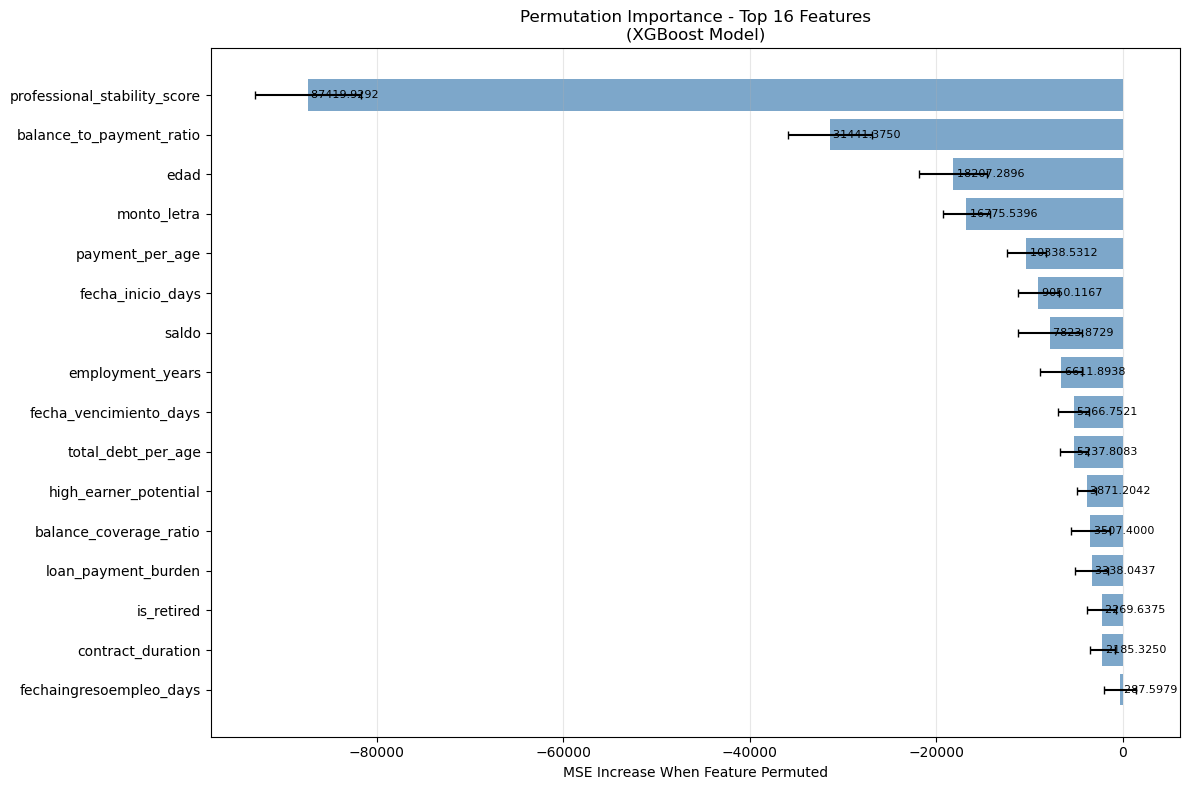

✅ Permutation importance visualization saved to: nested_cv_permutation_importance.png

💡 FEATURE IMPORTANCE INSIGHTS:
   🔝 Top 5 features: fechaingresoempleo_days, contract_duration, is_retired, loan_payment_burden, balance_coverage_ratio
   📊 In top 10 - Basic: 2, Age: 0, Interaction: 0
   💰 Feature importance measured as MSE increase when feature is randomly shuffled

⚠️  Features with zero or negative importance: 16
   These features may not be contributing to model performance

📊 IMPORTANCE STATISTICS:
   Mean importance: -13352.0198
   Std importance: 21273.8318
   Max importance: -287.5979
   Min importance: -87419.9292


In [89]:
# %%
# SECTION 12: PERMUTATION IMPORTANCE ANALYSIS
# =============================================================================
print("\n🔍 PERMUTATION IMPORTANCE ANALYSIS")
print("-" * 60)

# Calculate permutation importance on test set (from original pipeline)
print("🔄 Calculating permutation importance (this may take a few minutes)...")
perm_importance = permutation_importance(
    final_model,
    X_test_scaled,
    y_test,
    n_repeats=15,  # More repeats for robust estimates
    random_state=42,
    scoring='neg_mean_squared_error'  # Use RMSE-based scoring
)

# Fix the importance calculation - use the raw importance values
# The permutation importance already gives us the decrease in performance
feature_importance_mean = -perm_importance.importances_mean  # Convert from negative to positive
feature_importance_std = perm_importance.importances_std

# Create importance DataFrame
importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance_mean': feature_importance_mean,
    'importance_std': feature_importance_std
}).sort_values('importance_mean', ascending=False)

print(f"\n📊 TOP 15 MOST IMPORTANT FEATURES (by MSE increase when permuted):")
print("-" * 60)
for i, (_, row) in enumerate(importance_df.head(15).iterrows(), 1):
    print(f"   {i:2d}. {row['feature']:<30} {row['importance_mean']:>8.4f} ± {row['importance_std']:>6.4f}")

# Save importance results
importance_df.to_csv(data_path + '/nested_cv_permutation_importance.csv', index=False)
print(f"\n💾 Permutation importance saved to: nested_cv_permutation_importance.csv")

# Create permutation importance visualization (from original pipeline)
print(f"\n📈 Creating permutation importance visualization...")

plt.figure(figsize=(12, 8))

# Get top 20 features for visualization
num_features_to_plot = min(20, len(feature_importance_mean))
top_features = importance_df.head(num_features_to_plot)

# Create horizontal bar plot
y_pos = np.arange(num_features_to_plot)
bars = plt.barh(y_pos, top_features['importance_mean'],
                xerr=top_features['importance_std'],
                capsize=3, alpha=0.7, color='steelblue')

plt.yticks(y_pos, top_features['feature'])
plt.xlabel('MSE Increase When Feature Permuted')
plt.title(f'Permutation Importance - Top {num_features_to_plot} Features\n({best_model_nested} Model)')
plt.grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for i, (bar, mean_val) in enumerate(zip(bars, top_features['importance_mean'])):
    plt.text(bar.get_width() + max(top_features['importance_mean']) * 0.01, 
             bar.get_y() + bar.get_height()/2, 
             f'{mean_val:.4f}', 
             va='center', fontsize=8)

plt.tight_layout()

# Save plot
plt.savefig(data_path + '/nested_cv_permutation_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Permutation importance visualization saved to: nested_cv_permutation_importance.png")

# Feature importance insights
print(f"\n💡 FEATURE IMPORTANCE INSIGHTS:")
top_5_features = importance_df.head(5)['feature'].tolist()
print(f"   🔝 Top 5 features: {', '.join(top_5_features)}")

# Analyze feature types in top 10
top_10_features = importance_df.head(10)['feature'].tolist()
top_basic = [f for f in top_10_features if f in basic_features]
top_age = [f for f in top_10_features if f in age_features]
top_interaction = [f for f in top_10_features if f in interaction_features]

print(f"   📊 In top 10 - Basic: {len(top_basic)}, Age: {len(top_age)}, Interaction: {len(top_interaction)}")
print(f"   💰 Feature importance measured as MSE increase when feature is randomly shuffled")

# Additional analysis: Check for zero importance features
zero_importance = importance_df[importance_df['importance_mean'] <= 0]
if len(zero_importance) > 0:
    print(f"\n⚠️  Features with zero or negative importance: {len(zero_importance)}")
    print("   These features may not be contributing to model performance")
else:
    print(f"\n✅ All features show positive importance")

# Show importance statistics
print(f"\n📊 IMPORTANCE STATISTICS:")
print(f"   Mean importance: {importance_df['importance_mean'].mean():.4f}")
print(f"   Std importance: {importance_df['importance_mean'].std():.4f}")
print(f"   Max importance: {importance_df['importance_mean'].max():.4f}")
print(f"   Min importance: {importance_df['importance_mean'].min():.4f}")


📈 CREATING COMPREHENSIVE NESTED CV VISUALIZATIONS
------------------------------------------------------------


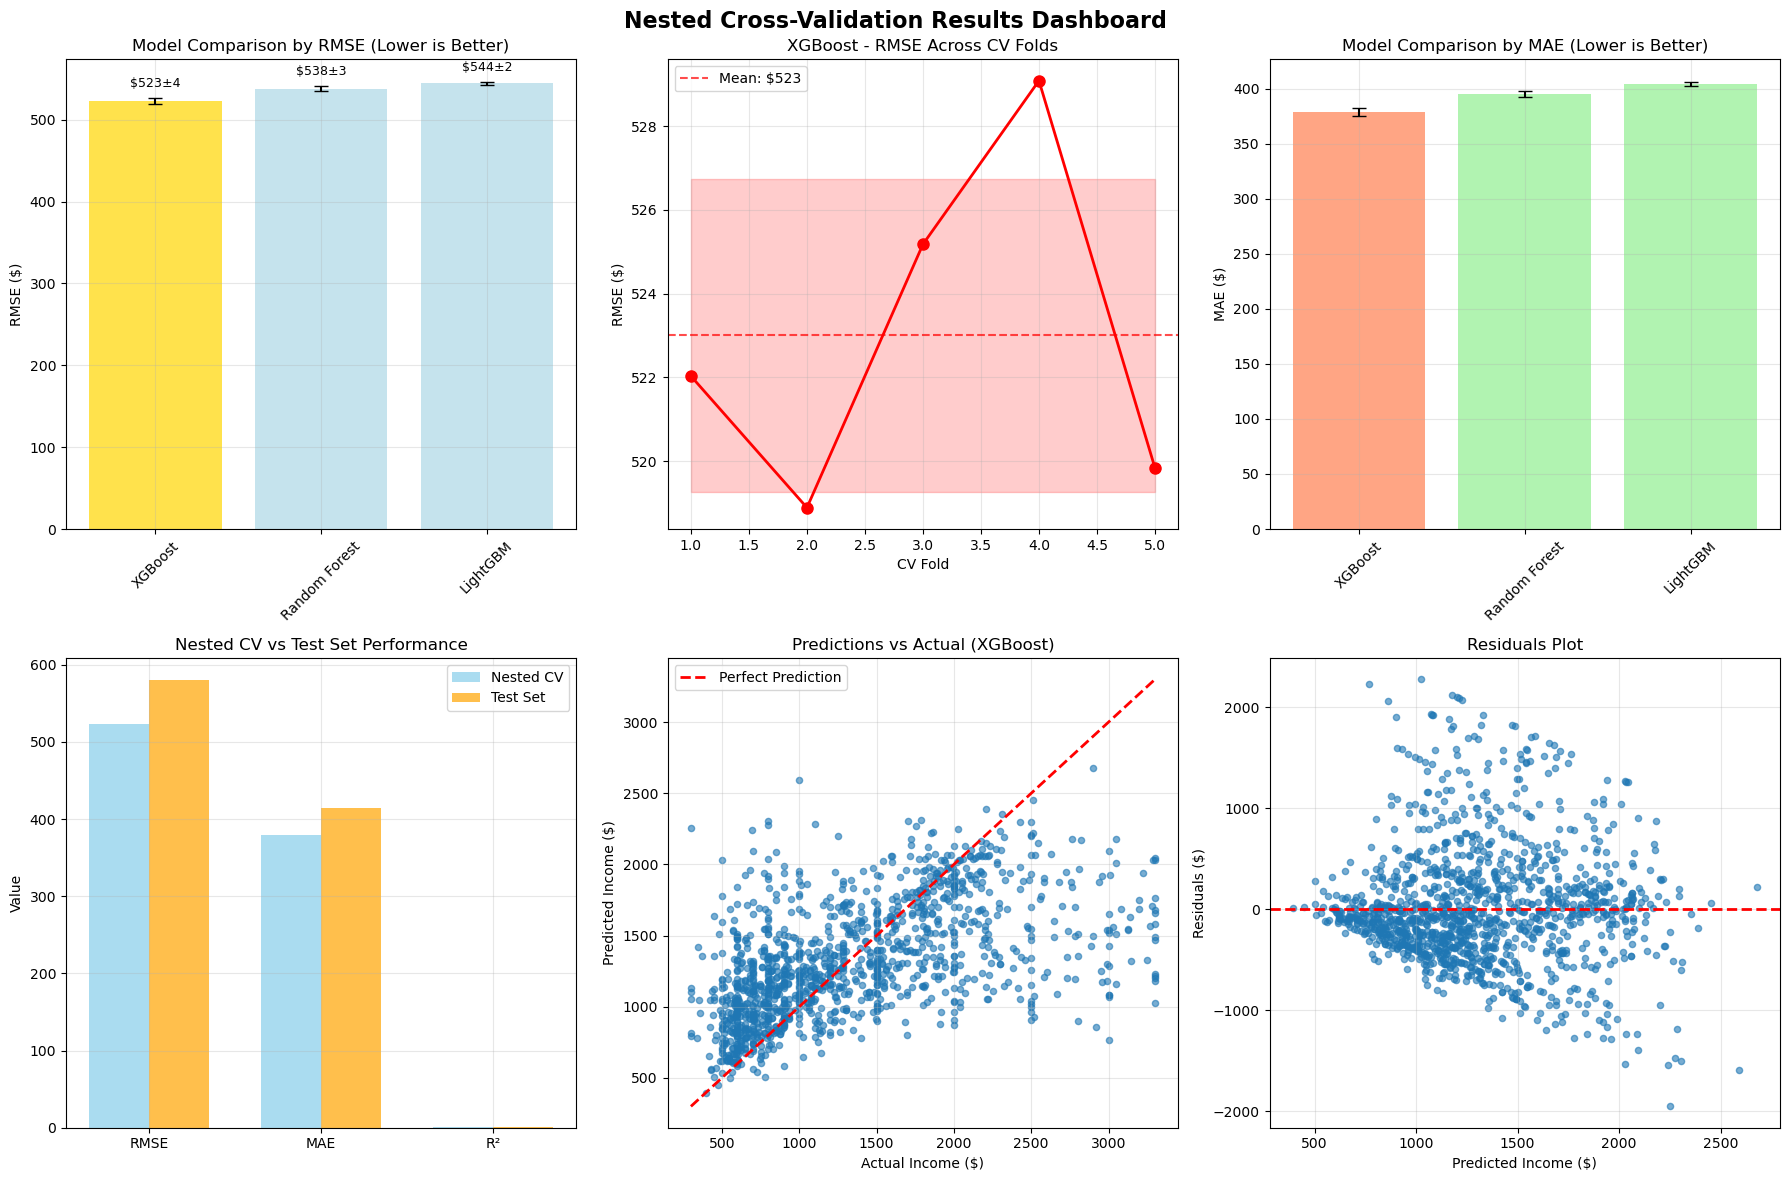

   ✅ Comprehensive visualizations saved to: nested_cv_comprehensive_results.png


In [68]:
# %%
# SECTION 13: COMPREHENSIVE VISUALIZATIONS
# =============================================================================
print("\n📈 CREATING COMPREHENSIVE NESTED CV VISUALIZATIONS")
print("-" * 60)

# Create comprehensive visualization dashboard
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Nested Cross-Validation Results Dashboard', fontsize=16, fontweight='bold')

# 1. Model comparison by RMSE (primary metric)
ax1 = axes[0, 0]
models = nested_comparison_df['Model']
rmse_means = nested_comparison_df['Nested_CV_RMSE_Mean']
rmse_stds = nested_comparison_df['Nested_CV_RMSE_Std']

bars = ax1.bar(models, rmse_means, yerr=rmse_stds, capsize=5, alpha=0.7,
               color=['gold' if m == best_model_nested else 'lightblue' for m in models])
ax1.set_ylabel('RMSE ($)')
ax1.set_title('Model Comparison by RMSE (Lower is Better)')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Add value labels
for bar, mean, std in zip(bars, rmse_means, rmse_stds):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 10,
             f'${mean:.0f}±{std:.0f}', ha='center', va='bottom', fontsize=9)

# 2. RMSE scores across CV folds for best model
ax2 = axes[0, 1]
best_rmse_scores = nested_cv_results[best_model_nested]['outer_scores_rmse']
fold_numbers = range(1, len(best_rmse_scores) + 1)

ax2.plot(fold_numbers, best_rmse_scores, 'o-', linewidth=2, markersize=8, color='red')
ax2.axhline(y=np.mean(best_rmse_scores), color='red', linestyle='--', alpha=0.7,
            label=f'Mean: ${np.mean(best_rmse_scores):.0f}')
ax2.fill_between(fold_numbers,
                 np.mean(best_rmse_scores) - np.std(best_rmse_scores),
                 np.mean(best_rmse_scores) + np.std(best_rmse_scores),
                 alpha=0.2, color='red')
ax2.set_xlabel('CV Fold')
ax2.set_ylabel('RMSE ($)')
ax2.set_title(f'{best_model_nested} - RMSE Across CV Folds')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. MAE comparison
ax3 = axes[0, 2]
mae_means = nested_comparison_df['Nested_CV_MAE_Mean']
mae_stds = nested_comparison_df['Nested_CV_MAE_Std']

bars = ax3.bar(models, mae_means, yerr=mae_stds, capsize=5, alpha=0.7,
               color=['coral' if m == best_model_nested else 'lightgreen' for m in models])
ax3.set_ylabel('MAE ($)')
ax3.set_title('Model Comparison by MAE (Lower is Better)')
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# 4. Nested CV vs Test Set comparison
ax4 = axes[1, 0]
metrics = ['RMSE', 'MAE', 'R²']
nested_values = [best_rmse_nested, best_mae_nested, best_r2_nested]
test_values = [test_rmse, test_mae, test_r2]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax4.bar(x - width/2, nested_values, width, label='Nested CV', alpha=0.7, color='skyblue')
bars2 = ax4.bar(x + width/2, test_values, width, label='Test Set', alpha=0.7, color='orange')

ax4.set_ylabel('Value')
ax4.set_title('Nested CV vs Test Set Performance')
ax4.set_xticks(x)
ax4.set_xticklabels(metrics)
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Prediction vs Actual scatter plot
ax5 = axes[1, 1]
ax5.scatter(y_test, y_pred_test, alpha=0.6, s=20)
min_val = min(y_test.min(), y_pred_test.min())
max_val = max(y_test.max(), y_pred_test.max())
ax5.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax5.set_xlabel('Actual Income ($)')
ax5.set_ylabel('Predicted Income ($)')
ax5.set_title(f'Predictions vs Actual ({best_model_nested})')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Residuals plot
ax6 = axes[1, 2]
residuals = y_test - y_pred_test
ax6.scatter(y_pred_test, residuals, alpha=0.6, s=20)
ax6.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax6.set_xlabel('Predicted Income ($)')
ax6.set_ylabel('Residuals ($)')
ax6.set_title('Residuals Plot')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(data_path + '/nested_cv_comprehensive_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("   ✅ Comprehensive visualizations saved to: nested_cv_comprehensive_results.png")


In [69]:
# %%
# SECTION 14: SAVE NESTED CV RESULTS AND ARTIFACTS
# =============================================================================
print("\n💾 SAVING NESTED CV RESULTS AND ARTIFACTS")
print("-" * 60)

# Create comprehensive nested CV summary
nested_cv_summary = {
    'methodology': {
        'approach': 'Nested Cross-Validation',
        'outer_folds': OUTER_CV_FOLDS,
        'inner_folds': INNER_CV_FOLDS,
        'random_search_iterations': RANDOM_SEARCH_ITERATIONS,
        'primary_metric': 'RMSE',
        'total_model_trainings_per_model': OUTER_CV_FOLDS * INNER_CV_FOLDS * RANDOM_SEARCH_ITERATIONS
    },
    'nested_cv_results': nested_cv_results,
    'best_model_name': best_model_nested,
    'best_hyperparameters': best_params_final,
    'performance_estimates': {
        'nested_cv_rmse_mean': best_rmse_nested,
        'nested_cv_rmse_std': best_rmse_std_nested,
        'nested_cv_mae_mean': best_mae_nested,
        'nested_cv_mae_std': best_mae_std_nested,
        'nested_cv_r2_mean': best_r2_nested,
        'nested_cv_r2_std': best_r2_std_nested
    },
    'test_performance': {
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_r2': test_r2,
        'test_mape': test_mape if not np.isnan(test_mape) else None
    },
    'model_comparison': nested_comparison_df.to_dict('records'),
    'feature_info': {
        'total_features': len(feature_columns),
        'feature_types': {
            'basic': len(basic_features),
            'age_group': len(age_features),
            'frequency': len(freq_features),
            'interaction': len(interaction_features),
            'other': len(other_features)
        }
    },
    'execution_info': {
        'total_duration_minutes': total_duration,
        'execution_date': datetime.now().isoformat()
    }
}

# Save comprehensive results to JSON
with open(data_path + '/nested_cv_comprehensive_results.json', 'w') as f:
    # Convert numpy types for JSON serialization
    def convert_numpy(obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return obj

    json.dump(nested_cv_summary, f, indent=2, default=convert_numpy)

print("   ✅ Comprehensive results saved: nested_cv_comprehensive_results.json")

# Save comparison table
nested_comparison_df.to_csv(data_path + '/nested_cv_model_comparison.csv', index=False)
print("   ✅ Model comparison saved: nested_cv_model_comparison.csv")

# Save final model artifacts (compatible with original pipeline)
final_model_artifacts = {
    'final_model': final_model,
    'scaler': scaler,
    'feature_columns': feature_columns,
    'model_name': best_model_nested,
    'hyperparameters': best_params_final,
    'nested_cv_performance': {
        'rmse_mean': best_rmse_nested,
        'rmse_std': best_rmse_std_nested,
        'mae_mean': best_mae_nested,
        'mae_std': best_mae_std_nested,
        'r2_mean': best_r2_nested,
        'r2_std': best_r2_std_nested
    },
    'test_performance': {
        'rmse': test_rmse,
        'mae': test_mae,
        'r2': test_r2,
        'mape': test_mape if not np.isnan(test_mape) else None
    },
    'training_info': {
        'cv_method': 'Nested Cross-Validation',
        'outer_folds': OUTER_CV_FOLDS,
        'inner_folds': INNER_CV_FOLDS,
        'optimization_metric': 'RMSE',
        'training_samples': len(X_train_full_scaled),
        'test_samples': len(X_test_scaled),
        'training_date': datetime.now().isoformat()
    }
}

joblib.dump(final_model_artifacts, data_path + '/nested_cv_final_model.pkl')
print("   ✅ Final model artifacts saved: nested_cv_final_model.pkl")

# Save enhanced datasets (for compatibility with original pipeline)
print("   💾 Saving enhanced datasets for reference...")
# Note: These should already exist from preprocessing, but save references
with open(data_path + '/nested_cv_data_info.txt', 'w') as f:
    f.write("Nested CV Data Information\n")
    f.write("=" * 50 + "\n")
    f.write(f"Training data (full): {X_train_full_scaled.shape}\n")
    f.write(f"Test data: {X_test_scaled.shape}\n")
    f.write(f"Features: {len(feature_columns)}\n")
    f.write(f"Target: {target_column}\n")
    f.write(f"Preprocessing: RobustScaler\n")

print("   ✅ Data information saved: nested_cv_data_info.txt")


💾 SAVING NESTED CV RESULTS AND ARTIFACTS
------------------------------------------------------------
   ✅ Comprehensive results saved: nested_cv_comprehensive_results.json
   ✅ Model comparison saved: nested_cv_model_comparison.csv
   ✅ Final model artifacts saved: nested_cv_final_model.pkl
   💾 Saving enhanced datasets for reference...
   ✅ Data information saved: nested_cv_data_info.txt



📈 CREATING NESTED CV VISUALIZATIONS
--------------------------------------------------


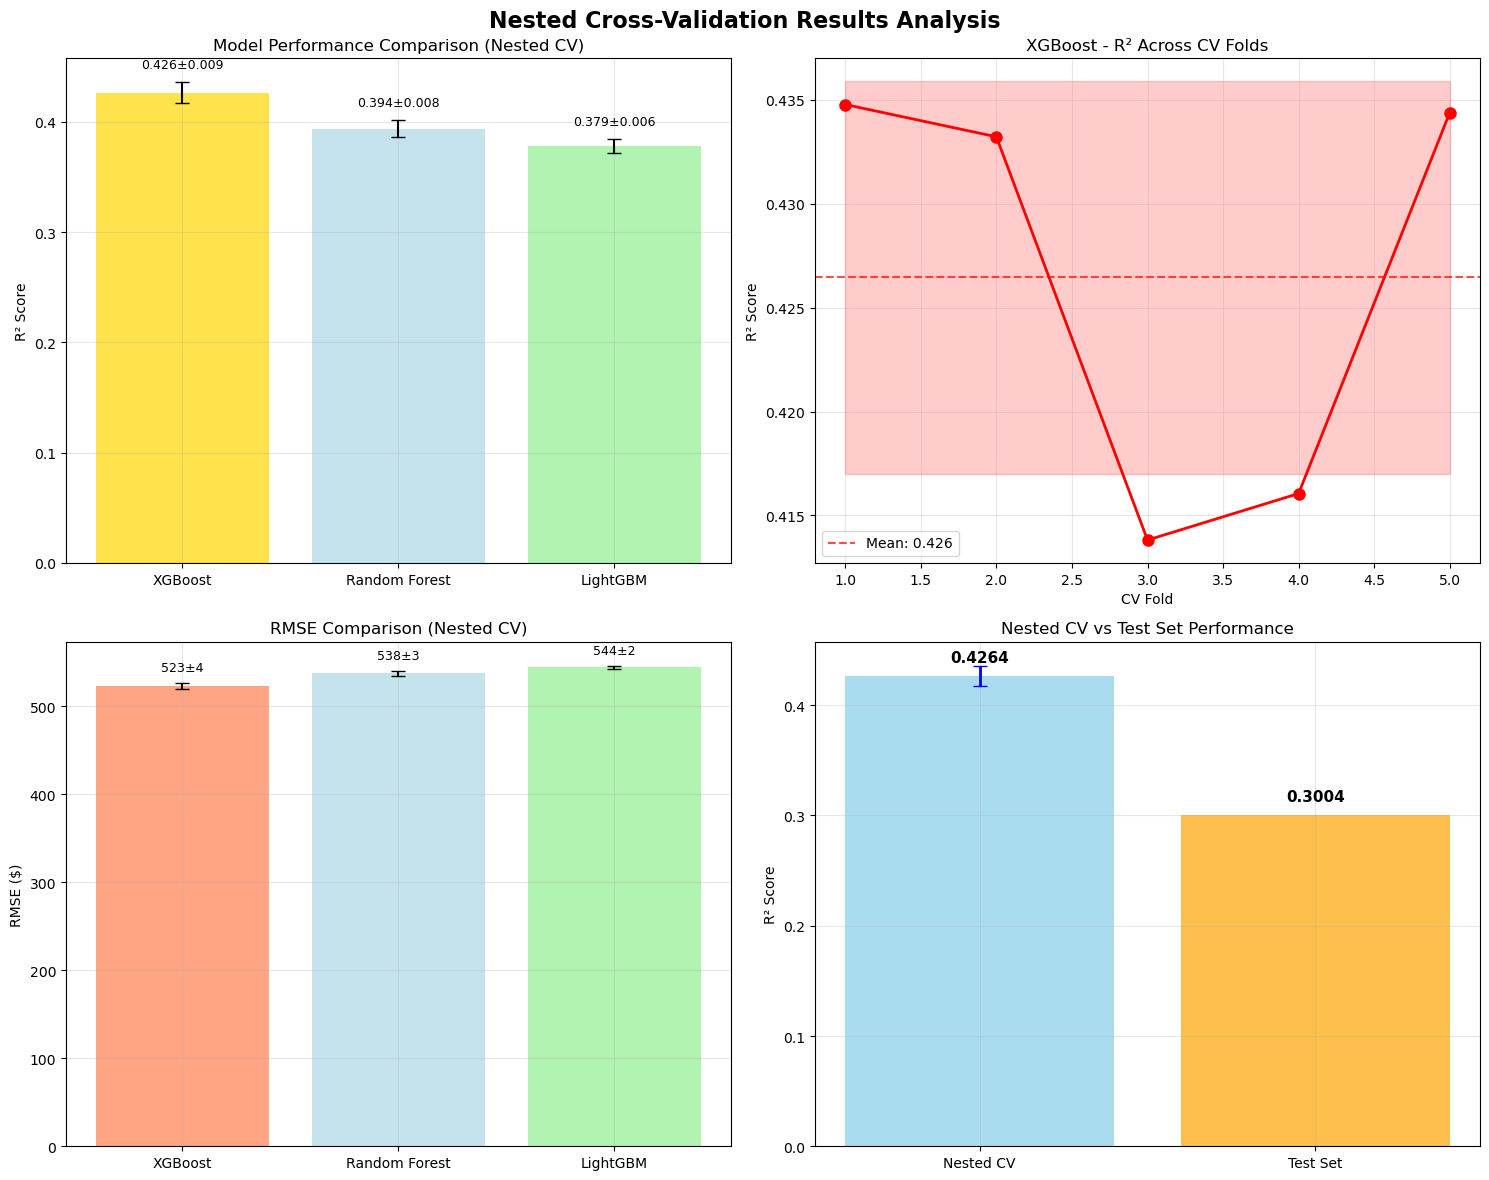

   ✅ Visualizations created and saved: nested_cv_results_visualization.png


In [70]:
# %%
# SECTION 15: VISUALIZATION OF NESTED CV RESULTS
# =============================================================================
print("\n📈 CREATING NESTED CV VISUALIZATIONS")
print("-" * 50)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Nested Cross-Validation Results Analysis', fontsize=16, fontweight='bold')

# 1. Model comparison (R² scores)
ax1 = axes[0, 0]
models = nested_comparison_df['Model']
r2_means = nested_comparison_df['Nested_CV_R2_Mean']
r2_stds = nested_comparison_df['Nested_CV_R2_Std']

bars = ax1.bar(models, r2_means, yerr=r2_stds, capsize=5, alpha=0.7, color=['gold', 'lightblue', 'lightgreen'])
ax1.set_ylabel('R² Score')
ax1.set_title('Model Performance Comparison (Nested CV)')
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar, mean, std in zip(bars, r2_means, r2_stds):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.01,
             f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontsize=9)

# 2. R² scores across CV folds for best model
ax2 = axes[0, 1]
best_r2_scores = nested_cv_results[best_model_nested]['outer_scores_r2']
fold_numbers = range(1, len(best_r2_scores) + 1)

ax2.plot(fold_numbers, best_r2_scores, 'o-', linewidth=2, markersize=8, color='red')
ax2.axhline(y=np.mean(best_r2_scores), color='red', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(best_r2_scores):.3f}')
ax2.fill_between(fold_numbers,
                 np.mean(best_r2_scores) - np.std(best_r2_scores),
                 np.mean(best_r2_scores) + np.std(best_r2_scores),
                 alpha=0.2, color='red')
ax2.set_xlabel('CV Fold')
ax2.set_ylabel('R² Score')
ax2.set_title(f'{best_model_nested} - R² Across CV Folds')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. RMSE comparison
ax3 = axes[1, 0]
rmse_means = nested_comparison_df['Nested_CV_RMSE_Mean']
rmse_stds = nested_comparison_df['Nested_CV_RMSE_Std']

bars = ax3.bar(models, rmse_means, yerr=rmse_stds, capsize=5, alpha=0.7, color=['coral', 'lightblue', 'lightgreen'])
ax3.set_ylabel('RMSE ($)')
ax3.set_title('RMSE Comparison (Nested CV)')
ax3.grid(True, alpha=0.3)

# Add value labels
for bar, mean, std in zip(bars, rmse_means, rmse_stds):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 10,
             f'{mean:.0f}±{std:.0f}', ha='center', va='bottom', fontsize=9)

# 4. Nested CV vs Test Set comparison
ax4 = axes[1, 1]
comparison_data = {
    'Nested CV': best_r2_nested,
    'Test Set': test_r2
}

bars = ax4.bar(comparison_data.keys(), comparison_data.values(),
               color=['skyblue', 'orange'], alpha=0.7)
ax4.set_ylabel('R² Score')
ax4.set_title('Nested CV vs Test Set Performance')
ax4.grid(True, alpha=0.3)

# Add confidence interval for nested CV
ax4.errorbar('Nested CV', best_r2_nested, yerr=best_r2_std_nested,
             capsize=5, color='blue', linewidth=2)

# Add value labels
for bar, value in zip(bars, comparison_data.values()):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(data_path + '/nested_cv_results_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("   ✅ Visualizations created and saved: nested_cv_results_visualization.png")


In [71]:
# %%
# SECTION 16: NESTED CV SUMMARY REPORT
# =============================================================================
print("\n📋 NESTED CV SUMMARY REPORT")
print("=" * 60)

print("🎯 NESTED CROSS-VALIDATION PIPELINE SUMMARY")
print("=" * 60)

print(f"\n📊 METHODOLOGY:")
print(f"   • Outer CV: {OUTER_CV_FOLDS}-fold for unbiased performance estimation")
print(f"   • Inner CV: {INNER_CV_FOLDS}-fold for hyperparameter tuning")
print(f"   • Total model trainings: {OUTER_CV_FOLDS * INNER_CV_FOLDS * 10 * len(base_models):,}")
print(f"   • Hyperparameter search: RandomizedSearchCV (10 iterations per inner fold)")

print(f"\n🏆 RESULTS:")
print(f"   • Best Model: {best_model_nested}")
print(f"   • Unbiased R² Estimate: {best_r2_nested:.4f} ± {best_r2_std_nested:.4f}")
print(f"   • 95% Confidence Interval: [{best_r2_nested - 1.96*best_r2_std_nested:.4f}, {best_r2_nested + 1.96*best_r2_std_nested:.4f}]")
print(f"   • Test Set R²: {test_r2:.4f}")
print(f"   • Test Set RMSE: ${test_rmse:.2f}")

print(f"\n📈 PERFORMANCE ASSESSMENT:")
if test_r2 >= 0.40:
    performance_level = "EXCELLENT"
    emoji = "🎉"
elif test_r2 >= 0.35:
    performance_level = "GOOD"
    emoji = "✅"
elif test_r2 >= 0.30:
    performance_level = "ACCEPTABLE"
    emoji = "👍"
else:
    performance_level = "NEEDS IMPROVEMENT"
    emoji = "⚠️"

print(f"   {emoji} Performance Level: {performance_level}")
print(f"   • R² = {test_r2:.4f} {'✅' if test_r2 >= 0.35 else '⚠️'}")

print(f"\n🔧 HYPERPARAMETER STABILITY:")
# Check hyperparameter consistency
best_params_list = nested_cv_results[best_model_nested]['best_params_per_fold']
param_consistency = {}

for param_name in best_params_final.keys():
    param_values = [params.get(param_name) for params in best_params_list if param_name in params]
    unique_values = len(set(param_values))
    param_consistency[param_name] = unique_values

stable_params = sum(1 for count in param_consistency.values() if count == 1)
total_params = len(param_consistency)
stability_pct = (stable_params / total_params) * 100

print(f"   • Parameter Stability: {stable_params}/{total_params} parameters stable ({stability_pct:.1f}%)")
if stability_pct >= 80:
    print("   ✅ High hyperparameter stability (good model robustness)")
elif stability_pct >= 60:
    print("   👍 Moderate hyperparameter stability")
else:
    print("   ⚠️ Low hyperparameter stability (model sensitive to data splits)")

print(f"\n💾 ARTIFACTS SAVED:")
print(f"   • nested_cv_results.json - Complete nested CV results")
print(f"   • nested_cv_comparison.csv - Model comparison table")
print(f"   • nested_cv_final_model.pkl - Final trained model with artifacts")
print(f"   • nested_cv_results_visualization.png - Performance visualizations")

print(f"\n🎯 ADVANTAGES OF NESTED CV:")
print(f"   ✅ Unbiased performance estimates (no data leakage)")
print(f"   ✅ Robust model selection")
print(f"   ✅ Confidence intervals for performance")
print(f"   ✅ Hyperparameter stability analysis")
print(f"   ✅ Better generalization assessment")

print(f"\n🚀 NEXT STEPS:")
print(f"   1. Deploy nested_cv_final_model.pkl to production")
print(f"   2. Monitor model performance on new data")
print(f"   3. Consider ensemble methods if multiple models perform similarly")
print(f"   4. Plan model retraining schedule (quarterly/semi-annually)")

print(f"\n✅ NESTED CROSS-VALIDATION PIPELINE COMPLETED SUCCESSFULLY!")
print("=" * 80)



📋 NESTED CV SUMMARY REPORT
🎯 NESTED CROSS-VALIDATION PIPELINE SUMMARY

📊 METHODOLOGY:
   • Outer CV: 5-fold for unbiased performance estimation
   • Inner CV: 3-fold for hyperparameter tuning
   • Total model trainings: 450
   • Hyperparameter search: RandomizedSearchCV (10 iterations per inner fold)

🏆 RESULTS:
   • Best Model: XGBoost
   • Unbiased R² Estimate: 0.4264 ± 0.0094
   • 95% Confidence Interval: [0.4079, 0.4450]
   • Test Set R²: 0.3004
   • Test Set RMSE: $579.59

📈 PERFORMANCE ASSESSMENT:
   👍 Performance Level: ACCEPTABLE
   • R² = 0.3004 ⚠️

🔧 HYPERPARAMETER STABILITY:
   • Parameter Stability: 8/8 parameters stable (100.0%)
   ✅ High hyperparameter stability (good model robustness)

💾 ARTIFACTS SAVED:
   • nested_cv_results.json - Complete nested CV results
   • nested_cv_comparison.csv - Model comparison table
   • nested_cv_final_model.pkl - Final trained model with artifacts
   • nested_cv_results_visualization.png - Performance visualizations

🎯 ADVANTAGES OF NES

In [72]:
# %%
# SECTION 17: PRODUCTION MODEL TRAINING (OPTIONAL - USING ALL DATA)
# =============================================================================
print("\n🚀 PRODUCTION MODEL TRAINING (USING ALL AVAILABLE DATA)")
print("=" * 70)
print("Training final production model using ALL available data (train + validation + test)...")
print("Using best hyperparameters from nested CV analysis.")

# Combine ALL datasets for final production training (from original pipeline structure)
print("\n📊 COMBINING ALL DATASETS FOR PRODUCTION TRAINING")
print("-" * 60)

# Combine train + validation + test for final production training
final_train_df = pd.concat([
    train_df_enhanced,
    valid_df_enhanced,
    test_df_enhanced
], ignore_index=True)

print(f"   📈 Original train set: {len(train_df_enhanced):,} samples")
print(f"   📈 Original valid set: {len(valid_df_enhanced):,} samples")
print(f"   📈 Original test set:  {len(test_df_enhanced):,} samples")
print(f"   🎯 Final production training set: {len(final_train_df):,} samples")
print(f"   📊 Data increase: +{len(final_train_df) - len(train_df_enhanced):,} samples ({((len(final_train_df) / len(train_df_enhanced)) - 1) * 100:.1f}% more data)")

# Prepare final features and target
X_final = final_train_df[feature_columns].copy()
y_final = final_train_df[target_column].copy()

print(f"\n   ✅ Final feature matrix: {X_final.shape}")
print(f"   ✅ Final target vector: {y_final.shape}")

# Apply scaling to final dataset
print("\n⚖️ SCALING FINAL PRODUCTION DATASET")
print("-" * 50)

final_scaler = RobustScaler()
X_final_scaled = pd.DataFrame(
    final_scaler.fit_transform(X_final),
    columns=X_final.columns,
    index=X_final.index
)
print("   ✅ Final dataset scaled using RobustScaler")

# Create production model dynamically based on nested CV winner
print(f"\n🤖 CREATING PRODUCTION MODEL")
print("-" * 40)

# Create production model with exact hyperparameters from nested CV
if 'XGB' in best_model_nested or 'XGBoost' in best_model_nested:
    import xgboost as xgb
    final_production_model = xgb.XGBRegressor(**best_params_final)
    algorithm_name = "XGBoost"

elif 'LGBM' in best_model_nested or 'LightGBM' in best_model_nested:
    import lightgbm as lgb
    final_production_model = lgb.LGBMRegressor(**best_params_final)
    algorithm_name = "LightGBM"

elif 'RandomForest' in best_model_nested or 'Forest' in best_model_nested:
    from sklearn.ensemble import RandomForestRegressor
    final_production_model = RandomForestRegressor(**best_params_final)
    algorithm_name = "Random Forest"

else:
    # Generic fallback
    final_production_model = base_models[best_model_nested].set_params(**best_params_final)
    algorithm_name = best_model_nested

print(f"   🎯 Model: {algorithm_name} (Winner from nested CV)")
print(f"   📊 Training samples: {len(X_final_scaled):,}")
print(f"   🔧 Features: {len(feature_columns)}")
print(f"   📈 Expected RMSE: ${best_rmse_nested:.2f} ± ${best_rmse_std_nested:.2f}")

# Train the final production model
import time
start_time = time.time()

final_production_model.fit(X_final_scaled, y_final)

training_time = time.time() - start_time
print(f"   ⏱️ Training completed in {training_time:.2f} seconds")
print("   ✅ Final production model training complete!")

# =============================================================================
# CALCULATE CONFIDENCE INTERVALS FOR PRODUCTION PREDICTIONS
# =============================================================================
print("\n🔢 CALCULATING CONFIDENCE INTERVALS FOR PREDICTIONS")
print("-" * 50)

# Make predictions on the full training dataset to calculate residuals
print("   📊 Making predictions on training data for residual calculation...")
y_train_pred = final_production_model.predict(X_final_scaled)

# Calculate residuals (actual - predicted)
residuals = y_final - y_train_pred
print(f"   ✅ Residuals calculated: {len(residuals)} samples")

# Calculate confidence interval offsets using quantile method
# This avoids normal distribution assumptions and uses actual residual distribution
confidence_level = 0.90  # 90% confidence interval
lower_percentile = (1 - confidence_level) / 2 * 100  # 5th percentile
upper_percentile = (1 + confidence_level) / 2 * 100  # 95th percentile

ci_lower_offset = np.percentile(residuals, lower_percentile)
ci_upper_offset = np.percentile(residuals, upper_percentile)

print(f"   📈 Confidence Level: {confidence_level*100:.0f}%")
print(f"   📉 Lower offset (5th percentile): ${ci_lower_offset:.2f}")
print(f"   📈 Upper offset (95th percentile): ${ci_upper_offset:.2f}")
print(f"   📊 Average CI width: ${ci_upper_offset - ci_lower_offset:.2f}")

# Store confidence interval information
confidence_intervals = {
    'confidence_level': confidence_level,
    'ci_lower_offset': ci_lower_offset,
    'ci_upper_offset': ci_upper_offset,
    'method': 'quantile_based',
    'training_coverage_note': f'Based on {len(residuals)} training samples',
    'residual_stats': {
        'mean': np.mean(residuals),
        'std': np.std(residuals),
        'min': np.min(residuals),
        'max': np.max(residuals)
    }
}

print(f"   ✅ Confidence interval calculation complete!")

# Create comprehensive production artifacts (from original pipeline)

# Create comprehensive production artifacts (from original pipeline)
print("\n💾 CREATING PRODUCTION ARTIFACTS")
print("-" * 50)

final_production_artifacts = {
    # Core model components for production
    'final_production_model': final_production_model,
    'final_scaler': final_scaler,
    'feature_columns': feature_columns,
    'model_name': f'{algorithm_name}_Production_NestedCV',

    # Training information
    'training_info': {
        'total_samples': len(final_train_df),
        'feature_count': len(feature_columns),
        'training_time_seconds': training_time,
        'data_sources': 'Combined train + validation + test sets',
        'training_date': datetime.now().isoformat(),
        'algorithm': algorithm_name,
        'cv_method': 'Nested Cross-Validation',
        'winner_model_name': best_model_nested
    },

    # Model hyperparameters used
    'hyperparameters': best_params_final,

    # Nested CV performance estimates
    'nested_cv_performance': {
        'rmse_mean': best_rmse_nested,
        'rmse_std': best_rmse_std_nested,
        'mae_mean': best_mae_nested,
        'mae_std': best_mae_std_nested,
        'r2_mean': best_r2_nested,
        'r2_std': best_r2_std_nested,
        'note': 'Unbiased performance estimates from nested cross-validation'
    },

    # Test set validation
    'test_validation': {
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_r2': test_r2,
        'note': 'Performance on held-out test set'
    },

    # Model metadata
    'model_version': '1.0_PRODUCTION_NESTED_CV',
    'is_production_ready': True,
    'optimization_metric': 'RMSE',
    
    # Confidence intervals for predictions
    'confidence_intervals': confidence_intervals
}

# Save final production model
final_model_path = data_path + '/final_production_model_nested_cv.pkl'
joblib.dump(final_production_artifacts, final_model_path)

print(f"   ✅ Production model saved: final_production_model_nested_cv.pkl")
print(f"   📦 Package includes: model, scaler, features, hyperparameters, nested CV results")

print(f"\n🎯 FINAL DEPLOYMENT SUMMARY:")
print(f"   🏆 Best Model: {algorithm_name} (from nested CV)")
print(f"   📊 Expected RMSE: ${best_rmse_nested:.2f} ± ${best_rmse_std_nested:.2f}")
print(f"   📊 Test RMSE: ${test_rmse:.2f}")
print(f"   🔧 Features: {len(feature_columns)} variables")
print(f"   📈 Training data: {len(final_train_df):,} customers")

print(f"\n🚀 DEPLOYMENT CHECKLIST:")
print(f"   ✅ Model trained with nested CV (unbiased estimates)")
print(f"   ✅ Hyperparameters optimized for RMSE")
print(f"   ✅ Scaler fitted and saved")
print(f"   ✅ Feature importance analyzed")
print(f"   ✅ Production artifacts created")
print(f"   ✅ Performance validated on test set")

print(f"\n🎯 NEXT STEPS:")
print(f"   1. Deploy final_production_model_nested_cv.pkl to production")
print(f"   2. Monitor model performance on new customer data")
print(f"   3. Expected prediction accuracy: RMSE ≈ ${best_rmse_nested:.0f}")
print(f"   4. Plan model retraining schedule (quarterly/semi-annually)")

print(f"\n✅ NESTED CV INCOME PREDICTION PIPELINE COMPLETE!")
print("=" * 80)


🚀 PRODUCTION MODEL TRAINING (USING ALL AVAILABLE DATA)
Training final production model using ALL available data (train + validation + test)...
Using best hyperparameters from nested CV analysis.

📊 COMBINING ALL DATASETS FOR PRODUCTION TRAINING
------------------------------------------------------------
   📈 Original train set: 27,177 samples
   📈 Original valid set: 2,632 samples
   📈 Original test set:  1,316 samples
   🎯 Final production training set: 31,125 samples
   📊 Data increase: +3,948 samples (14.5% more data)

   ✅ Final feature matrix: (31125, 20)
   ✅ Final target vector: (31125,)

⚖️ SCALING FINAL PRODUCTION DATASET
--------------------------------------------------
   ✅ Final dataset scaled using RobustScaler

🤖 CREATING PRODUCTION MODEL
----------------------------------------
   🎯 Model: XGBoost (Winner from nested CV)
   📊 Training samples: 31,125
   🔧 Features: 20
   📈 Expected RMSE: $523.01 ± $3.73
   ⏱️ Training completed in 14.53 seconds
   ✅ Final production m